<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Porsche/Porsche_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "PAH3.DE"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close   Volume
Date                                                      
2009-01-28  38.30  40.42  37.83  39.94      29.25   901567
2009-01-29  39.89  40.00  37.91  38.41      28.13   629475
2009-01-30  38.06  40.95  37.95  39.32      28.80  1467863
2009-02-02  37.01  37.42  35.65  36.11      26.93  1350452
2009-02-03  36.25  36.49  35.10  35.95      26.81  1183009
...           ...    ...    ...    ...        ...      ...
2018-12-19  55.20  55.98  54.92  55.14      53.04   486506
2018-12-20  54.14  54.70  53.30  53.52      51.48   568491
2018-12-21  52.70  54.74  52.22  53.54      51.50  1134954
2018-12-27  53.46  53.68  50.72  51.30      49.35   639096
2018-12-28  51.60  52.14  51.28  51.64      49.67   308952

[2520 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2520.000000  2520.000000  2520.000000  2520.000000  2520.000000  2.520000e+03
mean     53.679849    54.411540    52.849282    53.645980    44.381444  6.314802e+05
std      14.166758    14.140459    14.125244    14.137326    13.199340  4.775679e+05
min      24.920000    25.380000    23.180000    24.650000    18.380000  0.000000e+00
25%      42.900000    43.842500    41.962500    42.845000    33.110000  3.641480e+05
50%      50.900000    51.425000    50.110000    50.910000    43.850000  5.053825e+05
75%      64.445000    65.005000    63.642500    64.362500    54.330000  7.356988e+05
max      93.150000    94.560000    92.820000    94.000000    76.820000  5.944992e+06

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-04-09  38.49  40.32  37.71  40.13      29.93   823372    9          3         99             30             0               0               0                 0      4        2    15        3             1          15  38.150437  34.104230  31.513245  38.672099  36.614852  34.590229      35.185      34.775  32.542087  35.70375  39.481571  36.0480  37.190000  35.70375  38.206667  33.309830               42.094375                 35.70375               29.313125               45.289688                 35.70375               26.117812               48.485001                 35.70375               22.922499               51.680314                 35.70375               19.727186  36.614852  38.654902  33.561149               43.005477                36.614852               30.224226               46.200790                36.614852               27.028913               49.396102                36.614852               23.833601               52.591415                36.614852   
2009-04-14  40.33  42.66  39.07  42.20      31.47  1381309   14          1        104             30             0               0               0                 0      4        2    16        1             4          16  38.352915  34.210447  32.217786  40.421411  37.855996  37.153676      36.570      36.175  33.164320  37.19875  41.446242  37.2125  38.633611  37.19875  41.165000  33.749997               43.369191                 37.19875               31.028309               46.454412                 37.19875               27.943088               49.539632                 37.19875               24.857868               52.624853                 37.19875               21.772647  37.855996  41.222556  34.051988               44.026437                37.855996               31.685555               47.111657                37.855996               28.600334               50.196878                37.855996               25.515113               53.282098                37.855996   
2009-04-15  41.37  42.52  40.48  41.58      3

Open         High          Low       Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2470.000000  2470.000000  2470.000000  2470.00000  2470.000000  2.470000e+03  2470.000000  2470.000000  2470.000000    2470.000000   2470.000000     2470.000000     2470.000000       2470.000000  2470.000000  2470.000000  2470.000000  2470.000000   2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000             2470.000000              2470.000000             2470.000000             2470.000000              2470.000000             2470.000000             2470.000000              2470.000000             2470.000000             2470.000000              2470.000000             2470.000000  2470.000000  2470.000000  2470.000000             2470.000000              2470.000000             2470.000000             2470.000000              2470.000000             2470.000000             2470.000000   
mean     54.102316    54.822271    53.278227    54.06600    44.783879  6.186176e+05    15.755870     2.003239   186.093117      30.457490      0.031174        0.027935        0.008097          0.007692     6.621053     2.540486    27.064777     2.003239      1.995142    27.064777    54.022355    53.967111    -2.746027    54.070042    54.040733    54.087279    54.013682    53.947518    53.858906    54.042486    54.067690    54.043318    54.051172    54.042486    54.055045    53.979765               56.439326                54.042486               51.645645               57.637746                54.042486               50.447225               58.836167                54.042486               49.248805               60.034587                54.042486               48.050385    54.040733    54.058647    53.989697               56.437574                54.040733               51.643893               57.635994                54.040733               50.445473               58.834414   
std      13.981067    13.971215    13.927470    13.95365    13.016034  4.667658e+05     8.704682     1.407895   103.346105       0.789008      0.173823        0.164821        0.089637          0.087386     3.387808     1.102567    14.783186     1.407895      1.419066    14.783186    13.922545    13.805555    55.804930    13.982336    13.863863    13.853060    13.888688    13.846585    13.987606    13.898027    13.972523    13.913950    13.903992    13.898027    13.951976    13.811784               13.994296                13.898027               13.961861               14.101658                13.898027               14.053348               14.247424                13.898027               14.183636               14.430430                13.898027               14.351668    13.863863    13.934101    13.823864               13.956759                13.863863               13.931471               14.062616                13.863863               14.024953               14.207009   
min      27.710000    28.460000    27.0100

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-04-09  0.164731  0.179425  0.162589  0.192596   0.169795   823372    9          3         99             30             0               0               0                 0      4        2    15        3             1          15  0.147558  0.066983  0.689941  0.161157  0.122458  0.081855    0.103684    0.094892  0.081896  0.111471  0.174040  0.116088  0.133468  0.111471  0.157860  0.063192                0.182641                 0.111471                0.040074                0.214771                 0.111471                0.082078                0.245131                 0.111471                0.148578                0.275275                 0.111471                0.202260  0.122458  0.165196  0.068709                0.196504                 0.122458                0.072348                0.229030                 0.122458                0.114779                0.259854                 0.122458                0.178064                0.291275                 0.122458   
2009-04-14  0.192848  0.214826  0.183255  0.223621   0.197061  1381309   14          1        104             30             0               0               0                 0      4        2    16        1             4          16  0.150804  0.068754  0.693797  0.188111  0.142147  0.123899    0.125442    0.116997  0.091108  0.135088  0.204154  0.134371  0.156181  0.135088  0.202974  0.070380                0.202300                 0.135088                0.067254                0.232342                 0.135088                0.108783                0.260676                 0.135088                0.173955                0.288864                 0.135088                0.226521  0.142147  0.204314  0.076684                0.212545                 0.142147                0.095132                0.243031                 0.142147                0.137346                0.271872                 0.142147                0.199715                0.301372                 0.142147   
2009-04-15  0.208741  0.212708  0.204680  0.214329  

140221

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpq62_txop
  JVM stdout: /tmp/tmpq62_txop/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpq62_txop/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_c4jzfz
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_162157_mod...  0.580816  0.712013              0.466973  0.508884  0.258962
1  DeepLearning_grid_1_AutoML_20190828_162157_mod...  0.566871  0.990747              0.471973  0.581633  0.338297
2  DeepLearning_grid_1_AutoML_20190828_162157_mod...  0.559320  0.685090              0.484592  0.496024  0.246040
3              DeepLearning_1_AutoML_20190828_162157  0.528776  1.269954              0.500000  0.602489  0.362994
4  DeepLearning_grid_1_AutoML_20190828_162157_mod...  0.518912  0.936368              0.484592  0.558278  0.311674
5  DeepLearning_grid_1_AutoML_20190828_162157_mod...  0.512177  0.699087              0.500000  0.502960  0.252969
6  DeepLearning_grid_1_AutoML_20190828_162157_mod...  0.507959  0.934213              0.482993  0.576024  0.331804
7  DeepLearning_grid_1_AutoML_20190828_162157_mod...  0.500000  0.700272              0.500000  0.503548  0.253561
8  DeepLearning_grid_1_AutoML_20190828_162157_mod...  0.495408  0.695785              0.482993  0.501927  0.251931
9  DeepLearning_grid_1_AutoML_20190828_162157_mod...  0.488299  2.034487              0.500000  0.645896  0.417181

variable  relative_importance  scaled_importance  percentage
0               STOCHRSI_fastk             1.000000           1.000000    0.001962
1                          BOP             0.992744           0.992744    0.001948
2                          COS             0.951845           0.951845    0.001868
3                    dayofweek             0.897508           0.897508    0.001761
4                          SIN             0.885626           0.885626    0.001738
...                        ...                  ...                ...         ...
1036    BBANDS_lowerband_8_3_3             0.404504           0.404504    0.000794
1037                 MAVP_20_0             0.403113           0.403113    0.000791
1038  BBANDS_middleband_20_3_5             0.400836           0.400836    0.000787
1039            CDL3LINESTRIKE             0.398824           0.398824    0.000783
1040   BBANDS_upperband_30_1_4             0.396003           0.396003    0.000777

[1041 rows x 4 columns]

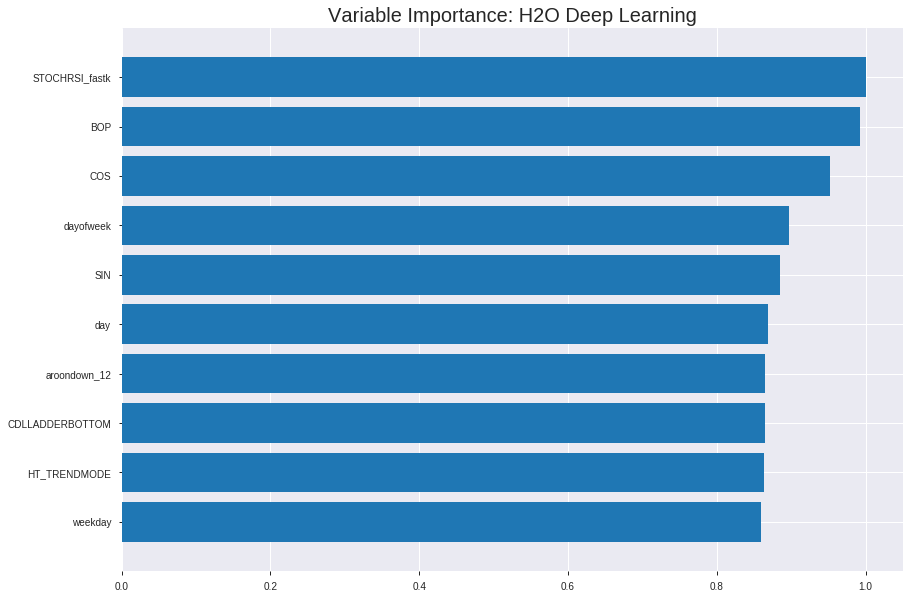

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_162157_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25695674518583644
RMSE: 0.5069090107562071
LogLoss: 0.7087649931982907
Mean Per-Class Error: 0.4649115638785699
AUC: 0.530837768647409
pr_auc: 0.5278909186582632
Gini: 0.061675537294817895
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24947087492612274: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    856   0.9965   (856.0/859.0)
1      0    869   0        (0.0/869.0)
Total  3    1725  0.4954   (856.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.249471     0.670008   396
max f2                       0.249471     0.835416   396
max f0point5                 0.42001      0.563549   332
max accuracy                 0.565497     0.534722   185
max precision                0.875003     1          0
max recall                   0.249471     1          396
max specificity              0.875003     1          0
max absolute_mcc             0.565497     0.0707409  185
max min_per_class_accuracy   0.547845     0.52359    204
max mean_per_class_accuracy  0.565497     0.535088   185

Gains/Lift Table: Avg response rate: 50.29 %, avg score: 54.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.79034            1.10472   1.10472            0.555556         0.836683  0.555556                    0.836683            0.0115075       0.0115075                  10.4718   10.4718
    2        0.0202546                   0.753602           1.05273   1.07947            0.529412         0.770377  0.542857                    0.804477            0.0103567       0.0218642                  5.27313   7.94674
    3        0.0300926                   0.736552           1.28667   1.14721            0.647059         0.743994  0.576923                    0.784704            0.0126582       0.0345224                  28.6672   14.7207
    4        0.0405093                   0.726807           1.10472   1.13628            0.555556         0.731137  0.571429                    0.77093             0.0115075       0.0460299                  10.4718   13.6281
    5        0.0503472                   0.717732           1.05273   1.11996            0.529412         0.72204   0.563218                    0.761376            0.0103567       0.0563867                  5.27313   11.9956
    6        0.100116                    0.681994           1.10986   1.11494            0.55814          0.699993  0.560694                    0.730862            0.0552359       0.111623                   10.9856   11.4935
    7        0.150463                    0.654495           0.937106  1.05543            0.471264         0.668628  0.530769                    0.710038            0.0471807       0.158803                   -6.28943  5.54306
    8        0.200231                    0.638078           1.01737   1.04597            0.511628         0.645717  0.526012                    0.69405             0.0506329       0.209436                   1.73683   4.59701
    9        0.300347                    0.605116           1.11494   1.06896            0.560694         0.621232  0.537572                    0.669778            0.111623        0.321059                   11.4935   6.89584
    10       0.399884                    0.574032           1.07517   1.07051            0.540698         0.588935  0.53835                     0.649655            0.10702         0.428078                   7.51733   7.05054
    11       0.5                         0.54689            0.977005  1.05178            0.491329         0.561166  0.528935                    0.631937            0.0978136       0.525892                   -2.2995   5.17837
    12       0.600116                    0.522559           0.804592  1.01055            0.404624         0.535416  0.508197                    0.615834            0.0805524       0.606444                   -19.5408  1.05454
    13       0.699653                    0.494118           1.05205   1.01645            0.52907          0.507691  0.511166                    0.600449            0.104718        0.711162                   5.20513   1.64503
    14       0.799769                    0.462049           0.977005  1.01151            0.491329         0.479128  0.508683                    0.585262            0.0978136       0.808976                   -2.2995   1.15125
    15       0.899884                    0.419805           1.10344   1.02174            0.554913         0.441865  0.513826                    0.569309            0.110472        0.919448                   10.3441   2.17399
    16       1                           0.0543224          0.804592  1                  0.404624         0.372958  0.502894                    0.549651         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24999788940061898
RMSE: 0.49999788939616435
LogLoss: 0.6933567864611256
Mean Per-Class Error: 0.4541754201680672
AUC: 0.5462184873949579
pr_auc: 0.5508194034466815
Gini: 0.09243697478991586
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2869186867138183: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    238  1        (238.0/238.0)
1      0    256  0        (0.0/256.0)
Total  0    494  0.4818   (238.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.286919     0.682667  399
max f2                       0.286919     0.843215  399
max f0point5                 0.439274     0.588865  318
max accuracy                 0.443062     0.55668   311
max precision                0.675707     1         0
max recall                   0.286919     1         399
max specificity              0.675707     1         0
max absolute_mcc             0.439274     0.116608  318
max min_per_class_accuracy   0.502885     0.529412  198
max mean_per_class_accuracy  0.443062     0.545825  311

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 50.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.66927            1.54375   1.54375            0.8              0.672848  0.8                         0.672848            0.015625        0.015625                   54.375    54.375
    2        0.0202429                   0.654472           1.15781   1.35078            0.6              0.664591  0.7                         0.66872             0.0117188       0.0273438                  15.7812   35.0781
    3        0.0303644                   0.649391           0.771875  1.15781            0.4              0.651667  0.6                         0.663035            0.0078125       0.0351562                  -22.8125  15.7812
    4        0.0404858                   0.642935           1.15781   1.15781            0.6              0.646757  0.6                         0.658966            0.0117188       0.046875                   15.7812   15.7812
    5        0.0506073                   0.63462            1.15781   1.15781            0.6              0.637682  0.6                         0.654709            0.0117188       0.0585938                  15.7812   15.7812
    6        0.101215                    0.607736           0.771875  0.964844           0.4              0.619823  0.5                         0.637266            0.0390625       0.0976562                  -22.8125  -3.51562
    7        0.149798                    0.592745           1.36686   1.09523            0.708333         0.599784  0.567568                    0.62511             0.0664062       0.164062                   36.6862   9.5228
    8        0.200405                    0.573328           1.00344   1.07205            0.52             0.583528  0.555556                    0.614609            0.0507812       0.214844                   0.34375   7.20486
    9        0.299595                    0.550839           1.18144   1.10827            0.612245         0.56151   0.574324                    0.597029            0.117188        0.332031                   18.1441   10.8266
    10       0.40081                     0.528095           0.964844  1.07205            0.5              0.538809  0.555556                    0.582327            0.0976562       0.429688                   -3.51562  7.20486
    11       0.5                         0.503037           0.984534  1.05469            0.510204         0.513137  0.546559                    0.568601            0.0976562       0.527344                   -1.54656  5.46875
    12       0.59919                     0.480582           0.984534  1.04307            0.510204         0.489991  0.540541                    0.555588            0.0976562       0.625                      -1.54656  4.30743
    13       0.700405                    0.461591           0.964844  1.03177            0.5              0.471112  0.534682                    0.54338             0.0976562       0.722656                   -3.51562  3.17693
    14       0.799595                    0.442953           1.22082   1.05522            0.632653         0.452027  0.546835                    0.532048            0.121094        0.84375                    22.0823   5.52215
    15       0.898785                    0.407429           0.630102  1.00831            0.326531         0.42811   0.522523                    0.520577            0.0625          0.90625                    -36.9898  0.830518
    16       1                           0.286919           0.92625   1                  0.48             0.37326   0.518219                    0.505667         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:23:16  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 16:23:18  1 min 15.572 sec  345 obs/sec       0.440394  1             761        0.683615         9.60193             -0.86938       0.528814        0.515689           0.994246         0.497106                         0.673384           6.09772               -0.816194        0.521452          0.52454              0.771875           0.481781
    2019-08-28 16:23:29  1 min 26.245 sec  395 obs/sec       2.69676   6             4660       0.566241         0.976032            -0.282559      0.55836         0.549137           1.32566          0.493634                         0.53677            0.811173              -0.154022        0.532563          0.531706             1.15781            0.455466
    2019-08-28 16:23:41  1 min 38.453 sec  410 obs/sec       5.45081   12            9419       0.581188         1.17447             -0.351164      0.532321        0.540326           1.65708          0.497106                         0.527627           0.808895              -0.115041        0.513056          0.522129             0.771875           0.479757
    2019-08-28 16:23:52  1 min 49.726 sec  424 obs/sec       8.16377   18            14107      0.539281         0.801977            -0.163335      0.527215        0.534119           1.10472          0.494213                         0.528953           0.761437              -0.120653        0.521624          0.557305             1.92969            0.47166
    2019-08-28 16:24:04  2 min  0.826 sec  433 obs/sec       10.8883   24            18815      0.506909         0.708765            -0.0278614     0.530838        0.527891           1.10472          0.49537                          0.499998           0.693357              -0.00132098      0.546218          0.550819             1.54375            0.481781
    2019-08-28 16:24:14  2 min 11.480 sec  443 obs/sec       13.6221   30            23539      0.579325         0.950974            -0.342517      0.524662        0.547537           1.32566          0.483796                         0.551036           0.820819              -0.216179        0.504005          0.513587             0.771875           0.481781
    2019-08-28 16:24:25  2 min 22.081 sec  450 obs/sec       16.3461   36            28246      0.53954          0.816552            -0.164453      0.555977        0.541872           1.10472          0.48206                          0.504682           0.704759              -0.0201703       0.532399          0.55405              1.15781            0.475709
    2019-08-28 16:24:35  2 min 32.327 sec  458 obs/sec       19.1001   42            33005      0.499373         0.692216            0.00247108     0.566836        0.559748           1.54661          0.463542                         0.508012           0.710639              -0.0336787       0.528148          0.526203             0.771875           0.469636
    2019-08-28 16:24:36 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
STOCHRSI_fastk            1.0                    1.0                  0.0019624946253121926
BOP                       0.9927444458007812     0.9927444458007812   0.0019482556391925644
COS                       0.9518448114395142     0.9518448114395142   0.001867990326581344
dayofweek                 0.8975077867507935     0.8975077867507935   0.0017613542076742735
SIN                       0.8856255412101746     0.8856255412101746   0.0017380353646641693
---                       ---                    ---                  ---
BBANDS_lowerband_8_3_3    0.40450429916381836    0.40450429916381836  0.0007938375130246687
MAVP_20_0                 0.4031127095222473     0.4031127095222473   0.0007911065258324455
BBANDS_middleband_20_3_5  0.4008364677429199     0.4008364677429199   0.0007866394135746044
CDL3LINESTRIKE            0.3988235294818878     0.3988235294818878   0.0007826890330562435
BBANDS_upperband_30_1_4   0.39600348472595215    0.39600348472595215  0.00077715471037958


See the whole table with table.as_data_frame()


('accuracy', 0.6356275303643725)

('F1', 0.58125)

('auc', 0.5808163265306122)

('logloss', 0.7120134192463482)

('mean_per_class_error', 0.42047619047619045)

('rmse', 0.5088835639175097)

('mse', 0.2589624816253861)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


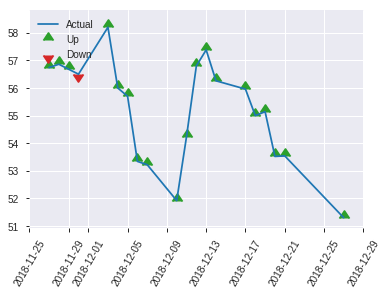


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2589624816253861
RMSE: 0.5088835639175097
LogLoss: 0.7120134192463482
Mean Per-Class Error: 0.42047619047619045
AUC: 0.5808163265306122
pr_auc: 0.4835895199059406
Gini: 0.16163265306122443
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43725192910494587: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      20   127  0.8639   (127.0/147.0)
1      7    93   0.07     (7.0/100.0)
Total  27   220  0.5425   (134.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.437252     0.58125   219
max f2                       0.272489     0.772798  246
max f0point5                 0.573924     0.5       109
max accuracy                 0.654506     0.635628  39
max precision                0.765941     1         0
max recall                   0.272489     1         246
max specificity              0.765941     1         0
max absolute_mcc             0.654506     0.197145  39
max min_per_class_accuracy   0.548081     0.557823  120
max mean_per_class_accuracy  0.573924     0.579524  109

Gains/Lift Table: Avg response rate: 40.49 %, avg score: 54.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.713952           1.64667   1.64667            0.666667         0.73609   0.666667                    0.73609             0.02            0.02                       64.6667   64.6667
    2        0.0202429                   0.701583           1.235     1.482              0.5              0.707737  0.6                         0.724749            0.01            0.03                       23.5      48.2
    3        0.0323887                   0.695679           0.823333  1.235              0.333333         0.699097  0.5                         0.715129            0.01            0.04                       -17.6667  23.5
    4        0.0404858                   0.69111            1.235     1.235              0.5              0.692144  0.5                         0.710532            0.01            0.05                       23.5      23.5
    5        0.0526316                   0.683038           0.823333  1.14               0.333333         0.688265  0.461538                    0.705394            0.01            0.06                       -17.6667  14
    6        0.101215                    0.667682           1.8525    1.482              0.75             0.674501  0.6                         0.690565            0.09            0.15                       85.25     48.2
    7        0.149798                    0.654868           1.44083   1.46865            0.583333         0.661557  0.594595                    0.681157            0.07            0.22                       44.0833   46.8649
    8        0.202429                    0.638093           1.14      1.3832             0.461538         0.647331  0.56                        0.672362            0.06            0.28                       14        38.32
    9        0.299595                    0.612343           1.02917   1.26838            0.416667         0.621972  0.513514                    0.65602             0.1             0.38                       2.91667   26.8378
    10       0.40081                     0.57982            0.8892    1.17263            0.36             0.593478  0.474747                    0.640226            0.09            0.47                       -11.08    17.2626
    11       0.502024                    0.546658           0.8892    1.11548            0.36             0.564558  0.451613                    0.624971            0.09            0.56                       -11.08    11.5484
    12       0.59919                     0.519619           0.92625   1.0848             0.375            0.534307  0.439189                    0.610268            0.09            0.65                       -7.375    8.47973
    13       0.700405                    0.496042           0.7904    1.04225            0.32             0.508076  0.421965                    0.595501            0.08            0.73                       -20.96    4.22543
    14       0.797571                    0.462801           0.92625   1.02812            0.375            0.477533  0.416244                    0.581129            0.09            0.82                       -7.375    2.81218
    15       0.898785                    0.434616           1.0868    1.03473            0.44             0.449292  0.418919                    0.566282            0.11            0.93                       8.68      3.47297
    16       1                           0.272489           0.6916    1                  0.28             0.396971  0.404858                    0.549146            0.07            

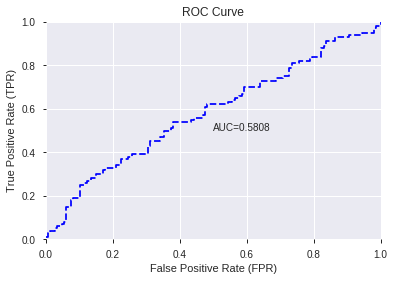

This function is available for GLM models only


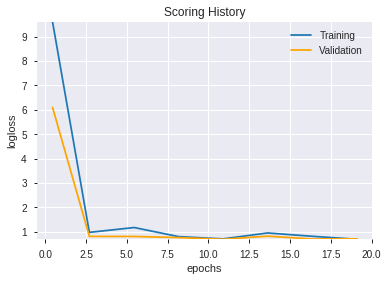

--2019-08-28 16:46:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  45.5MB/s    in 8.1s    

2019-08-28 16:47:06 (43.2 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_162157_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_162157_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a241',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_164716_model_1  0.597959  1.001419              0.473980  0.565936  0.320284
1  DeepLearning_grid_1_AutoML_20190828_164716_model_4  0.586871  0.860705              0.482993  0.519196  0.269564
2  DeepLearning_grid_1_AutoML_20190828_164716_model_7  0.585646  0.761652              0.461973  0.515631  0.265875
3  DeepLearning_grid_1_AutoML_20190828_164716_model_2  0.572245  0.892499              0.470986  0.533213  0.284316
4  DeepLearning_grid_1_AutoML_20190828_164716_model_3  0.562279  0.856339              0.482993  0.508646  0.258721
5  DeepLearning_grid_1_AutoML_20190828_164716_model_8  0.546871  0.686824              0.447755  0.496919  0.246928
6  DeepLearning_grid_1_AutoML_20190828_164716_model_6  0.538027  0.682659              0.476190  0.494863  0.244889
7  DeepLearning_grid_1_AutoML_20190828_164716_model_9  0.532653  0.687528              0.482789  0.497360  0.247367
8               DeepLearning_1_AutoML_20190828_164716  0.527483  0.858800              0.496599  0.558928  0.312400
9  DeepLearning_grid_1_AutoML_20190828_164716_model_5  0.503946  0.688417              0.489796  0.497287  0.247294

variable  relative_importance  scaled_importance  percentage
0     CDLLADDERBOTTOM             1.000000           1.000000    0.021176
1                 day             0.996263           0.996263    0.021097
2         CDLPIERCING             0.981811           0.981811    0.020791
3           dayofyear             0.980900           0.980900    0.020772
4           CDLONNECK             0.976233           0.976233    0.020673
5              SAREXT             0.974792           0.974792    0.020642
6             weekday             0.972887           0.972887    0.020602
7      CDLRICKSHAWMAN             0.971160           0.971160    0.020565
8      STOCHRSI_fastk             0.967636           0.967636    0.020491
9           dayofweek             0.966989           0.966989    0.020477
10          CORREL_24             0.966923           0.966923    0.020476
11  CDL3WHITESOLDIERS             0.966133           0.966133    0.020459
12            BETA_12             0.965166           0.965166    0.020439
13         weekofyear             0.962153           0.962153    0.020375
14               DX_8             0.960302           0.960302    0.020336
15                BOP             0.958440           0.958440    0.020296
16     CDL3BLACKCROWS             0.958137           0.958137    0.020290
17                COS             0.957443           0.957443    0.020275
18       STOCHF_fastk             0.955330           0.955330    0.020230
19        STOCH_slowd             0.954103           0.954103    0.020204
20     CDLSPINNINGTOP             0.953683           0.953683    0.020195
21               week             0.953550           0.953550    0.020193
22   CDLSTICKSANDWICH             0.952289           0.952289    0.020166
23     STOCHRSI_fastd             0.952069           0.952069    0.020161
24      days_in_month             0.950623           0.950623    0.020131
25  CDLLONGLEGGEDDOJI             0.949224           0.949224    0.020101
26          CDLINNECK             0.948583           0.948583    0.020087
27        AROONOSC_14             0.948110           0.948110    0.020077
28  CDLINVERTEDHAMMER             0.946380           0.946380    0.020041
29            BETA_24             0.945593           0.945593    0.020024
30        HT_DCPERIOD             0.944487           0.944487    0.020001
31              month             0.940857           0.940857    0.019924
32     CDLEVENINGSTAR             0.940353           0.940353    0.019913
33                OBV             0.937688           0.937688    0.019857
34      CDLHANGINGMAN             0.936035           0.936035    0.019822
35       weekday_name             0.933068           0.933068    0.019759
36     is_month_start             0.932783           0.932783    0.019753
37   CDLCOUNTERATTACK             0.931475           0.931475    0.019725
38        aroondown_8             0.928694           0.928694    0.019666
39                SIN             0.927838           0.927838    0.019648
40           CORREL_8             0.927450           0.927450    0.019640
41       aroondown_12             0.926597           0.926597    0.019622
42       aroondown_14             0.920079           0.920079    0.019484
43       HT_TRENDMODE             0.912612           0.912612    0.019326
44          CDLHAMMER             0.905093           0.905093    0.019166
45            quarter             0.901327           0.901327    0.019087
46             BETA_8             0.881346           0.881346    0.018664
47  CDLSTALLEDPATTERN             0.880899           0.880899    0.018654
48            CDLDOJI             0.869064           0.869064    0.018404
49            BETA_20             0.852118           0.852118    0.018045

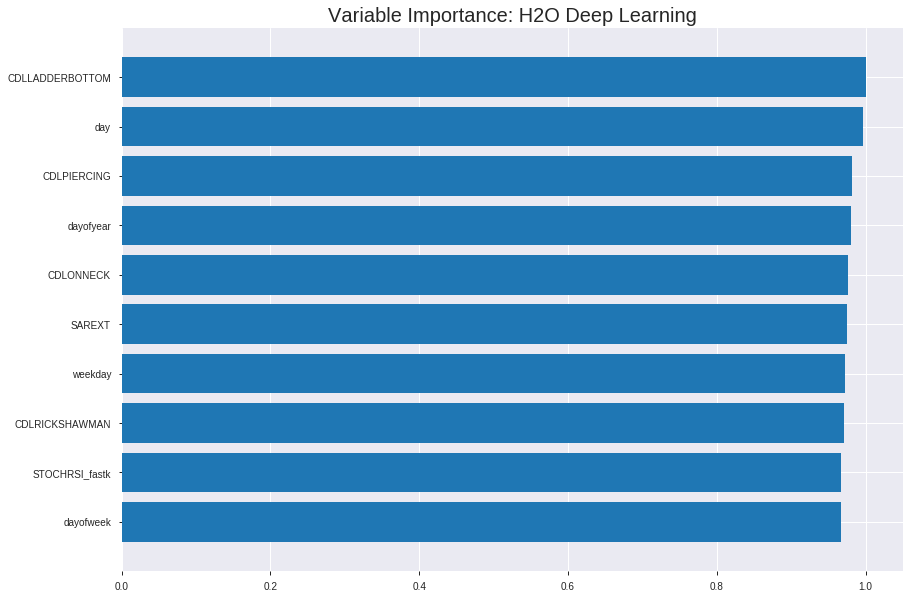

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_164716_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.3108368658626257
RMSE: 0.5575274574966024
LogLoss: 1.0685047781251347
Mean Per-Class Error: 0.4021757040795959
AUC: 0.6197039134808987
pr_auc: 0.5888259759431459
Gini: 0.2394078269617974
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11965973525143357: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      152  707   0.8231   (707.0/859.0)
1      56   813   0.0644   (56.0/869.0)
Total  208  1520  0.4416   (763.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.11966      0.68062   350
max f2                       0.0101279    0.835428  394
max f0point5                 0.753833     0.59986   137
max accuracy                 0.753833     0.597801  137
max precision                0.999859     0.666667  0
max recall                   0.000198471  1         399
max specificity              0.999859     0.994179  0
max absolute_mcc             0.838311     0.195701  99
max min_per_class_accuracy   0.750581     0.594937  138
max mean_per_class_accuracy  0.753833     0.597824  137

Gains/Lift Table: Avg response rate: 50.29 %, avg score: 63.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.998935           1.32566   1.32566            0.666667         0.999734   0.666667                    0.999734            0.013809        0.013809                   32.5662   32.5662
    2        0.0202546                   0.998027           1.05273   1.1931             0.529412         0.998444   0.6                         0.999107            0.0103567       0.0241657                  5.27313   19.3096
    3        0.0300926                   0.996162           1.28667   1.22369            0.647059         0.996868   0.615385                    0.998375            0.0126582       0.0368239                  28.6672   22.3688
    4        0.0405093                   0.995349           1.54661   1.30672            0.777778         0.995807   0.657143                    0.997715            0.0161105       0.0529344                  54.6605   30.6724
    5        0.0503472                   0.994258           1.1697    1.27995            0.588235         0.99478    0.643678                    0.997141            0.0115075       0.0644419                  16.9701   27.9949
    6        0.100116                    0.984638           1.31795   1.29884            0.662791         0.989343   0.653179                    0.993265            0.0655926       0.130035                   31.7954   29.8842
    7        0.150463                    0.973908           1.23424   1.27722            0.62069          0.97986    0.642308                    0.988779            0.0621404       0.192175                   23.4237   27.7224
    8        0.200231                    0.96174            1.27171   1.27585            0.639535         0.967614   0.641618                    0.983519            0.0632911       0.255466                   27.171    27.5854
    9        0.300347                    0.916947           1.09195   1.21455            0.549133         0.94049    0.61079                     0.969176            0.109321        0.364787                   9.19468   21.4551
    10       0.399884                    0.848933           1.26015   1.2259             0.633721         0.885537   0.616498                    0.948357            0.125432        0.490219                   26.0149   22.5901
    11       0.5                         0.749373           1.04597   1.18987            0.526012         0.802862   0.59838                     0.919224            0.104718        0.594937                   4.59701   18.9873
    12       0.600116                    0.611273           0.896546  1.14094            0.450867         0.687458   0.57377                     0.880559            0.0897583       0.684695                   -10.3454  14.0938
    13       0.699653                    0.446443           0.843953  1.09869            0.424419         0.531357   0.552523                    0.83088             0.0840046       0.7687                     -15.6047  9.86873
    14       0.799769                    0.255693           0.965511  1.08202            0.485549         0.353285   0.544139                    0.771094            0.0966628       0.865362                   -3.44892  8.20162
    15       0.899884                    0.0903332          0.804592  1.05115            0.404624         0.170436   0.528617                    0.704268            0.0805524       0.945915                   -19.5408  5.11517
    16       1                           3.62347e-09        0.540226  1                  0.271676         0.0368628  0.502894                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.34555535006818444
RMSE: 0.5878395615031234
LogLoss: 1.1681357292081638
Mean Per-Class Error: 0.4755284926470589
AUC: 0.4938780199579832
pr_auc: 0.5011550364940507
Gini: -0.012243960084033612
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00020433110084874898: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    238  1        (238.0/238.0)
1      0    256  0        (0.0/256.0)
Total  0    494  0.4818   (238.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000204331  0.682667  399
max f2                       0.000204331  0.843215  399
max f0point5                 0.0887618    0.574388  378
max accuracy                 0.646438     0.524291  186
max precision                0.646438     0.542857  186
max recall                   0.000204331  1         399
max specificity              0.999934     0.983193  0
max absolute_mcc             0.996919     0.100967  3
max min_per_class_accuracy   0.643609     0.523438  188
max mean_per_class_accuracy  0.646438     0.524472  186

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 60.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.999212           0.385938  0.385938           0.2              0.999934   0.2                         0.999934            0.00390625      0.00390625                 -61.4062  -61.4062
    2        0.0202429                   0.992872           0.771875  0.578906           0.4              0.996418   0.3                         0.998176            0.0078125       0.0117188                  -22.8125  -42.1094
    3        0.0303644                   0.986338           1.15781   0.771875           0.6              0.990155   0.4                         0.995502            0.0117188       0.0234375                  15.7812   -22.8125
    4        0.0404858                   0.980854           0.771875  0.771875           0.4              0.984489   0.4                         0.992749            0.0078125       0.03125                    -22.8125  -22.8125
    5        0.0506073                   0.975815           1.54375   0.92625            0.8              0.978287   0.48                        0.989857            0.015625        0.046875                   54.375    -7.375
    6        0.101215                    0.956038           1.00344   0.964844           0.52             0.965322   0.5                         0.977589            0.0507812       0.0976562                  0.34375   -3.51562
    7        0.149798                    0.933333           0.88444   0.938767           0.458333         0.946322   0.486486                    0.967448            0.0429688       0.140625                   -11.556   -6.12331
    8        0.200405                    0.907464           1.08063   0.97459            0.56             0.922218   0.505051                    0.956027            0.0546875       0.195312                   8.0625    -2.54104
    9        0.299595                    0.838659           0.827009  0.925728           0.428571         0.875444   0.47973                     0.929347            0.0820312       0.277344                   -17.2991  -7.42715
    10       0.40081                     0.742116           1.08063   0.964844           0.56             0.788237   0.5                         0.893713            0.109375        0.386719                   8.0625    -3.51562
    11       0.5                         0.642569           1.37835   1.04688            0.714286         0.694906   0.54251                     0.854274            0.136719        0.523438                   37.8348   4.6875
    12       0.59919                     0.541923           0.827009  1.01048            0.428571         0.586994   0.523649                    0.810028            0.0820312       0.605469                   -17.2991  1.04783
    13       0.700405                    0.43359            0.92625   0.998307           0.48             0.485523   0.517341                    0.763134            0.09375         0.699219                   -7.375    -0.169346
    14       0.799595                    0.288215           0.905772  0.986828           0.469388         0.358911   0.511392                    0.71299             0.0898438       0.789062                   -9.42283  -1.31725
    15       0.898785                    0.158301           1.14206   1.00396            0.591837         0.223042   0.52027                     0.658919            0.113281        0.902344                   14.206    0.395904
    16       1                           7.86828e-06        0.964844  1                  0.5              0.0765225  0.518219        


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:47:17  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 16:47:22  4.738 sec   2271 obs/sec      6         1             10368      0.557527         1.0685              -0.243389      0.619704        0.588826           1.32566          0.441551                         0.58784            1.16814               -0.384059        0.493878          0.501155             0.385938           0.481781
    2019-08-28 16:47:29  11.849 sec  2690 obs/sec      18        3             31104      0.52771          0.934126            -0.113948      0.687225        0.655131           1.65708          0.379051                         0.607796           1.44185               -0.479627        0.521214          0.525207             0.385938           0.469636
    2019-08-28 16:47:36  19.085 sec  2774 obs/sec      30        5             51840      0.490811         0.832357            0.0363848      0.748584        0.702471           1.32566          0.328125                         0.602311           1.46158               -0.453045        0.507706          0.513115             0.771875           0.475709
    2019-08-28 16:47:42  25.410 sec  2914 obs/sec      42        7             72576      0.469541         0.755307            0.118097       0.770562        0.736289           1.54661          0.322917                         0.603247           1.54361               -0.457565        0.518415          0.517911             0.385938           0.481781
    2019-08-28 16:47:48  31.598 sec  3011 obs/sec      54        9             93312      0.428993         0.591282            0.263837       0.819379        0.787675           1.87802          0.269097                         0.595429           1.5721                -0.420026        0.512022          0.530437             0.385938           0.481781
    2019-08-28 16:47:55  37.689 sec  3084 obs/sec      66        11            114048     0.414622         0.567855            0.312332       0.849519        0.81166            1.54661          0.242477                         0.600501           1.61768               -0.444322        0.50819           0.516212             0.385938           0.481781
    2019-08-28 16:47:55  37.863 sec  3082 obs/sec      66        11            114048     0.557527         1.0685              -0.243389      0.619704        0.588826           1.32566          0.441551                         0.58784            1.16814               -0.384059        0.493878          0.501155             0.385938           0.481781

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLLADDERBOTTOM    1.0                    1.0                  0.021176226264644216
day                0.9962626099586487     0.9962626099586487   0.02109708244748933
CDLPIERCING        0.9818114042282104     0.9818114042282104   0.020791060445144647
dayofyear          0.9809003472328186     0.9809003472328186   0.020771767696070243
CDLONNECK          0.9762327075004578     0.9762327075004578   0.020672924700975925
---                ---                    ---                  ---
quarter            0.9013273119926453     0.9013273119926453   0.019086711097259824
BETA_8             0.8813462853431702     0.8813462853431702   0.018663588355930655
CDLSTALLEDPATTERN  0.880898654460907      0.880898654460907    0.018654109223084806
CDLDOJI            0.869064211845398      0.869064211845398    0.01840350038854284
BETA_20            0.8521175980567932     0.8521175980567932   0.018044635060535805


See the whole table with table.as_data_frame()


('accuracy', 0.6477732793522267)

('F1', 0.581039755351682)

('auc', 0.5979591836734695)

('logloss', 1.0014185096263082)

('mean_per_class_error', 0.41261904761904766)

('rmse', 0.5659361413235875)

('mse', 0.32028371605623157)

deeplearning prediction progress: |███████████████████████████████████████| 100%


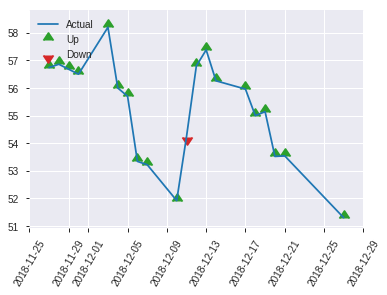


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.32028371605623157
RMSE: 0.5659361413235875
LogLoss: 1.0014185096263082
Mean Per-Class Error: 0.41261904761904766
AUC: 0.5979591836734695
pr_auc: 0.5227728334981417
Gini: 0.1959183673469389
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03638286590272989: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   132  0.898    (132.0/147.0)
1      5    95   0.05     (5.0/100.0)
Total  20   227  0.5547   (137.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0363829    0.58104   226
max f2                       7.04448e-05  0.772798  246
max f0point5                 0.910055     0.511364  40
max accuracy                 0.910055     0.647773  40
max precision                0.999993     1         0
max recall                   7.04448e-05  1         246
max specificity              0.999993     1         0
max absolute_mcc             0.910055     0.230558  40
max min_per_class_accuracy   0.624333     0.55102   121
max mean_per_class_accuracy  0.910055     0.587381  40

Gains/Lift Table: Avg response rate: 40.49 %, avg score: 53.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.993367           1.64667   1.64667            0.666667         0.996546   0.666667                    0.996546            0.02            0.02                       64.6667   64.6667
    2        0.0202429                   0.982233           2.47      1.976              1                0.989304   0.8                         0.993649            0.02            0.04                       147       97.6
    3        0.0323887                   0.980713           2.47      2.16125            1                0.981455   0.875                       0.989076            0.03            0.07                       147       116.125
    4        0.0404858                   0.973463           1.235     1.976              0.5              0.978466   0.8                         0.986954            0.01            0.08                       23.5      97.6
    5        0.0526316                   0.968537           1.64667   1.9                0.666667         0.970344   0.769231                    0.983121            0.02            0.1                        64.6667   90
    6        0.101215                    0.950843           1.235     1.5808             0.5              0.957989   0.64                        0.971058            0.06            0.16                       23.5      58.08
    7        0.149798                    0.917898           1.44083   1.53541            0.583333         0.932744   0.621622                    0.958632            0.07            0.23                       44.0833   53.5405
    8        0.202429                    0.884379           1.33      1.482              0.538462         0.898508   0.6                         0.943               0.07            0.3                        33        48.2
    9        0.299595                    0.791869           0.823333  1.26838            0.333333         0.838078   0.513514                    0.908971            0.08            0.38                       -17.6667  26.8378
    10       0.40081                     0.713197           0.988     1.19758            0.4              0.760459   0.484848                    0.871468            0.1             0.48                       -1.2      19.7576
    11       0.502024                    0.618851           0.8892    1.1354             0.36             0.670463   0.459677                    0.830943            0.09            0.57                       -11.08    13.5403
    12       0.59919                     0.400561           1.02917   1.11818            0.416667         0.523617   0.452703                    0.781106            0.1             0.67                       2.91667   11.8176
    13       0.700405                    0.246336           0.988     1.09936            0.4              0.332213   0.445087                    0.716237            0.1             0.77                       -1.2      9.93642
    14       0.797571                    0.124973           0.720417  1.0532             0.291667         0.184246   0.426396                    0.651426            0.07            0.84                       -27.9583  5.3198
    15       0.898785                    0.0521588          0.7904    1.0236             0.32             0.0901173  0.414414                    0.588216            0.08            0.92                       -20.96    2.36036
    16       1                           7.04448e-05        0.7904    1                  0.32             0.024067   0.404858                    0.531116        

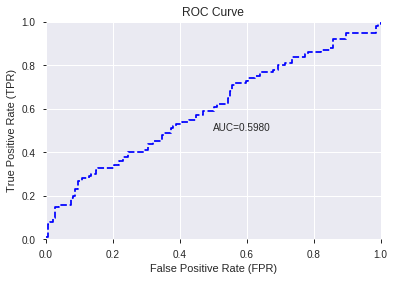

This function is available for GLM models only


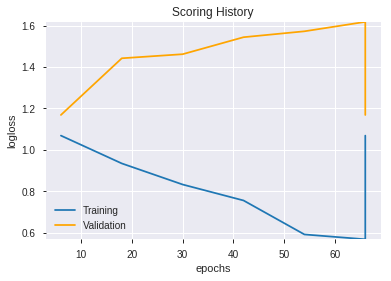

--2019-08-28 16:54:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.212
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.212|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_164716_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_164716_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a241',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLLADDERBOTTOM',
 'day',
 'CDLPIERCING',
 'dayofyear',
 'CDLONNECK',
 'SAREXT',
 'weekday',
 'CDLRICKSHAWMAN',
 'STOCHRSI_fastk',
 'dayofweek',
 'CORREL_24',
 'CDL3WHITESOLDIERS',
 'BETA_12',
 'weekofyear',
 'DX_8',
 'BOP',
 'CDL3BLACKCROWS',
 'COS',
 'STOCHF_fastk',
 'STOCH_slowd',
 'CDLSPINNINGTOP',
 'week',
 'CDLSTICKSANDWICH',
 'STOCHRSI_fastd',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'CDLINNECK',
 'AROONOSC_14',
 'CDLINVERTEDHAMMER',
 'BETA_24',
 'HT_DCPERIOD',
 'month',
 'CDLEVENINGSTAR',
 'OBV',
 'CDLHANGINGMAN',
 'weekday_name',
 'is_month_start',
 'CDLCOUNTERATTACK',
 'aroondown_8',
 'SIN',
 'CORREL_8',
 'aroondown_12',
 'aroondown_14',
 'HT_TRENDMODE',
 'CDLHAMMER',
 'quarter',
 'BETA_8',
 'CDLSTALLEDPATTERN',
 'CDLDOJI',
 'BETA_20']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_165422_model_1  0.527619  0.692805              0.453367  0.499827  0.249827

variable  relative_importance  scaled_importance  percentage
0                 BOP             0.008850           1.000000    0.060778
1                 OBV             0.008812           0.995724    0.060518
2   CDLINVERTEDHAMMER             0.007375           0.833328    0.050648
3        STOCHF_fastk             0.007187           0.812078    0.049356
4           CDLHAMMER             0.006739           0.761519    0.046283
5      STOCHRSI_fastk             0.005978           0.675462    0.041053
6        HT_TRENDMODE             0.005632           0.636448    0.038682
7           CORREL_24             0.005291           0.597899    0.036339
8                DX_8             0.004985           0.563279    0.034235
9              BETA_8             0.004331           0.489412    0.029745
10          CDLINNECK             0.004258           0.481129    0.029242
11     is_month_start             0.004197           0.474259    0.028824
12            BETA_24             0.004170           0.471222    0.028640
13  CDLSTALLEDPATTERN             0.004168           0.471029    0.028628
14               week             0.003701           0.418195    0.025417
15         weekofyear             0.003697           0.417738    0.025389
16       aroondown_12             0.003611           0.408010    0.024798
17            quarter             0.003457           0.390673    0.023744
18     CDLEVENINGSTAR             0.003379           0.381798    0.023205
19            BETA_20             0.003304           0.373327    0.022690
20       aroondown_14             0.003169           0.358077    0.021763
21  CDL3WHITESOLDIERS             0.003092           0.349339    0.021232
22          dayofyear             0.002931           0.331145    0.020126
23          CDLONNECK             0.002923           0.330248    0.020072
24              month             0.002739           0.309542    0.018813
25     CDLRICKSHAWMAN             0.002650           0.299401    0.018197
26  CDLLONGLEGGEDDOJI             0.002186           0.247005    0.015012
27                day             0.002080           0.235011    0.014283
28            CDLDOJI             0.001942           0.219406    0.013335
29    CDLLADDERBOTTOM             0.001855           0.209607    0.012739
30   CDLSTICKSANDWICH             0.001841           0.208046    0.012645
31                SIN             0.001817           0.205318    0.012479
32                COS             0.001774           0.200512    0.012187
33        STOCH_slowd             0.001760           0.198837    0.012085
34     CDLSPINNINGTOP             0.001543           0.174364    0.010597
35        AROONOSC_14             0.001442           0.162918    0.009902
36      CDLHANGINGMAN             0.001225           0.138463    0.008415
37        HT_DCPERIOD             0.001218           0.137643    0.008366
38     STOCHRSI_fastd             0.001208           0.136489    0.008295
39      days_in_month             0.000998           0.112754    0.006853
40            BETA_12             0.000525           0.059339    0.003606
41             SAREXT             0.000394           0.044489    0.002704
42        aroondown_8             0.000324           0.036650    0.002227
43       weekday_name             0.000264           0.029786    0.001810
44           CORREL_8             0.000224           0.025298    0.001538
45          dayofweek             0.000121           0.013650    0.000830
46            weekday             0.000117           0.013187    0.000801
47        CDLPIERCING             0.000099           0.011219    0.000682
48     CDL3BLACKCROWS             0.000028           0.003129    0.000190
49   CDLCOUNTERATTACK             0.000000           0.000000    0.000000

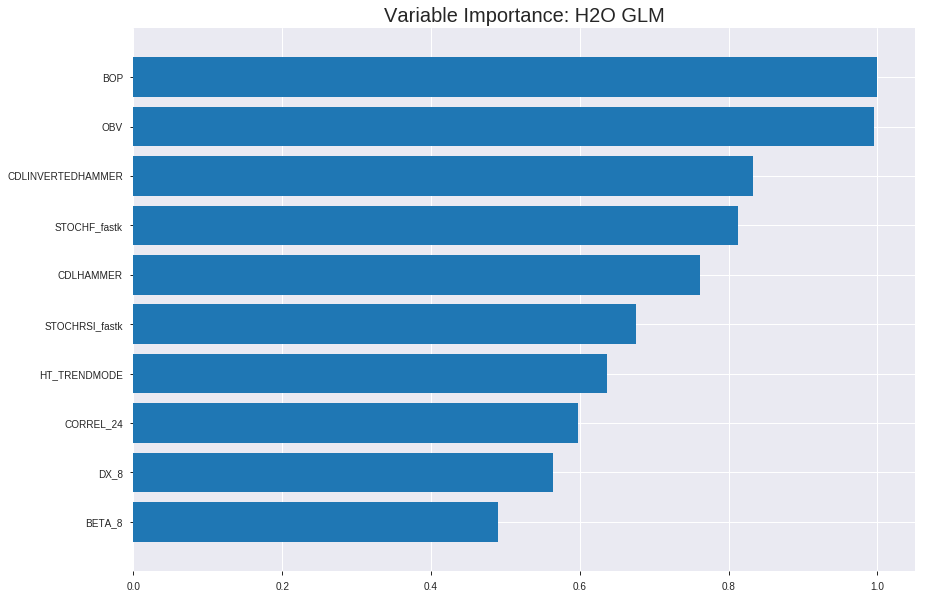

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_165422_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24864494628979833
RMSE: 0.4986431051260995
LogLoss: 0.690435805767128
Null degrees of freedom: 1727
Residual degrees of freedom: 1678
Null deviance: 2395.458785321781
Residual deviance: 2386.1461447311945
AIC: 2486.1461447311945
AUC: 0.5880282020333006
pr_auc: 0.5955668992093477
Gini: 0.17605640406660128
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48373888920084185: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      25   834   0.9709   (834.0/859.0)
1      8    861   0.0092   (8.0/869.0)
Total  33   1695  0.4873   (842.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483739     0.671607  377
max f2                       0.469939     0.834935  399
max f0point5                 0.499946     0.576813  229
max accuracy                 0.503563     0.568287  184
max precision                0.550557     1         0
max recall                   0.469939     1         399
max specificity              0.550557     1         0
max absolute_mcc             0.51229      0.148972  75
max min_per_class_accuracy   0.503219     0.568102  189
max mean_per_class_accuracy  0.503563     0.5684    184

Gains/Lift Table: Avg response rate: 50.29 %, avg score: 50.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.520038           1.76755   1.76755            0.888889         0.526475  0.888889                    0.526475            0.018412        0.018412                   76.7549   76.7549
    2        0.0202546                   0.518805           1.52061   1.64761            0.764706         0.519445  0.828571                    0.523061            0.0149597       0.0333717                  52.0612   64.7608
    3        0.0300926                   0.517756           1.28667   1.52961            0.647059         0.518276  0.769231                    0.521497            0.0126582       0.0460299                  28.6672   52.961
    4        0.0405093                   0.516792           1.32566   1.47717            0.666667         0.517234  0.742857                    0.520401            0.013809        0.0598389                  32.5662   47.7166
    5        0.0503472                   0.51608            1.40364   1.4628             0.705882         0.516381  0.735632                    0.519615            0.013809        0.0736479                  40.3642   46.2799
    6        0.100116                    0.513983           1.31795   1.3908             0.662791         0.515134  0.699422                    0.517388            0.0655926       0.139241                   31.7954   39.0795
    7        0.150463                    0.512033           1.25709   1.34606            0.632184         0.513009  0.676923                    0.515922            0.0632911       0.202532                   25.7093   34.6056
    8        0.200231                    0.510258           0.901758  1.23562            0.453488         0.51104   0.621387                    0.514709            0.0448792       0.247411                   -9.82418  23.5624
    9        0.300347                    0.507555           1.02298   1.16474            0.514451         0.508826  0.585742                    0.512748            0.102417        0.349827                   2.29817   16.4743
    10       0.399884                    0.505486           0.982685  1.11943            0.494186         0.506569  0.562952                    0.51121             0.0978136       0.447641                   -1.73147  11.9426
    11       0.5                         0.503202           1.20689   1.13694            0.606936         0.504315  0.571759                    0.509829            0.120829        0.56847                    20.6889   13.6939
    12       0.600116                    0.500851           0.90804   1.09875            0.456647         0.502002  0.552555                    0.508523            0.0909091       0.659379                   -9.19601  9.87524
    13       0.699653                    0.498698           0.855514  1.06415            0.430233         0.499685  0.535153                    0.507266            0.0851554       0.744534                   -14.4486  6.41478
    14       0.799769                    0.49587            0.965511  1.0518             0.485549         0.497281  0.528944                    0.506016            0.0966628       0.841197                   -3.44892  5.18003
    15       0.899884                    0.49148            0.896546  1.03453            0.450867         0.493962  0.520257                    0.504675            0.0897583       0.930955                   -10.3454  3.45276
    16       1                           0.469939           0.689651  1                  0.346821         0.48688   0.502894                    0.502894          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24990942284535422
RMSE: 0.4999094146396467
LogLoss: 0.6929668579862626
Null degrees of freedom: 493
Residual degrees of freedom: 444
Null deviance: 684.6376229712456
Residual deviance: 684.6512556904274
AIC: 784.6512556904274
AUC: 0.5049812893907563
pr_auc: 0.5123648078452313
Gini: 0.009962578781512521
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48178256141857334: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    233  0.979    (233.0/238.0)
1      2    254  0.0078   (2.0/256.0)
Total  7    487  0.4757   (235.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.481783     0.683715   392
max f2                       0.469422     0.843215   399
max f0point5                 0.494691     0.582474   331
max accuracy                 0.494727     0.544534   330
max precision                0.515063     0.583333   21
max recall                   0.469422     1          399
max specificity              0.546332     0.995798   0
max absolute_mcc             0.517826     0.0900643  6
max min_per_class_accuracy   0.503769     0.492188   195
max mean_per_class_accuracy  0.494727     0.53189    330

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 50.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.518662           0.385938  0.385938           0.2              0.535891  0.2                         0.535891            0.00390625      0.00390625                 -61.4062  -61.4062
    2        0.0202429                   0.517405           0.771875  0.578906           0.4              0.517733  0.3                         0.526812            0.0078125       0.0117188                  -22.8125  -42.1094
    3        0.0303644                   0.516317           1.54375   0.900521           0.8              0.517116  0.466667                    0.52358             0.015625        0.0273438                  54.375    -9.94792
    4        0.0404858                   0.515421           1.54375   1.06133            0.8              0.515959  0.55                        0.521675            0.015625        0.0429688                  54.375    6.13281
    5        0.0506073                   0.514899           1.15781   1.08063            0.6              0.51514   0.56                        0.520368            0.0117188       0.0546875                  15.7812   8.0625
    6        0.101215                    0.512855           0.92625   1.00344            0.48             0.513696  0.52                        0.517032            0.046875        0.101562                   -7.375    0.34375
    7        0.149798                    0.511569           0.88444   0.964844           0.458333         0.512214  0.5                         0.515469            0.0429688       0.144531                   -11.556   -3.51562
    8        0.200405                    0.510017           1.08063   0.994081           0.56             0.510855  0.515152                    0.514304            0.0546875       0.199219                   8.0625    -0.591856
    9        0.299595                    0.507678           0.945153  0.977882           0.489796         0.508896  0.506757                    0.512513            0.09375         0.292969                   -5.48469  -2.21178
    10       0.40081                     0.505553           1.04203   0.994081           0.54             0.506593  0.515152                    0.511018            0.105469        0.398438                   4.20312   -0.591856
    11       0.5                         0.50372            0.945153  0.984375           0.489796         0.504704  0.510121                    0.509766            0.09375         0.492188                   -5.48469  -1.5625
    12       0.59919                     0.50166            0.984534  0.984401           0.510204         0.502563  0.510135                    0.508573            0.0976562       0.589844                   -1.54656  -1.55986
    13       0.700405                    0.499516           1.19641   1.01504            0.62             0.500547  0.526012                    0.507414            0.121094        0.710938                   19.6406   1.50379
    14       0.799595                    0.496765           1.10268   1.02591            0.571429         0.498327  0.531646                    0.506286            0.109375        0.820312                   10.2679   2.59098
    15       0.898785                    0.492853           0.905772  1.01265            0.469388         0.494749  0.524775                    0.505013            0.0898438       0.910156                   -9.42283  1.26513
    16       1                           0.469422           0.887656  1                  0.46             0.487846  0.518219                    0.503276


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 16:54:23  0.000 sec   2            3.7       50            1.38087           1.38593
    2019-08-28 16:54:23  0.087 sec   4            2.3       50            1.37831           1.38626
    2019-08-28 16:54:23  0.125 sec   6            1.4       50            1.37492           1.38706
    2019-08-28 16:54:23  0.159 sec   8            0.89      51            1.37072           1.38868
    2019-08-28 16:54:23  0.189 sec   10           0.55      51            1.3659            1.39161

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6396761133603239)

('F1', 0.5886075949367089)

('auc', 0.5276190476190477)

('logloss', 0.6928053902309971)

('mean_per_class_error', 0.4340136054421768)

('rmse', 0.4998273743333595)

('mse', 0.24982740413298027)

glm prediction progress: |████████████████████████████████████████████████| 100%


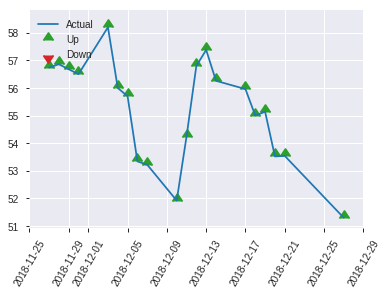


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24982740413298027
RMSE: 0.4998273743333595
LogLoss: 0.6928053902309971
Null degrees of freedom: 246
Residual degrees of freedom: 197
Null deviance: 342.9669668693666
Residual deviance: 342.2458627741125
AIC: 442.2458627741125
AUC: 0.5276190476190477
pr_auc: 0.46970027591799207
Gini: 0.05523809523809531
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49139248175474354: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      24   123  0.8367   (123.0/147.0)
1      7    93   0.07     (7.0/100.0)
Total  31   216  0.5263   (130.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.491392     0.588608  215
max f2                       0.485118     0.775862  237
max f0point5                 0.491392     0.482365  215
max accuracy                 0.514301     0.639676  18
max precision                0.517164     0.8       4
max recall                   0.482324     1         244
max specificity              0.574375     0.993197  0
max absolute_mcc             0.514301     0.22619   18
max min_per_class_accuracy   0.501866     0.48      123
max mean_per_class_accuracy  0.511748     0.565986  29

Gains/Lift Table: Avg response rate: 40.49 %, avg score: 50.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.518748           1.64667   1.64667            0.666667         0.546054  0.666667                    0.546054            0.02            0.02                       64.6667   64.6667
    2        0.0202429                   0.517158           2.47      1.976              1                0.517424  0.8                         0.534602            0.02            0.04                       147       97.6
    3        0.0323887                   0.515836           1.64667   1.8525             0.666667         0.516344  0.75                        0.527755            0.02            0.06                       64.6667   85.25
    4        0.0404858                   0.515735           1.235     1.729              0.5              0.51582   0.7                         0.525368            0.01            0.07                       23.5      72.9
    5        0.0526316                   0.515327           1.64667   1.71               0.666667         0.515595  0.692308                    0.523113            0.02            0.09                       64.6667   71
    6        0.101215                    0.512119           1.44083   1.5808             0.583333         0.51374   0.64                        0.518614            0.07            0.16                       44.0833   58.08
    7        0.149798                    0.51071            1.235     1.46865            0.5              0.511466  0.594595                    0.516296            0.06            0.22                       23.5      46.8649
    8        0.202429                    0.509005           0.38      1.1856             0.153846         0.509655  0.48                        0.514569            0.02            0.24                       -62       18.56
    9        0.299595                    0.506388           0.720417  1.03473            0.291667         0.507722  0.418919                    0.512348            0.07            0.31                       -27.9583  3.47297
    10       0.40081                     0.503947           1.0868    1.04788            0.44             0.505259  0.424242                    0.510558            0.11            0.42                       8.68      4.78788
    11       0.502024                    0.501866           0.5928    0.956129           0.24             0.502852  0.387097                    0.509005            0.06            0.48                       -40.72    -4.3871
    12       0.59919                     0.4994             1.235     1.00135            0.5              0.500309  0.405405                    0.507594            0.12            0.6                        23.5      0.135135
    13       0.700405                    0.497155           0.8892    0.985145           0.36             0.498237  0.398844                    0.506242            0.09            0.69                       -11.08    -1.48555
    14       0.797571                    0.494443           1.33792   1.02812            0.541667         0.495791  0.416244                    0.504969            0.13            0.82                       33.7917   2.81218
    15       0.898785                    0.490517           1.1856    1.04586            0.48             0.492666  0.423423                    0.503583            0.12            0.94                       18.56     4.58559
    16       1                           0.476404           0.5928    1                  0.24             0.485835  0.404858                    0.501787            0.06        

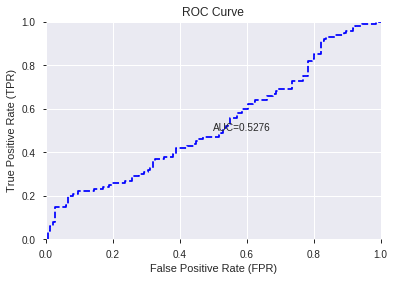

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


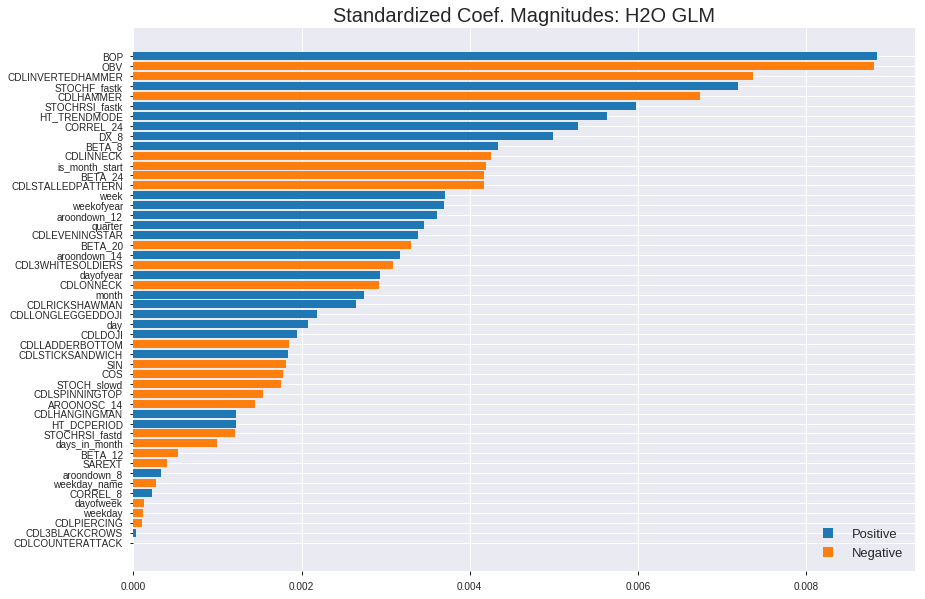

'log_likelihood'
--2019-08-28 16:54:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_165422_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_165422_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a241',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'OBV',
 'CDLINVERTEDHAMMER',
 'STOCHF_fastk',
 'CDLHAMMER',
 'STOCHRSI_fastk',
 'HT_TRENDMODE',
 'CORREL_24',
 'DX_8',
 'BETA_8',
 'CDLINNECK',
 'is_month_start',
 'BETA_24',
 'CDLSTALLEDPATTERN',
 'week',
 'weekofyear',
 'aroondown_12',
 'quarter',
 'CDLEVENINGSTAR',
 'BETA_20',
 'aroondown_14',
 'CDL3WHITESOLDIERS',
 'dayofyear',
 'CDLONNECK',
 'month',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'day',
 'CDLDOJI',
 'CDLLADDERBOTTOM',
 'CDLSTICKSANDWICH',
 'SIN',
 'COS',
 'STOCH_slowd',
 'CDLSPINNINGTOP',
 'AROONOSC_14',
 'CDLHANGINGMAN',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'days_in_month',
 'BETA_12',
 'SAREXT',
 'aroondown_8',
 'weekday_name',
 'CORREL_8',
 'dayofweek',
 'weekday',
 'CDLPIERCING',
 'CDL3BLACKCROWS',
 'CDLCOUNTERATTACK']

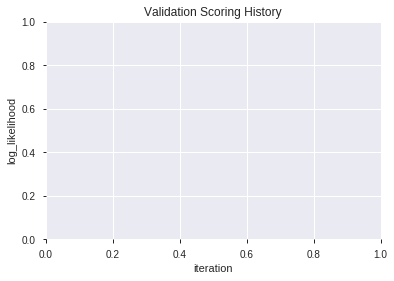

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_165437_model_3  0.603605  0.670283              0.469184  0.488618  0.238748
1               XGBoost_2_AutoML_20190828_165437  0.582789  0.676760              0.500000  0.491720  0.241788
2  XGBoost_grid_1_AutoML_20190828_165437_model_4  0.577143  0.678971              0.481190  0.492898  0.242949
3               XGBoost_1_AutoML_20190828_165437  0.572381  0.682995              0.500000  0.494478  0.244509
4  XGBoost_grid_1_AutoML_20190828_165437_model_2  0.566599  0.681842              0.500000  0.494250  0.244283
5  XGBoost_grid_1_AutoML_20190828_165437_model_6  0.559864  0.685549              0.439150  0.496136  0.246151
6               XGBoost_3_AutoML_20190828_165437  0.555442  0.680922              0.486395  0.493937  0.243974
7  XGBoost_grid_1_AutoML_20190828_165437_model_7  0.549524  0.693146              0.470782  0.499818  0.249818
8  XGBoost_grid_1_AutoML_20190828_165437_model_5  0.547755  0.697548              0.493197  0.501325  0.251327
9  XGBoost_grid_1_AutoML_20190828_165437_model_1  0.539116  0.691914              0.496599  0.499252  0.249252

variable  relative_importance  scaled_importance  percentage
0                 OBV           358.950775           1.000000    0.073153
1                 BOP           279.315613           0.778145    0.056924
2        STOCHF_fastk           273.389709           0.761636    0.055716
3            CORREL_8           270.390259           0.753279    0.055105
4              BETA_8           268.880798           0.749074    0.054797
5             BETA_24           249.240234           0.694358    0.050795
6           CORREL_24           246.334518           0.686263    0.050202
7                 COS           245.759766           0.684661    0.050085
8           dayofyear           241.426407           0.672589    0.049202
9         STOCH_slowd           233.106293           0.649410    0.047507
10     STOCHRSI_fastd           194.280243           0.541245    0.039594
11        HT_DCPERIOD           193.438583           0.538900    0.039422
12            BETA_12           188.532745           0.525233    0.038423
13               DX_8           175.474930           0.488855    0.035761
14                SIN           168.155273           0.468463    0.034270
15             SAREXT           166.500977           0.463855    0.033933
16                day           155.753815           0.433914    0.031742
17            BETA_20           136.973007           0.381593    0.027915
18        AROONOSC_14           118.717690           0.330735    0.024194
19               week           106.701637           0.297260    0.021746
20       aroondown_12           102.993484           0.286929    0.020990
21       aroondown_14           102.692268           0.286090    0.020928
22        aroondown_8            77.047493           0.214646    0.015702
23     STOCHRSI_fastk            72.152267           0.201009    0.014704
24          dayofweek            65.270035           0.181836    0.013302
25       weekday_name            62.711430           0.174708    0.012780
26     CDLSPINNINGTOP            23.973766           0.066788    0.004886
27      days_in_month            23.143698           0.064476    0.004717
28         weekofyear            22.873304           0.063723    0.004662
29            weekday            20.928436           0.058304    0.004265
30            CDLDOJI            18.448669           0.051396    0.003760
31     CDLRICKSHAWMAN            13.601381           0.037892    0.002772
32          CDLHAMMER            11.810403           0.032903    0.002407
33              month             6.289310           0.017521    0.001282
34  CDLINVERTEDHAMMER             5.131526           0.014296    0.001046
35       HT_TRENDMODE             4.198635           0.011697    0.000856
36            quarter             2.239510           0.006239    0.000456

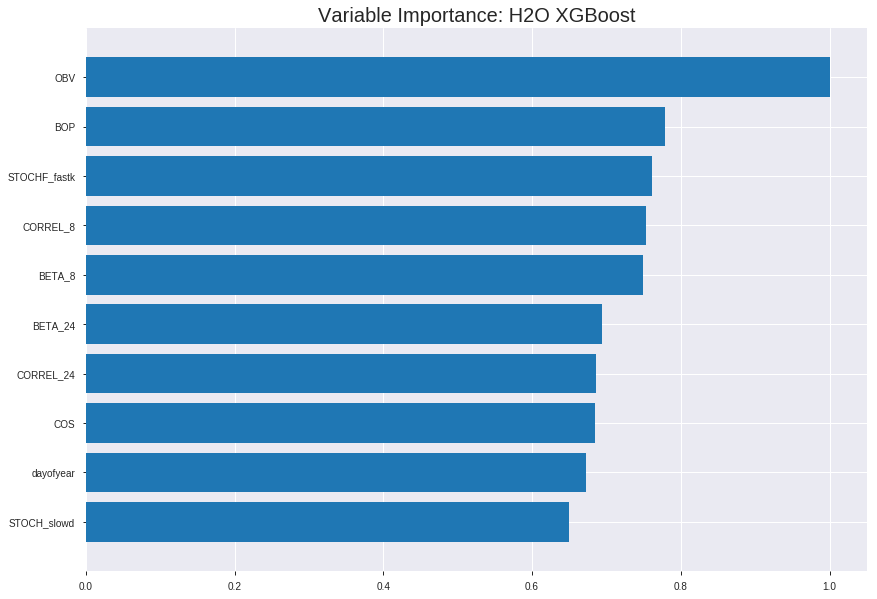

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_165437_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18580391600374302
RMSE: 0.4310497836720754
LogLoss: 0.5608026363531542
Mean Per-Class Error: 0.17211184359472775
AUC: 0.9060318485245911
pr_auc: 0.9070304426176137
Gini: 0.8120636970491821
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48819565773010254: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      676  183  0.213    (183.0/859.0)
1      114  755  0.1312   (114.0/869.0)
Total  790  938  0.1719   (297.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488196     0.835639  217
max f2                       0.432081     0.890542  272
max f0point5                 0.541256     0.837989  165
max accuracy                 0.488196     0.828125  217
max precision                0.79886      1         0
max recall                   0.305697     1         377
max specificity              0.79886      1         0
max absolute_mcc             0.488196     0.658184  217
max min_per_class_accuracy   0.500854     0.821634  204
max mean_per_class_accuracy  0.488196     0.827888  217

Gains/Lift Table: Avg response rate: 50.29 %, avg score: 50.24 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.73706            1.98849    1.98849            1                0.76313   1                           0.76313             0.0207135       0.0207135                  98.8493   98.8493
    2        0.0202546                   0.72397            1.98849    1.98849            1                0.730716  1                           0.747386            0.0195627       0.0402762                  98.8493   98.8493
    3        0.0300926                   0.712936           1.98849    1.98849            1                0.719459  1                           0.738256            0.0195627       0.0598389                  98.8493   98.8493
    4        0.0405093                   0.703567           1.87802    1.96009            0.944444         0.708104  0.985714                    0.730503            0.0195627       0.0794016                  87.8021   96.0085
    5        0.0503472                   0.695371           1.98849    1.96564            1                0.698689  0.988506                    0.724286            0.0195627       0.0989643                  98.8493   96.5636
    6        0.100116                    0.651103           1.96537    1.9655             0.988372         0.668286  0.988439                    0.696448            0.0978136       0.196778                   96.5371   96.5504
    7        0.150463                    0.627847           1.96564    1.96555            0.988506         0.639483  0.988462                    0.677387            0.0989643       0.295742                   96.5636   96.5548
    8        0.200231                    0.605499           1.75727    1.91378            0.883721         0.61695   0.962428                    0.662365            0.0874568       0.383199                   75.7272   91.378
    9        0.300347                    0.565425           1.72413    1.85056            0.867052         0.585569  0.930636                    0.636766            0.172612        0.555811                   72.4126   85.0562
    10       0.399884                    0.529698           1.41044    1.74101            0.709302         0.545853  0.875543                    0.614137            0.140391        0.696203                   41.0442   74.101
    11       0.5                         0.500579           1.22988    1.63867            0.618497         0.51484   0.824074                    0.594254            0.12313         0.819333                   22.9877   63.8665
    12       0.600116                    0.47               0.850569   1.50719            0.427746         0.485969  0.757956                    0.576189            0.0851554       0.904488                   -14.9431  50.7189
    13       0.699653                    0.435757           0.520245   1.36678            0.261628         0.453511  0.687345                    0.558736            0.0517837       0.956272                   -47.9755  36.678
    14       0.799769                    0.396776           0.333331   1.23741            0.16763          0.417358  0.622287                    0.541039            0.0333717       0.989643                   -66.6669  23.7412
    15       0.899884                    0.352954           0.0689651  1.10742            0.0346821        0.376226  0.556913                    0.522703            0.00690449      0.996548                   -93.1035  10.7418
    16       1                           0.224835           0.0344825  1                  0.017341         0.319834  0.502894                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2528534209172409
RMSE: 0.5028453250426426
LogLoss: 0.699057040251522
Mean Per-Class Error: 0.4542903098739496
AUC: 0.5219193146008403
pr_auc: 0.5337024403157368
Gini: 0.04383862920168058
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.334374338388443: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    232  0.9748   (232.0/238.0)
1      2    254  0.0078   (2.0/256.0)
Total  8    486  0.4737   (234.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.334374     0.684636   392
max f2                       0.314915     0.843215   399
max f0point5                 0.391527     0.578613   355
max accuracy                 0.514114     0.540486   145
max precision                0.669929     0.666667   2
max recall                   0.314915     1          399
max specificity              0.6875       0.995798   0
max absolute_mcc             0.514114     0.0952644  145
max min_per_class_accuracy   0.491898     0.512605   193
max mean_per_class_accuracy  0.514114     0.54571    145

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 48.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.643736           0.771875  0.771875           0.4              0.665468  0.4                         0.665468            0.0078125       0.0078125                  -22.8125  -22.8125
    2        0.0202429                   0.626776           0.771875  0.771875           0.4              0.637689  0.4                         0.651578            0.0078125       0.015625                   -22.8125  -22.8125
    3        0.0303644                   0.616386           1.15781   0.900521           0.6              0.62279   0.466667                    0.641982            0.0117188       0.0273438                  15.7812   -9.94792
    4        0.0404858                   0.609977           1.54375   1.06133            0.8              0.613101  0.55                        0.634762            0.015625        0.0429688                  54.375    6.13281
    5        0.0506073                   0.60158            0.771875  1.00344            0.4              0.60726   0.52                        0.629261            0.0078125       0.0507812                  -22.8125  0.34375
    6        0.101215                    0.580359           1.15781   1.08063            0.6              0.590205  0.56                        0.609733            0.0585938       0.109375                   15.7812   8.0625
    7        0.149798                    0.564438           1.20605   1.1213             0.625            0.57079   0.581081                    0.597103            0.0585938       0.167969                   20.6055   12.1305
    8        0.200405                    0.553339           0.92625   1.07205            0.48             0.559155  0.555556                    0.58752             0.046875        0.214844                   -7.375    7.20486
    9        0.299595                    0.525821           1.02392   1.05611            0.530612         0.539805  0.547297                    0.571723            0.101562        0.316406                   2.39158   5.61128
    10       0.40081                     0.508366           1.15781   1.08179            0.6              0.515919  0.560606                    0.557631            0.117188        0.433594                   15.7812   8.17945
    11       0.5                         0.491898           0.827009  1.03125            0.428571         0.499996  0.534413                    0.546197            0.0820312       0.515625                   -17.2991  3.125
    12       0.59919                     0.472321           0.86639   1.00396            0.44898          0.481512  0.52027                     0.535489            0.0859375       0.601562                   -13.361   0.395904
    13       0.700405                    0.45343            0.964844  0.998307           0.5              0.463257  0.517341                    0.525051            0.0976562       0.699219                   -3.51562  -0.169346
    14       0.799595                    0.429709           1.10268   1.01125            0.571429         0.441439  0.524051                    0.514679            0.109375        0.808594                   10.2679   1.1254
    15       0.898785                    0.395723           1.0633    1.017              0.55102          0.412442  0.527027                    0.503396            0.105469        0.914062                   6.32972   1.69975
    16       1                           0.314915           0.849062  1                  0.44             0.366711  0.518219                    0.489561       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:54:47  2.576 sec   0                  0.5              0.693147            0.5             0                  1                0.497106                         0.5                0.693147              0.5               0                    1                  0.481781
    2019-08-28 16:54:47  2.722 sec   5                  0.492045         0.677333            0.720429        0.719644           1.87802          0.398727                         0.499324           0.691794              0.530914          0.548973             1.54375            0.481781
    2019-08-28 16:54:47  2.814 sec   10                 0.482991         0.659536            0.782551        0.783815           1.98849          0.322338                         0.499178           0.691509              0.535214          0.528106             0.771875           0.481781
    2019-08-28 16:54:47  2.911 sec   15                 0.474645         0.643275            0.807805        0.806471           1.98849          0.275463                         0.499644           0.692449              0.527639          0.52738              1.15781            0.479757
    2019-08-28 16:54:47  2.999 sec   20                 0.467044         0.62863             0.831791        0.829265           1.98849          0.258681                         0.499456           0.692071              0.531472          0.536943             1.15781            0.477733
    2019-08-28 16:54:47  3.106 sec   25                 0.459232         0.613744            0.856471        0.852074           1.98849          0.223958                         0.499079           0.691301              0.537602          0.546356             1.54375            0.47166
    2019-08-28 16:54:48  3.210 sec   30                 0.451522         0.59911             0.871684        0.869137           1.98849          0.222801                         0.499921           0.692986              0.528484          0.537369             1.54375            0.465587
    2019-08-28 16:54:48  3.302 sec   35                 0.446597         0.589786            0.880584        0.878737           1.98849          0.203125                         0.501762           0.69675               0.515666          0.52772              1.15781            0.475709
    2019-08-28 16:54:48  3.397 sec   40                 0.440999         0.57926             0.888499        0.887484           1.98849          0.204282                         0.501842           0.696944              0.519367          0.533616             0.771875           0.47166
    2019-08-28 16:54:48  3.505 sec   45                 0.435806         0.569559            0.897234        0.895749           1.98849          0.190394                         0.50195            0.697183              0.522198          0.536049             1.15781            0.477733
    2019-08-28 16:54:48  3.620 sec   50                 0.43105          0.560803            0.906032        0.90703            1.98849          0.171875                         0.502845           0.699057              0.521919          0.533702             0.771875           0.473684

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
OBV                358.9507751464844      1.0                   0.07315331004395573
BOP                279.31561279296875     0.7781446151745535    0.05692385429289872
STOCHF_fastk       273.38970947265625     0.7616356570370646    0.05571616935976431
CORREL_8           270.3902587890625      0.7532794954369965    0.05510488847945713
BETA_8             268.88079833984375     0.7490742936273534    0.054797264047678915
---                ---                    ---                   ---
CDLHAMMER          11.810402870178223     0.03290256962213972   0.0024069318768112262
month              6.289310455322266      0.017521373098458023  0.0012817464386673247
CDLINVERTEDHAMMER  5.131526470184326      0.014295905805162837  0.0010457928297242635
HT_TRENDMODE       4.198635101318359      0.0116969662472659    0.0008556717984599276
quarter            2.2395095825195312     0.006239043728504581  0.0004564067002490931


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6194331983805668)

('F1', 0.5885885885885885)

('auc', 0.6036054421768707)

('logloss', 0.6702832449219084)

('mean_per_class_error', 0.387891156462585)

('rmse', 0.4886184627835443)

('mse', 0.2387480021729539)

xgboost prediction progress: |████████████████████████████████████████████| 100%


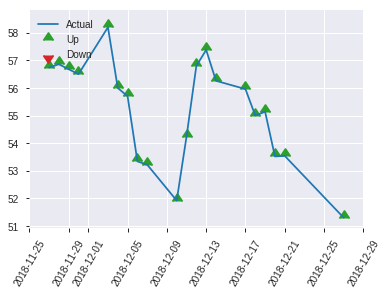


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2387480021729539
RMSE: 0.4886184627835443
LogLoss: 0.6702832449219084
Mean Per-Class Error: 0.387891156462585
AUC: 0.6036054421768707
pr_auc: 0.48923638903105876
Gini: 0.20721088435374146
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3729217052459717: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   135  0.9184   (135.0/147.0)
1      2    98   0.02     (2.0/100.0)
Total  14   233  0.5547   (137.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.372922     0.588589  232
max f2                       0.341082     0.776398  243
max f0point5                 0.468732     0.53125   134
max accuracy                 0.537336     0.619433  45
max precision                0.658711     1         0
max recall                   0.341082     1         243
max specificity              0.658711     1         0
max absolute_mcc             0.468732     0.221082  134
max min_per_class_accuracy   0.477361     0.591837  119
max mean_per_class_accuracy  0.468732     0.612109  134

Gains/Lift Table: Avg response rate: 40.49 %, avg score: 47.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.645501           0.823333  0.823333           0.333333         0.653163  0.333333                    0.653163            0.01            0.01                       -17.6667  -17.6667
    2        0.0202429                   0.629427           2.47      1.482              1                0.640853  0.6                         0.648239            0.02            0.03                       147       48.2
    3        0.0323887                   0.618749           2.47      1.8525             1                0.623429  0.75                        0.638935            0.03            0.06                       147       85.25
    4        0.0404858                   0.608228           1.235     1.729              0.5              0.61336   0.7                         0.63382             0.01            0.07                       23.5      72.9
    5        0.0526316                   0.598854           0.823333  1.52               0.333333         0.604073  0.615385                    0.626956            0.01            0.08                       -17.6667  52
    6        0.101215                    0.571434           1.02917   1.2844             0.416667         0.584895  0.52                        0.606767            0.05            0.13                       2.91667   28.44
    7        0.149798                    0.555079           1.44083   1.33514            0.583333         0.562191  0.540541                    0.59231             0.07            0.2                        44.0833   33.5135
    8        0.202429                    0.532733           1.33      1.3338             0.538462         0.540968  0.54                        0.578961            0.07            0.27                       33        33.38
    9        0.299595                    0.509863           1.02917   1.235              0.416667         0.519729  0.5                         0.55975             0.1             0.37                       2.91667   23.5
    10       0.40081                     0.490765           0.7904    1.12273            0.32             0.500689  0.454545                    0.544836            0.08            0.45                       -20.96    12.2727
    11       0.502024                    0.474983           1.6796    1.235              0.68             0.482428  0.5                         0.532254            0.17            0.62                       67.96     23.5
    12       0.59919                     0.45958            0.92625   1.18493            0.375            0.468201  0.47973                     0.521867            0.09            0.71                       -7.375    18.4932
    13       0.700405                    0.44098            0.6916    1.11364            0.28             0.449568  0.450867                    0.511419            0.07            0.78                       -30.84    11.3642
    14       0.797571                    0.420067           0.6175    1.0532             0.25             0.42922   0.426396                    0.501405            0.06            0.84                       -38.25    5.3198
    15       0.898785                    0.384962           0.6916    1.01248            0.28             0.402377  0.40991                     0.490253            0.07            0.91                       -30.84    1.24775
    16       1                           0.293731           0.8892    1                  0.36             0.359935  0.404858                    0.477063            0.09            1   

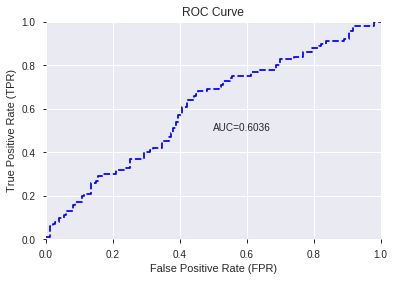

This function is available for GLM models only


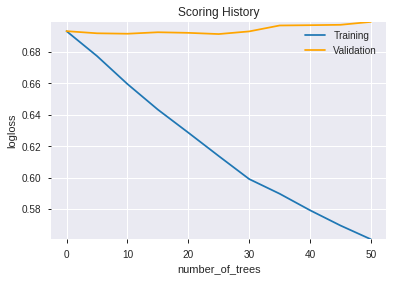

--2019-08-28 16:55:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.233.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.233.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_165437_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_165437_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a241',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['OBV',
 'BOP',
 'STOCHF_fastk',
 'CORREL_8',
 'BETA_8',
 'BETA_24',
 'CORREL_24',
 'COS',
 'dayofyear',
 'STOCH_slowd',
 'STOCHRSI_fastd',
 'HT_DCPERIOD',
 'BETA_12',
 'DX_8',
 'SIN',
 'SAREXT',
 'day',
 'BETA_20',
 'AROONOSC_14',
 'week',
 'aroondown_12',
 'aroondown_14',
 'aroondown_8',
 'STOCHRSI_fastk',
 'dayofweek',
 'weekday_name',
 'CDLSPINNINGTOP',
 'days_in_month',
 'weekofyear',
 'weekday',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLHAMMER',
 'month',
 'CDLINVERTEDHAMMER',
 'HT_TRENDMODE',
 'quarter']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_165508_model_1  0.49585  0.688424              0.479388  0.497635  0.247641

variable  relative_importance  scaled_importance    percentage
0            CDLINVERTEDHAMMER         7.399655e-03           1.000000  1.137145e-02
1                          BOP         7.355352e-03           0.994013  1.130337e-02
2                    CDLHAMMER         6.402944e-03           0.865303  9.839748e-03
3                          OBV         6.334043e-03           0.855992  9.733865e-03
4                 STOCHF_fastk         5.624374e-03           0.760086  8.643279e-03
...                        ...                  ...                ...           ...
1036                    WMA_24         2.461764e-06           0.000333  3.783125e-06
1037   BBANDS_upperband_14_3_5         2.260190e-06           0.000305  3.473356e-06
1038              MINMAX_max_8         2.154259e-06           0.000291  3.310566e-06
1039  BBANDS_middleband_14_3_2         6.910439e-07           0.000093  1.061964e-06
1040  BBANDS_middleband_24_2_2         1.366468e-07           0.000018  2.099925e-07

[1041 rows x 4 columns]

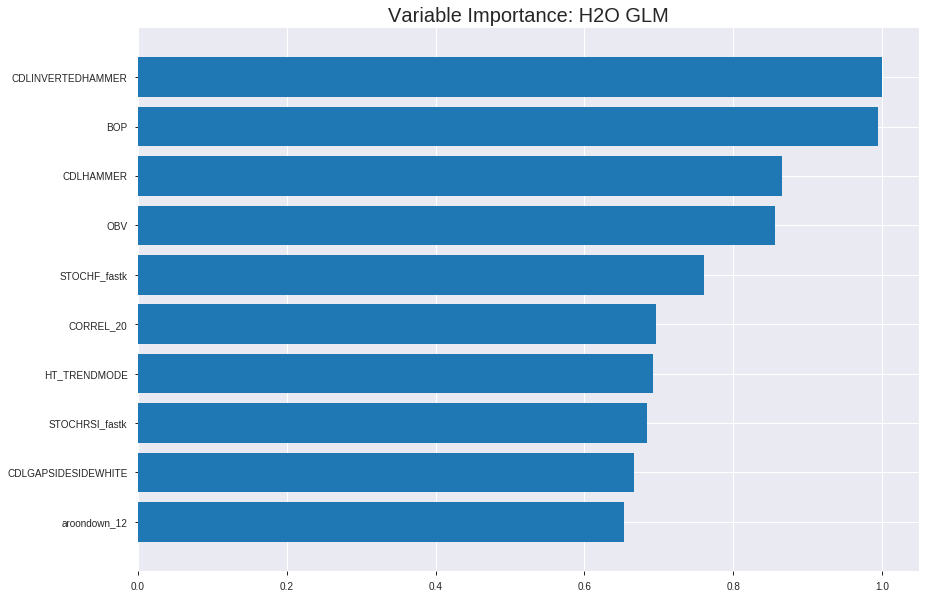

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_165508_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2465421024425494
RMSE: 0.49653006197263566
LogLoss: 0.6862096716473838
Null degrees of freedom: 1727
Residual degrees of freedom: 686
Null deviance: 2395.458785321781
Residual deviance: 2371.5406252133585
AIC: 4455.540625213358
AUC: 0.5830300172411252
pr_auc: 0.5844902452649052
Gini: 0.16606003448225048
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4445817718617521: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      35   824   0.9593   (824.0/859.0)
1      10   859   0.0115   (10.0/869.0)
Total  45   1683  0.4826   (834.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444582     0.673197  372
max f2                       0.413411     0.835095  398
max f0point5                 0.471439     0.571171  302
max accuracy                 0.518618     0.570023  137
max precision                0.582088     1         0
max recall                   0.413411     1         398
max specificity              0.582088     1         0
max absolute_mcc             0.518618     0.151483  137
max min_per_class_accuracy   0.505465     0.552359  188
max mean_per_class_accuracy  0.518618     0.57103   137

Gains/Lift Table: Avg response rate: 50.29 %, avg score: 50.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.565116           1.43613   1.43613            0.722222         0.572443  0.722222                    0.572443            0.0149597       0.0149597                  43.6133   43.6133
    2        0.0202546                   0.558388           1.40364   1.42035            0.705882         0.561163  0.714286                    0.566964            0.013809        0.0287687                  40.3642   42.0352
    3        0.0300926                   0.551995           1.52061   1.45313            0.764706         0.554332  0.730769                    0.562835            0.0149597       0.0437284                  52.0612   45.3129
    4        0.0405093                   0.547763           1.32566   1.42035            0.666667         0.549961  0.714286                    0.559524            0.013809        0.0575374                  32.5662   42.0352
    5        0.0503472                   0.545573           1.40364   1.41709            0.705882         0.546531  0.712644                    0.556985            0.013809        0.0713464                  40.3642   41.7087
    6        0.100116                    0.538689           1.20234   1.31034            0.604651         0.541858  0.65896                     0.549466            0.0598389       0.131185                   20.2344   31.0336
    7        0.150463                    0.533832           1.16567   1.26193            0.586207         0.536124  0.634615                    0.545001            0.0586881       0.189873                   16.5668   26.1928
    8        0.200231                    0.529339           1.20234   1.24712            0.604651         0.531389  0.627168                    0.541618            0.0598389       0.249712                   20.2344   24.7118
    9        0.300347                    0.520257           1.13792   1.21072            0.572254         0.524548  0.608863                    0.535928            0.113924        0.363636                   13.7923   21.072
    10       0.399884                    0.51304            0.913319  1.13669            0.459302         0.516758  0.571635                    0.531156            0.0909091       0.454545                   -8.66808  13.6693
    11       0.5                         0.505229           1.01149   1.11162            0.508671         0.509164  0.559028                    0.526753            0.101266        0.555811                   1.14875   11.1623
    12       0.600116                    0.497046           0.896546  1.07574            0.450867         0.50151   0.540984                    0.522541            0.0897583       0.64557                    -10.3454  7.57419
    13       0.699653                    0.487392           0.982685  1.0625             0.494186         0.492677  0.534326                    0.518293            0.0978136       0.743383                   -1.73147  6.2503
    14       0.799769                    0.475344           0.885052  1.04029            0.445087         0.481687  0.523155                    0.51371             0.0886076       0.831991                   -11.4948  4.02895
    15       0.899884                    0.462953           0.919534  1.02685            0.462428         0.46949   0.516399                    0.508791            0.0920598       0.924051                   -8.04659  2.6855
    16       1                           0.394616           0.758616  1                  0.381503         0.449887  0.502894                    0.502894            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24979247478081168
RMSE: 0.49979243169621096
LogLoss: 0.6927389873978619
Null degrees of freedom: 493
Residual degrees of freedom: -548
Null deviance: 684.6376229712456
Residual deviance: 684.4261195490876
AIC: 2768.4261195490876
AUC: 0.5115464154411765
pr_auc: 0.5129583539412818
Gini: 0.023092830882353033
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4747016280280516: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    237  0.9958   (237.0/238.0)
1      0    256  0        (0.0/256.0)
Total  1    493  0.4798   (237.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.474702     0.683578   398
max f2                       0.474702     0.843771   398
max f0point5                 0.503073     0.579955   302
max accuracy                 0.503458     0.546559   300
max precision                0.544062     0.571429   26
max recall                   0.474702     1          398
max specificity              0.587634     0.995798   0
max absolute_mcc             0.503073     0.0872796  302
max min_per_class_accuracy   0.516096     0.503906   198
max mean_per_class_accuracy  0.503458     0.536945   300

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 51.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.555482           0.385938  0.385938           0.2              0.56493   0.2                         0.56493             0.00390625      0.00390625                 -61.4062  -61.4062
    2        0.0202429                   0.553059           1.15781   0.771875           0.6              0.554097  0.4                         0.559514            0.0117188       0.015625                   15.7812   -22.8125
    3        0.0303644                   0.550623           0.385938  0.643229           0.2              0.552001  0.333333                    0.557009            0.00390625      0.0195312                  -61.4062  -35.6771
    4        0.0404858                   0.548309           1.92969   0.964844           1                0.549643  0.5                         0.555168            0.0195312       0.0390625                  92.9688   -3.51562
    5        0.0506073                   0.545108           1.15781   1.00344            0.6              0.54693   0.52                        0.55352             0.0117188       0.0507812                  15.7812   0.34375
    6        0.101215                    0.539123           0.771875  0.887656           0.4              0.541788  0.46                        0.547654            0.0390625       0.0898438                  -22.8125  -11.2344
    7        0.149798                    0.534905           1.04525   0.938767           0.541667         0.536817  0.486486                    0.544139            0.0507812       0.140625                   4.52474   -6.12331
    8        0.200405                    0.530404           1.08063   0.97459            0.56             0.532311  0.505051                    0.541152            0.0546875       0.195312                   8.0625    -2.54104
    9        0.299595                    0.524152           0.984534  0.977882           0.510204         0.527104  0.506757                    0.536501            0.0976562       0.292969                   -1.54656  -2.21178
    10       0.40081                     0.519524           1.11922   1.01357            0.58             0.521932  0.525253                    0.532822            0.113281        0.40625                    11.9219   1.35732
    11       0.5                         0.51574            0.984534  1.00781            0.510204         0.517812  0.522267                    0.529844            0.0976562       0.503906                   -1.54656  0.78125
    12       0.59919                     0.510991           1.02392   1.01048            0.530612         0.513348  0.523649                    0.527114            0.101562        0.605469                   2.39158   1.04783
    13       0.700405                    0.505935           1.15781   1.03177            0.6              0.508613  0.534682                    0.52444             0.117188        0.722656                   15.7812   3.17693
    14       0.799595                    0.501372           1.0633    1.03568            0.55102          0.503869  0.536709                    0.521888            0.105469        0.828125                   6.32972   3.56804
    15       0.898785                    0.494659           0.787628  1.00831            0.408163         0.497979  0.522523                    0.51925             0.078125        0.90625                    -21.2372  0.830518
    16       1                           0.471429           0.92625   1                  0.48             0.488166  0.518219                    0.516103


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 16:55:12  0.000 sec   2            3.7       1042          1.37242           1.38548
    2019-08-28 16:55:14  2.268 sec   4            2.7       1042          1.36937           1.38604
    2019-08-28 16:55:17  4.602 sec   6            2         1042          1.36576           1.38691
    2019-08-28 16:55:19  6.905 sec   8            1.4       1042          1.36153           1.38819
    2019-08-28 16:55:21  9.218 sec   10           1         1042          1.35667           1.39
    2019-08-28 16:55:24  11.523 sec  12           0.76      1042          1.3512            1.39249

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6032388663967612)

('F1', 0.5833333333333334)

('auc', 0.49585034013605445)

('logloss', 0.6884238067789862)

('mean_per_class_error', 0.4554421768707483)

('rmse', 0.4976353642150905)

('mse', 0.2476409557174858)

glm prediction progress: |████████████████████████████████████████████████| 100%


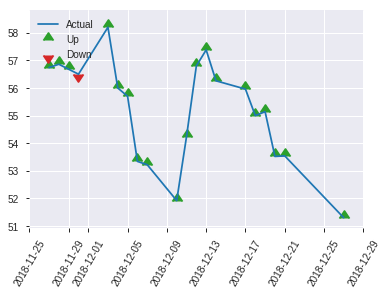


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2476409557174858
RMSE: 0.4976353642150905
LogLoss: 0.6884238067789862
Null degrees of freedom: 246
Residual degrees of freedom: -795
Null deviance: 342.9669668693666
Residual deviance: 340.0813605488192
AIC: 2424.0813605488192
AUC: 0.49585034013605445
pr_auc: 0.4179999324655555
Gini: -0.008299319727891108
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4574852995966467: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    138  0.9388   (138.0/147.0)
1      2    98   0.02     (2.0/100.0)
Total  11   236  0.5668   (140.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457485     0.583333  235
max f2                       0.450397     0.776398  243
max f0point5                 0.459887     0.469368  227
max accuracy                 0.522174     0.603239  5
max precision                0.522174     0.666667  5
max recall                   0.450397     1         243
max specificity              0.580316     0.993197  0
max absolute_mcc             0.505428     0.107591  39
max min_per_class_accuracy   0.483586     0.47619   124
max mean_per_class_accuracy  0.499331     0.544558  60

Gains/Lift Table: Avg response rate: 40.49 %, avg score: 48.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.527991           0.823333  0.823333           0.333333         0.553663  0.333333                    0.553663            0.01            0.01                       -17.6667  -17.6667
    2        0.0202429                   0.522262           2.47      1.482              1                0.525059  0.6                         0.542221            0.02            0.03                       147       48.2
    3        0.0323887                   0.519595           0.823333  1.235              0.333333         0.521328  0.5                         0.534386            0.01            0.04                       -17.6667  23.5
    4        0.0404858                   0.518533           0         0.988              0                0.51857   0.4                         0.531223            0               0.04                       -100      -1.2
    5        0.0526316                   0.517921           0.823333  0.95               0.333333         0.518194  0.384615                    0.528216            0.01            0.05                       -17.6667  -5
    6        0.101215                    0.510921           1.64667   1.2844             0.666667         0.513976  0.52                        0.521381            0.08            0.13                       64.6667   28.44
    7        0.149798                    0.506026           1.235     1.26838            0.5              0.508003  0.513514                    0.517042            0.06            0.19                       23.5      26.8378
    8        0.202429                    0.501005           0.76      1.1362             0.307692         0.502902  0.46                        0.513366            0.04            0.23                       -24       13.62
    9        0.299595                    0.495639           0.823333  1.03473            0.333333         0.498768  0.418919                    0.508631            0.08            0.31                       -17.6667  3.47297
    10       0.40081                     0.489861           0.7904    0.97303            0.32             0.492909  0.393939                    0.504661            0.08            0.39                       -20.96    -2.69697
    11       0.502024                    0.48361            0.7904    0.93621            0.32             0.485989  0.379032                    0.500897            0.08            0.47                       -20.96    -6.37903
    12       0.59919                     0.480805           1.13208   0.967973           0.458333         0.481799  0.391892                    0.4978              0.11            0.58                       13.2083   -3.2027
    13       0.700405                    0.476664           0.7904    0.942312           0.32             0.478562  0.381503                    0.49502             0.08            0.66                       -20.96    -5.76879
    14       0.797571                    0.470961           1.13208   0.965431           0.458333         0.474109  0.390863                    0.492472            0.11            0.77                       13.2083   -3.45685
    15       0.898785                    0.463216           1.3832    1.01248            0.56             0.467728  0.40991                     0.489686            0.14            0.91                       38.32     1.24775
    16       1                           0.427938           0.8892    1                  0.36             0.455342  0.404858                    0.486209            0.09      

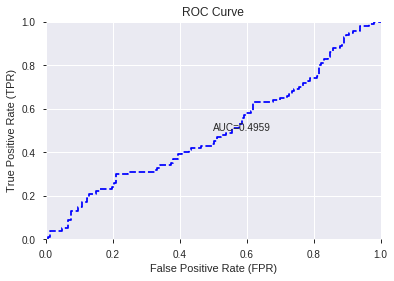

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


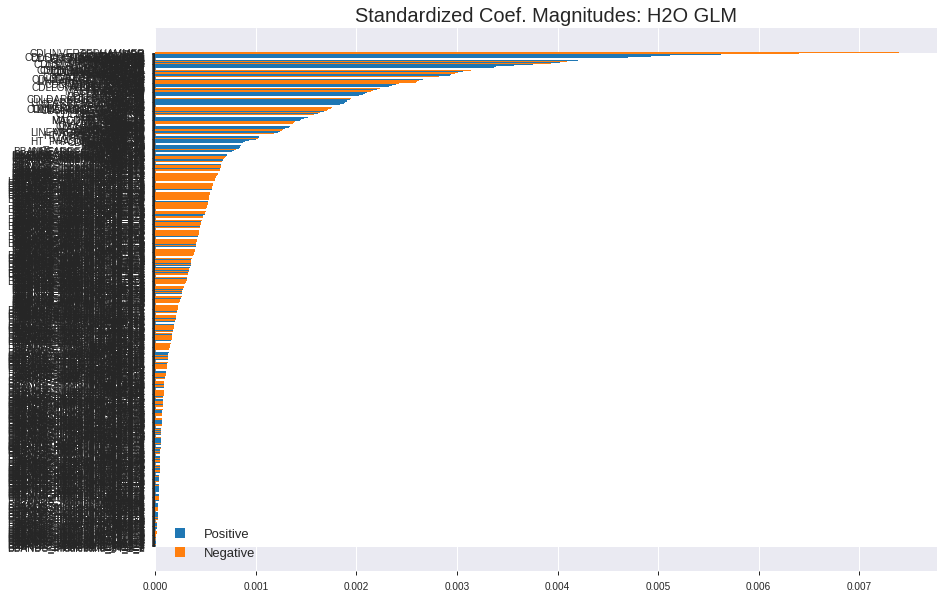

'log_likelihood'
--2019-08-28 16:55:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.226.8
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.226.8|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_165508_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_165508_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a241',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

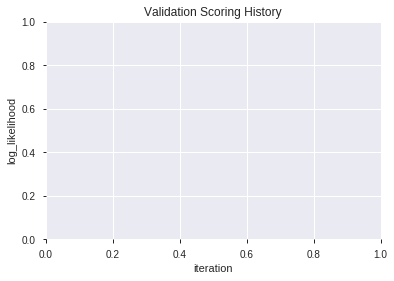

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190828_165556  0.578367  0.678305              0.407143  0.492604  0.242659
1               XGBoost_1_AutoML_20190828_165556  0.573197  0.681633              0.429762  0.494208  0.244242
2  XGBoost_grid_1_AutoML_20190828_165556_model_1  0.566122  0.679576              0.403537  0.493212  0.243258
3               XGBoost_2_AutoML_20190828_165556  0.558844  0.693280              0.496599  0.499594  0.249594
4  XGBoost_grid_1_AutoML_20190828_165556_model_2  0.556803  0.684636              0.496599  0.495723  0.245741
5  XGBoost_grid_1_AutoML_20190828_165556_model_4  0.541156  0.688952              0.439150  0.497863  0.247867
6  XGBoost_grid_1_AutoML_20190828_165556_model_3  0.516395  0.692400              0.481190  0.499661  0.249661
7  XGBoost_grid_1_AutoML_20190828_165556_model_7  0.507687  0.712578              0.500000  0.509040  0.259122
8  XGBoost_grid_1_AutoML_20190828_165556_model_6  0.505034  0.698215              0.480986  0.502462  0.252468
9  XGBoost_grid_1_AutoML_20190828_165556_model_5  0.471905  0.740586              0.500000  0.521169  0.271617

variable  relative_importance  scaled_importance  percentage
0                        BOP           160.743652           1.000000    0.028196
1                        TAN           133.432220           0.830093    0.023405
2                  CORREL_20           126.646767           0.787880    0.022215
3                        OBV           120.574997           0.750107    0.021150
4                  MACD_hist           113.929115           0.708763    0.019984
..                       ...                  ...                ...         ...
300                  NATR_20             1.591702           0.009902    0.000279
301             LINEARREG_30             1.365950           0.008498    0.000240
302    LINEARREG_INTERCEPT_8             1.187124           0.007385    0.000208
303                 WILLR_14             0.605999           0.003770    0.000106
304  BBANDS_upperband_20_0_5             0.460095           0.002862    0.000081

[305 rows x 4 columns]

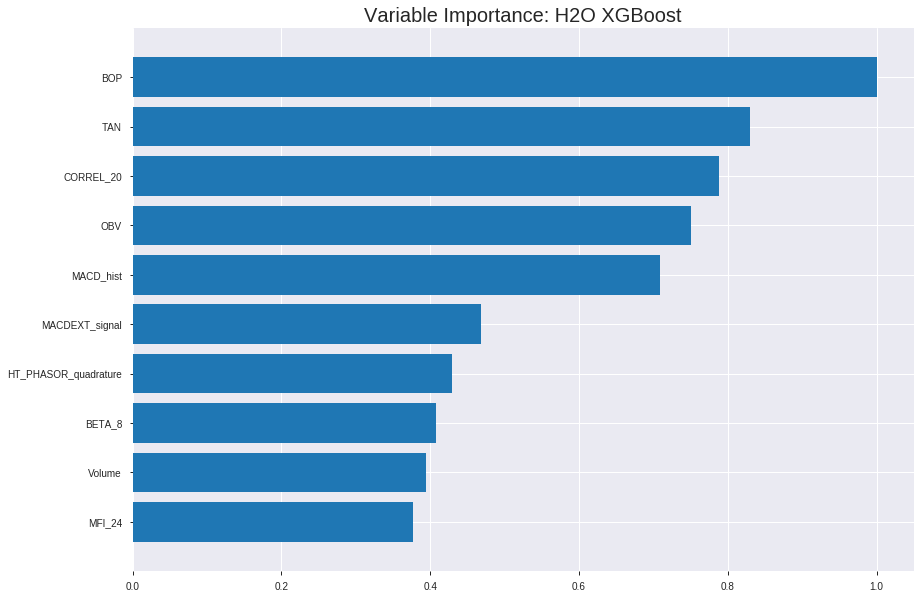

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190828_165556


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17391419056418794
RMSE: 0.417030203419594
LogLoss: 0.5362983493633858
Mean Per-Class Error: 0.12076222652989865
AUC: 0.9506759137327505
pr_auc: 0.9539113338765617
Gini: 0.901351827465501
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5011198073625565: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      768  91   0.1059   (91.0/859.0)
1      118  751  0.1358   (118.0/869.0)
Total  886  842  0.1209   (209.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50112      0.877849  199
max f2                       0.453747     0.91289   244
max f0point5                 0.528996     0.904929  173
max accuracy                 0.506594     0.879051  193
max precision                0.807278     1         0
max recall                   0.367777     1         327
max specificity              0.807278     1         0
max absolute_mcc             0.506594     0.75984   193
max min_per_class_accuracy   0.495835     0.875719  204
max mean_per_class_accuracy  0.506594     0.879238  193

Gains/Lift Table: Avg response rate: 50.29 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.745153           1.98849    1.98849            1                0.765464  1                           0.765464            0.0207135       0.0207135                  98.8493   98.8493
    2        0.0202546                   0.735823           1.98849    1.98849            1                0.740895  1                           0.75353             0.0195627       0.0402762                  98.8493   98.8493
    3        0.0300926                   0.719808           1.98849    1.98849            1                0.728317  1                           0.745287            0.0195627       0.0598389                  98.8493   98.8493
    4        0.0405093                   0.708739           1.98849    1.98849            1                0.714079  1                           0.737262            0.0207135       0.0805524                  98.8493   98.8493
    5        0.0503472                   0.698304           1.98849    1.98849            1                0.703205  1                           0.730608            0.0195627       0.100115                   98.8493   98.8493
    6        0.100116                    0.665057           1.98849    1.98849            1                0.680096  1                           0.705498            0.0989643       0.199079                   98.8493   98.8493
    7        0.150463                    0.637821           1.98849    1.98849            1                0.652054  1                           0.687614            0.100115        0.299194                   98.8493   98.8493
    8        0.200231                    0.615937           1.96537    1.98275            0.988372         0.627424  0.99711                     0.672654            0.0978136       0.397008                   96.5371   98.2745
    9        0.300347                    0.572969           1.88504    1.95018            0.947977         0.594889  0.980732                    0.646732            0.188723        0.585731                   88.5045   95.0179
    10       0.399884                    0.534697           1.68791    1.8849             0.848837         0.553849  0.947902                    0.623612            0.168009        0.75374                    68.7906   88.4895
    11       0.5                         0.495932           1.20689    1.74914            0.606936         0.513675  0.87963                     0.601599            0.120829        0.874568                   20.6889   74.9137
    12       0.600116                    0.459338           0.712639   1.57622            0.358382         0.478869  0.792671                    0.581125            0.0713464       0.945915                   -28.7361  57.6221
    13       0.699653                    0.423393           0.312147   1.39639            0.156977         0.441906  0.702233                    0.561318            0.0310702       0.976985                   -68.7853  39.6386
    14       0.799769                    0.390625           0.183907   1.24461            0.0924855        0.407332  0.625904                    0.542042            0.018412        0.995397                   -81.6093  24.4606
    15       0.899884                    0.354344           0.0459767  1.11125            0.0231214        0.372629  0.558842                    0.523194            0.00460299      1                          -95.4023  11.1254
    16       1                           0.213108           0          1                  0                0.318383  0.502894                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25364068557394154
RMSE: 0.5036275266245299
LogLoss: 0.7004549601124868
Mean Per-Class Error: 0.48396467962184875
AUC: 0.4861639968487395
pr_auc: 0.5134487145317181
Gini: -0.02767200630252098
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3858909606933594: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    232  0.9748   (232.0/238.0)
1      0    256  0        (0.0/256.0)
Total  6    488  0.4696   (232.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385891     0.688172  394
max f2                       0.385891     0.846561  394
max f0point5                 0.385891     0.57971   394
max accuracy                 0.417045     0.532389  375
max precision                0.703608     1         0
max recall                   0.385891     1         394
max specificity              0.703608     1         0
max absolute_mcc             0.385891     0.115     394
max min_per_class_accuracy   0.510347     0.488281  200
max mean_per_class_accuracy  0.417045     0.516035  375

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 51.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.661128           0.771875  0.771875           0.4              0.677961  0.4                         0.677961            0.0078125       0.0078125                  -22.8125  -22.8125
    2        0.0202429                   0.637163           1.54375   1.15781            0.8              0.651459  0.6                         0.66471             0.015625        0.0234375                  54.375    15.7812
    3        0.0303644                   0.629029           0.771875  1.02917            0.4              0.633429  0.533333                    0.654283            0.0078125       0.03125                    -22.8125  2.91667
    4        0.0404858                   0.622784           1.15781   1.06133            0.6              0.625802  0.55                        0.647163            0.0117188       0.0429688                  15.7812   6.13281
    5        0.0506073                   0.61255            0.771875  1.00344            0.4              0.618132  0.52                        0.641357            0.0078125       0.0507812                  -22.8125  0.34375
    6        0.101215                    0.594608           1.00344   1.00344            0.52             0.602804  0.52                        0.62208             0.0507812       0.101562                   0.34375   0.34375
    7        0.149798                    0.574847           1.12565   1.04307            0.583333         0.583923  0.540541                    0.609705            0.0546875       0.15625                    12.5651   4.30743
    8        0.200405                    0.562526           0.694688  0.955098           0.36             0.567961  0.494949                    0.599164            0.0351562       0.191406                   -30.5312  -4.49021
    9        0.299595                    0.542803           0.945153  0.951805           0.489796         0.554266  0.493243                    0.584299            0.09375         0.285156                   -5.48469  -4.81947
    10       0.40081                     0.524686           1.04203   0.97459            0.54             0.532918  0.505051                    0.571324            0.105469        0.390625                   4.20312   -2.54104
    11       0.5                         0.509749           0.984534  0.976562           0.510204         0.516996  0.506073                    0.560546            0.0976562       0.488281                   -1.54656  -2.34375
    12       0.59919                     0.492727           1.0633    0.990921           0.55102          0.500819  0.513514                    0.550659            0.105469        0.59375                    6.32972   -0.907939
    13       0.700405                    0.478049           0.849062  0.970421           0.44             0.486194  0.50289                     0.541343            0.0859375       0.679688                   -15.0938  -2.95791
    14       0.799595                    0.461204           1.14206   0.991713           0.591837         0.470658  0.513924                    0.532575            0.113281        0.792969                   14.206    -0.828718
    15       0.898785                    0.437771           1.0633    0.999613           0.55102          0.450858  0.518018                    0.523556            0.105469        0.898438                   6.32972   -0.0387106
    16       1                           0.266655           1.00344   1                  0.52             0.40961   0.518219                    0.51


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:56:11  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.497106                         0.5                0.693147              0.5               0                    1                  0.481781
    2019-08-28 16:56:12  1.286 sec   5                  0.488877         0.671106            0.789903        0.795798           1.98849          0.309606                         0.500667           0.694483              0.479845          0.503511             0.771875           0.475709
    2019-08-28 16:56:12  1.535 sec   10                 0.478798         0.651457            0.848426        0.85006            1.98849          0.234375                         0.501022           0.695203              0.489693          0.499948             0.321615           0.481781
    2019-08-28 16:56:13  1.801 sec   15                 0.466978         0.628766            0.88637         0.891695           1.98849          0.19213                          0.500433           0.694014              0.504366          0.532299             1.54375            0.481781
    2019-08-28 16:56:13  2.058 sec   20                 0.457233         0.610292            0.904565        0.910264           1.98849          0.1875                           0.500657           0.69448               0.511366          0.532142             1.54375            0.481781
    2019-08-28 16:56:13  2.325 sec   25                 0.447982         0.592942            0.916176        0.921964           1.98849          0.178819                         0.501352           0.695864              0.498055          0.531649             1.54375            0.481781
    2019-08-28 16:56:13  2.582 sec   30                 0.439355         0.576919            0.925904        0.931404           1.98849          0.155093                         0.501892           0.696953              0.497497          0.530561             1.15781            0.479757
    2019-08-28 16:56:14  2.839 sec   35                 0.433375         0.565968            0.935636        0.940303           1.98849          0.141782                         0.503076           0.699332              0.482619          0.516282             1.54375            0.479757
    2019-08-28 16:56:14  3.196 sec   40                 0.427317         0.554947            0.942834        0.946466           1.98849          0.135995                         0.502917           0.698988              0.486369          0.521051             1.15781            0.475709
    2019-08-28 16:56:14  3.440 sec   45                 0.42167          0.544771            0.949182        0.952464           1.98849          0.129051                         0.503509           0.700206              0.484375          0.514052             1.54375            0.475709
    2019-08-28 16:56:15  3.685 sec   50                 0.41703          0.536298            0.950676        0.953911           1.98849          0.120949                         0.503628           0.700455              0.486164          0.513449             0.771875           0.469636

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      160.74365234375        1.0                    0.028195504825962933
TAN                      133.43222045898438     0.8300932479351646     0.02340489817815518
CORREL_20                126.64676666259766     0.7878803599147031     0.022214684490256424
OBV                      120.57499694824219     0.7501073615671789     0.021149655733057715
MACD_hist                113.92911529541016     0.7087627637810106     0.019983923926650306
---                      ---                    ---                    ---
NATR_20                  1.5917024612426758     0.009902117054294767   0.0002791951891916179
LINEARREG_30             1.3659496307373047     0.008497689400612995   0.00023959664250451778
LINEARREG_INTERCEPT_8    1.187124252319336      0.007385201437259077   0.00020822948276494669
WILLR_14                 0.6059989929199219     0.0037699715297248204  0.00010629625046009903
BBANDS_upperband_20_0_5  0.4600954055786133     0.0028622928424862472  8.070379165364013e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6032388663967612)

('F1', 0.6101694915254238)

('auc', 0.5783673469387755)

('logloss', 0.678304666330358)

('mean_per_class_error', 0.40714285714285714)

('rmse', 0.4926042668767879)

('mse', 0.24265896374521764)

xgboost prediction progress: |████████████████████████████████████████████| 100%


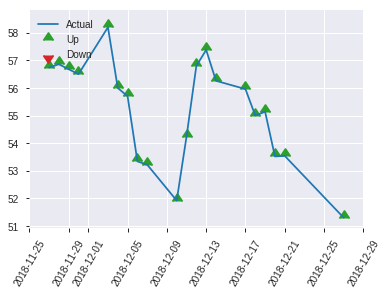


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24265896374521764
RMSE: 0.4926042668767879
LogLoss: 0.678304666330358
Mean Per-Class Error: 0.40714285714285714
AUC: 0.5783673469387755
pr_auc: 0.4449270913277838
Gini: 0.1567346938775509
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42710888385772705: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      42   105  0.7143   (105.0/147.0)
1      10   90   0.1      (10.0/100.0)
Total  52   195  0.4656   (115.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.427109     0.610169  194
max f2                       0.296419     0.773994  245
max f0point5                 0.427109     0.511364  194
max accuracy                 0.60422      0.603239  9
max precision                0.60422      0.6       9
max recall                   0.296419     1         245
max specificity              0.643784     0.993197  0
max absolute_mcc             0.427109     0.223607  194
max min_per_class_accuracy   0.484199     0.544218  121
max mean_per_class_accuracy  0.427109     0.592857  194

Gains/Lift Table: Avg response rate: 40.49 %, avg score: 48.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.623949           0.823333  0.823333           0.333333         0.634221  0.333333                    0.634221            0.01            0.01                       -17.6667  -17.6667
    2        0.0202429                   0.620892           0         0.494              0                0.621712  0.2                         0.629217            0               0.01                       -100      -50.6
    3        0.0323887                   0.605796           2.47      1.235              1                0.612257  0.5                         0.622857            0.03            0.04                       147       23.5
    4        0.0404858                   0.603405           2.47      1.482              1                0.604618  0.6                         0.619209            0.02            0.06                       147       48.2
    5        0.0526316                   0.590826           0         1.14               0                0.598326  0.461538                    0.61439             0               0.06                       -100      14
    6        0.101215                    0.569335           0.823333  0.988              0.333333         0.579006  0.4                         0.597406            0.04            0.1                        -17.6667  -1.2
    7        0.149798                    0.551644           1.235     1.06811            0.5              0.5595    0.432432                    0.585112            0.06            0.16                       23.5      6.81081
    8        0.202429                    0.541235           1.14      1.0868             0.461538         0.547381  0.44                        0.575302            0.06            0.22                       14        8.68
    9        0.299595                    0.518301           1.33792   1.16824            0.541667         0.530751  0.472973                    0.560853            0.13            0.35                       33.7917   16.8243
    10       0.40081                     0.50171            1.0868    1.14768            0.44             0.508453  0.464646                    0.547621            0.11            0.46                       8.68      14.7677
    11       0.502024                    0.483506           1.0868    1.1354             0.44             0.491106  0.459677                    0.536227            0.11            0.57                       8.68      13.5403
    12       0.59919                     0.469777           0.720417  1.06811            0.291667         0.474535  0.432432                    0.526223            0.07            0.64                       -27.9583  6.81081
    13       0.700405                    0.445745           1.5808    1.1422             0.64             0.458822  0.462428                    0.516483            0.16            0.8                        58.08     14.2197
    14       0.797571                    0.424939           1.02917   1.12843            0.416667         0.436338  0.456853                    0.506719            0.1             0.9                        2.91667   12.8426
    15       0.898785                    0.394653           0.494     1.05698            0.2              0.409367  0.427928                    0.495756            0.05            0.95                       -50.6     5.6982
    16       1                           0.2871             0.494     1                  0.2              0.357987  0.404858                    0.481812            0.05            

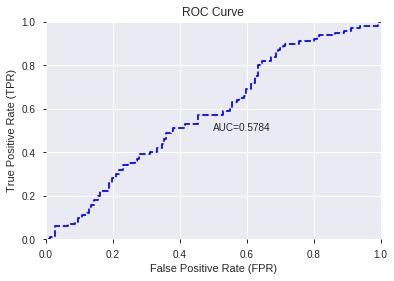

This function is available for GLM models only


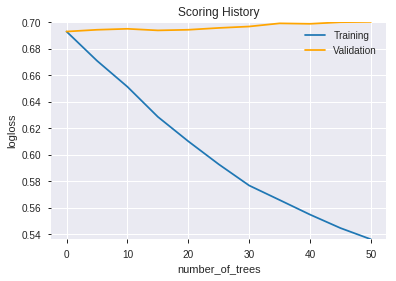

--2019-08-28 16:57:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190828_165556',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190828_165556',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a241',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_a241',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_165708_model_4  0.577687  0.896604              0.500000  0.518503  0.268845
1  DeepLearning_grid_1_AutoML_20190828_165708_model_2  0.575034  0.937690              0.481190  0.529940  0.280837
2  DeepLearning_grid_1_AutoML_20190828_165708_model_9  0.574966  0.700532              0.449966  0.503698  0.253712
3  DeepLearning_grid_1_AutoML_20190828_165708_model_8  0.570952  0.682819              0.458980  0.494772  0.244799
4  DeepLearning_grid_1_AutoML_20190828_165708_model_7  0.566122  0.919882              0.482789  0.567012  0.321503
5  DeepLearning_grid_1_AutoML_20190828_165708_model_1  0.555986  1.239963              0.482789  0.564312  0.318449
6  DeepLearning_grid_1_AutoML_20190828_165708_model_3  0.553878  0.912583              0.486395  0.535351  0.286601
7  DeepLearning_grid_1_AutoML_20190828_165708_model_5  0.551633  0.702622              0.472177  0.502573  0.252579
8               DeepLearning_1_AutoML_20190828_165708  0.519252  0.731860              0.496599  0.509807  0.259903
9  DeepLearning_grid_1_AutoML_20190828_165708_model_6  0.510884  0.701359              0.493197  0.504169  0.254186

variable  relative_importance  scaled_importance  percentage
0           CDLONNECK             1.000000           1.000000    0.036651
1   CDL3WHITESOLDIERS             0.998304           0.998304    0.036589
2           CDLINNECK             0.967436           0.967436    0.035458
3   CDLSTALLEDPATTERN             0.958109           0.958109    0.035116
4         CDLPIERCING             0.926606           0.926606    0.033961
5      CDL3BLACKCROWS             0.925152           0.925152    0.033908
6     CDLLADDERBOTTOM             0.919563           0.919563    0.033703
7    CDLCOUNTERATTACK             0.910426           0.910426    0.033368
8    CDLSTICKSANDWICH             0.877077           0.877077    0.032146
9      CDLEVENINGSTAR             0.720475           0.720475    0.026406
10  CDLINVERTEDHAMMER             0.667449           0.667449    0.024463
11      CDLHANGINGMAN             0.567251           0.567251    0.020790
12          CDLHAMMER             0.515934           0.515934    0.018910
13     is_month_start             0.510314           0.510314    0.018704
14          CORREL_24             0.483495           0.483495    0.017721
15               DX_8             0.478723           0.478723    0.017546
16                day             0.475715           0.475715    0.017435
17                SIN             0.473287           0.473287    0.017347
18     CDLSPINNINGTOP             0.462551           0.462551    0.016953
19                BOP             0.457037           0.457037    0.016751
20           CORREL_8             0.456622           0.456622    0.016736
21       weekday_name             0.455559           0.455559    0.016697
22            weekday             0.454949           0.454949    0.016674
23     CDLRICKSHAWMAN             0.453644           0.453644    0.016627
24          dayofweek             0.452963           0.452963    0.016602
25                OBV             0.449251           0.449251    0.016466
26                COS             0.448245           0.448245    0.016429
27            BETA_12             0.447070           0.447070    0.016386
28        HT_DCPERIOD             0.446191           0.446191    0.016353
29            BETA_24             0.444741           0.444741    0.016300
30       HT_TRENDMODE             0.444571           0.444571    0.016294
31        AROONOSC_14             0.441151           0.441151    0.016169
32        aroondown_8             0.440828           0.440828    0.016157
33     STOCHRSI_fastd             0.439065           0.439065    0.016092
34             SAREXT             0.438190           0.438190    0.016060
35       STOCHF_fastk             0.432679           0.432679    0.015858
36  CDLLONGLEGGEDDOJI             0.431155           0.431155    0.015802
37          dayofyear             0.431005           0.431005    0.015797
38            BETA_20             0.430491           0.430491    0.015778
39             BETA_8             0.427451           0.427451    0.015667
40       aroondown_14             0.426535           0.426535    0.015633
41      days_in_month             0.423980           0.423980    0.015539
42     STOCHRSI_fastk             0.420334           0.420334    0.015406
43              month             0.418906           0.418906    0.015353
44        STOCH_slowd             0.416776           0.416776    0.015275
45       aroondown_12             0.413899           0.413899    0.015170
46         weekofyear             0.409624           0.409624    0.015013
47            CDLDOJI             0.401751           0.401751    0.014725
48               week             0.399348           0.399348    0.014637
49            quarter             0.392427           0.392427    0.014383

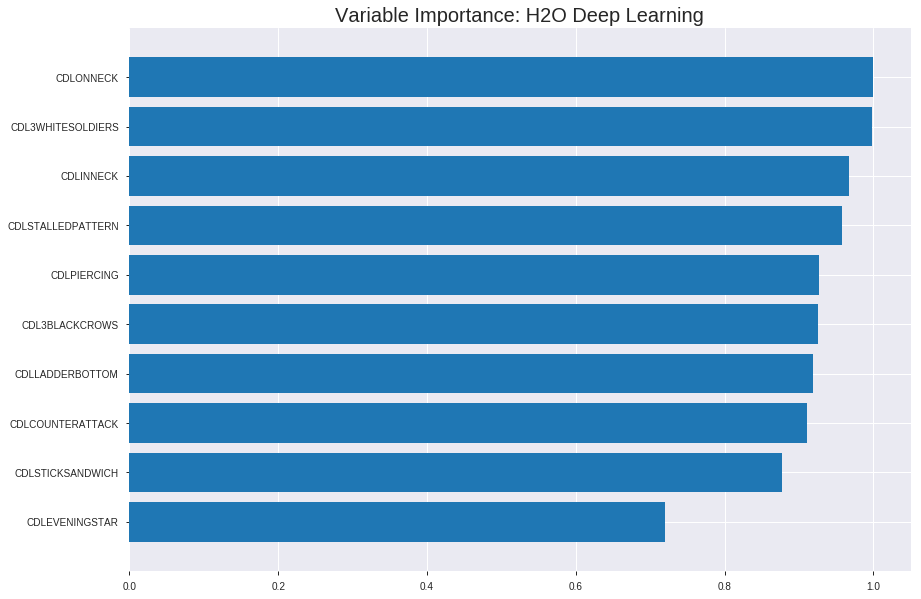

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_165708_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18191344913816734
RMSE: 0.4265131289165286
LogLoss: 0.5483664166386674
Mean Per-Class Error: 0.26593196520695384
AUC: 0.8025027094153692
pr_auc: 0.7770703749325909
Gini: 0.6050054188307383
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37734946171006545: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      513  346   0.4028   (346.0/859.0)
1      137  732   0.1577   (137.0/869.0)
Total  650  1078  0.2795   (483.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377349     0.751926  250
max f2                       0.144624     0.853609  340
max f0point5                 0.595902     0.739575  166
max accuracy                 0.458638     0.734375  219
max precision                0.938547     0.924051  20
max recall                   0.0213334    1         392
max specificity              0.99982      0.998836  0
max absolute_mcc             0.458638     0.470924  219
max min_per_class_accuracy   0.515016     0.729919  198
max mean_per_class_accuracy  0.458638     0.734068  219

Gains/Lift Table: Avg response rate: 50.29 %, avg score: 49.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.987909           1.76755   1.76755            0.888889         0.995941   0.888889                    0.995941            0.018412        0.018412                   76.7549   76.7549
    2        0.0202546                   0.968107           1.52061   1.64761            0.764706         0.975724   0.828571                    0.986121            0.0149597       0.0333717                  52.0612   64.7608
    3        0.0300926                   0.95587            1.98849   1.75905            1                0.961797   0.884615                    0.978169            0.0195627       0.0529344                  98.8493   75.9051
    4        0.0405093                   0.945153           1.98849   1.81805            1                0.951263   0.914286                    0.97125             0.0207135       0.0736479                  98.8493   81.805
    5        0.0503472                   0.930739           1.87152   1.8285             0.941176         0.937127   0.91954                     0.964582            0.018412        0.0920598                  87.1522   82.8499
    6        0.100116                    0.883999           1.64166   1.73562            0.825581         0.907572   0.872832                    0.936242            0.0817031       0.173763                   64.1662   73.5621
    7        0.150463                    0.834976           1.66851   1.71316            0.83908          0.860218   0.861538                    0.910803            0.0840046       0.257768                   66.8505   71.3163
    8        0.200231                    0.791777           1.64166   1.69539            0.825581         0.815407   0.852601                    0.887092            0.0817031       0.339471                   64.1662   69.5391
    9        0.300347                    0.710489           1.43677   1.60918            0.722543         0.747865   0.809249                    0.840683            0.143843        0.483314                   43.6772   60.9185
    10       0.399884                    0.615394           1.32952   1.53957            0.668605         0.663827   0.77424                     0.796661            0.132336        0.61565                    32.9515   53.9571
    11       0.5                         0.51736            1.11494   1.45455            0.560694         0.568706   0.731481                    0.751017            0.111623        0.727273                   11.4935   45.4545
    12       0.600116                    0.400703           0.919534  1.36529            0.462428         0.460089   0.686596                    0.702482            0.0920598       0.819333                   -8.04659  36.5291
    13       0.699653                    0.296965           0.739904  1.27632            0.372093         0.34864    0.641853                    0.652142            0.0736479       0.89298                    -26.0096  27.6319
    14       0.799769                    0.182908           0.586203  1.18993            0.294798         0.238634   0.598408                    0.600379            0.0586881       0.951669                   -41.3797  18.993
    15       0.899884                    0.0948943          0.27586   1.08824            0.138728         0.138212   0.547267                    0.548961            0.027618        0.979287                   -72.414   8.82361
    16       1                           0.00106948         0.206895  1                  0.104046         0.0489589  0.502894                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3277219384549245
RMSE: 0.5724700328007786
LogLoss: 1.0402864517682668
Mean Per-Class Error: 0.4810596113445378
AUC: 0.4944852941176471
pr_auc: 0.5133084705535542
Gini: -0.011029411764705843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.008596024512444287: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    236  0.9916   (236.0/238.0)
1      1    255  0.0039   (1.0/256.0)
Total  3    491  0.4798   (237.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00859602   0.682731   396
max f2                       0.001856     0.843215   399
max f0point5                 0.00859602   0.574324   396
max accuracy                 0.438907     0.520243   208
max precision                0.868548     0.577778   37
max recall                   0.001856     1          399
max specificity              0.999972     0.983193   0
max absolute_mcc             0.988205     0.0900643  2
max min_per_class_accuracy   0.468833     0.503906   197
max mean_per_class_accuracy  0.438907     0.51894    208

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 47.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.999238           0.385938  0.385938           0.2              0.999972   0.2                         0.999972            0.00390625      0.00390625                 -61.4062  -61.4062
    2        0.0202429                   0.960605           1.15781   0.771875           0.6              0.98281    0.4                         0.991391            0.0117188       0.015625                   15.7812   -22.8125
    3        0.0303644                   0.94209            1.54375   1.02917            0.8              0.952787   0.533333                    0.978523            0.015625        0.03125                    54.375    2.91667
    4        0.0404858                   0.930113           0.771875  0.964844           0.4              0.938199   0.5                         0.968442            0.0078125       0.0390625                  -22.8125  -3.51562
    5        0.0506073                   0.910557           0.771875  0.92625            0.4              0.918818   0.48                        0.958517            0.0078125       0.046875                   -22.8125  -7.375
    6        0.101215                    0.857102           1.235     1.08063            0.64             0.884262   0.56                        0.921389            0.0625          0.109375                   23.5      8.0625
    7        0.149798                    0.802692           0.964844  1.04307            0.5              0.82921    0.540541                    0.891493            0.046875        0.15625                    -3.51562  4.30743
    8        0.200405                    0.745303           1.00344   1.03307            0.52             0.77833    0.535354                    0.862917            0.0507812       0.207031                   0.34375   3.3065
    9        0.299595                    0.648715           0.984534  1.017              0.510204         0.698373   0.527027                    0.80844             0.0976562       0.304688                   -1.54656  1.69975
    10       0.40081                     0.564761           1.00344   1.01357            0.52             0.605598   0.525253                    0.757217            0.101562        0.40625                    0.34375   1.35732
    11       0.5                         0.468014           0.984534  1.00781            0.510204         0.520347   0.522267                    0.710226            0.0976562       0.503906                   -1.54656  0.78125
    12       0.59919                     0.393346           1.02392   1.01048            0.530612         0.429135   0.523649                    0.663695            0.101562        0.605469                   2.39158   1.04783
    13       0.700405                    0.302767           0.810469  0.981575           0.42             0.344998   0.508671                    0.61764             0.0820312       0.6875                     -18.9531  -1.84249
    14       0.799595                    0.20692            0.984534  0.981942           0.510204         0.25368    0.508861                    0.572491            0.0976562       0.785156                   -1.54656  -1.80578
    15       0.898785                    0.108017           0.984534  0.982228           0.510204         0.150913   0.509009                    0.525965            0.0976562       0.882812                   -1.54656  -1.77717
    16       1                           0.001856           1.15781   1                  0.6              0.0568764  0.518219                


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:58:58  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 16:59:04  7.282 sec         347 obs/sec       1.34954   1             2332       0.598759         1.30393             -0.4341        0.583481        0.557483           1.21519          0.473958                         0.638804           1.70581               -0.634451        0.493763          0.512743             0                  0.469636
    2019-08-28 16:59:10  13.030 sec        393 obs/sec       2.71412   2             4690       0.652275         1.80222             -0.701909      0.590115        0.572345           1.32566          0.477431                         0.643075           1.88756               -0.656382        0.517685          0.5136               0.771875           0.461538
    2019-08-28 16:59:19  21.953 sec        459 obs/sec       5.40451   4             9339       0.53377          0.898835            -0.139681      0.631089        0.615475           1.43613          0.463542                         0.604312           1.28578               -0.462714        0.485163          0.500993             0.771875           0.481781
    2019-08-28 16:59:27  29.280 sec        516 obs/sec       8.11111   6             14016      0.551719         0.9453              -0.217617      0.688223        0.669806           1.65708          0.404514                         0.602067           1.26246               -0.451866        0.500648          0.524483             0.385938           0.473684
    2019-08-28 16:59:33  35.627 sec        567 obs/sec       10.82     8             18697      0.532109         0.885296            -0.132599      0.735257        0.72847            1.65708          0.334491                         0.616579           1.36463               -0.522699        0.483021          0.504862             0.771875           0.481781
    2019-08-28 16:59:38  41.255 sec        615 obs/sec       13.5318   10            23383      0.471236         0.669495            0.111716       0.742045        0.712873           1.43613          0.347222                         0.574766           1.10253               -0.323181        0.464909          0.490537             0.385938           0.479757
    2019-08-28 16:59:46  48.706 sec        676 obs/sec       17.5966   13            30407      0.426513         0.548366            0.272322       0.802503        0.77707            1.76755          0.279514                         0.57247            1.04029               -0.31263         0.494485          0.513308             0.385938           0.479757
    2019-08-28 16:59:53  55.627 sec        727 obs/sec       21.5891   16            37306      0.410936         0.513779            0.324505       0.841189        0.824338           1.76755          0.241898                         0.590057           1.09023               -0.394522        0.480058          0.499998             0.385938           0.477733
    2019-08-28 17:00:00

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLONNECK          1.0                    1.0                  0.03665110753209558
CDL3WHITESOLDIERS  0.9983044266700745     0.9983044266700745   0.03658896289165192
CDLINNECK          0.9674356579780579     0.9674356579780579   0.035457588330937435
CDLSTALLEDPATTERN  0.9581086039543152     0.9581086039543152   0.03511574147095558
CDLPIERCING        0.926605761051178      0.926605761051178    0.03396112738814598
---                ---                    ---                  ---
aroondown_12       0.4138989746570587     0.4138989746570587   0.01516985582757996
weekofyear         0.40962445735931396    0.40962445735931396  0.015013190034452515
CDLDOJI            0.4017506241798401     0.4017506241798401   0.014724605327901836
week               0.39934849739074707    0.39934849739074707  0.01463656472064906
quarter            0.3924270570278168     0.3924270570278168   0.014382886265630316


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6275303643724697)

('F1', 0.5763688760806917)

('auc', 0.577687074829932)

('logloss', 0.8966037202166517)

('mean_per_class_error', 0.4074489795918368)

('rmse', 0.5185026803082824)

('mse', 0.26884502948687294)

deeplearning prediction progress: |███████████████████████████████████████| 100%


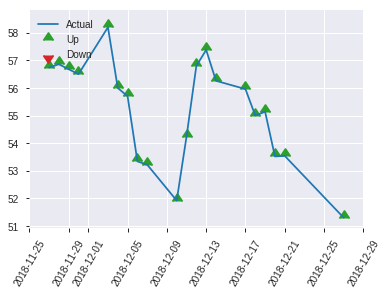


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.26884502948687294
RMSE: 0.5185026803082824
LogLoss: 0.8966037202166517
Mean Per-Class Error: 0.4074489795918368
AUC: 0.577687074829932
pr_auc: 0.476364707950113
Gini: 0.15537414965986396
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00677165493113388: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    147  1        (147.0/147.0)
1      0    100  0        (0.0/100.0)
Total  0    247  0.5951   (147.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00677165   0.576369  246
max f2                       0.00677165   0.772798  246
max f0point5                 0.559873     0.516827  78
max accuracy                 0.6257       0.62753   55
max precision                0.911962     0.75      3
max recall                   0.00677165   1         246
max specificity              1            0.993197  0
max absolute_mcc             0.57032      0.19692   71
max min_per_class_accuracy   0.417045     0.55      119
max mean_per_class_accuracy  0.559873     0.592551  78

Gains/Lift Table: Avg response rate: 40.49 %, avg score: 41.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.920012           1.64667   1.64667            0.666667         0.975609   0.666667                    0.975609            0.02            0.02                       64.6667   64.6667
    2        0.0202429                   0.896028           1.235     1.482              0.5              0.907286   0.6                         0.94828             0.01            0.03                       23.5      48.2
    3        0.0323887                   0.88371            1.64667   1.54375            0.666667         0.890932   0.625                       0.926774            0.02            0.05                       64.6667   54.375
    4        0.0404858                   0.865453           0         1.235              0                0.879166   0.5                         0.917253            0               0.05                       -100      23.5
    5        0.0526316                   0.828684           0.823333  1.14               0.333333         0.841965   0.461538                    0.899879            0.01            0.06                       -17.6667  14
    6        0.101215                    0.754739           1.235     1.1856             0.5              0.780427   0.48                        0.842542            0.06            0.12                       23.5      18.56
    7        0.149798                    0.699112           1.235     1.20162            0.5              0.734878   0.486486                    0.807624            0.06            0.18                       23.5      20.1622
    8        0.202429                    0.643236           1.52      1.2844             0.615385         0.67772    0.52                        0.773849            0.08            0.26                       52        28.44
    9        0.299595                    0.565093           1.44083   1.33514            0.583333         0.601812   0.540541                    0.718053            0.14            0.4                        44.0833   33.5135
    10       0.40081                     0.490894           0.7904    1.19758            0.32             0.52405    0.484848                    0.669063            0.08            0.48                       -20.96    19.7576
    11       0.502024                    0.397062           0.7904    1.11548            0.32             0.443976   0.451613                    0.623682            0.08            0.56                       -20.96    11.5484
    12       0.59919                     0.311839           0.92625   1.0848             0.375            0.352064   0.439189                    0.579636            0.09            0.65                       -7.375    8.47973
    13       0.700405                    0.251283           0.988     1.07081            0.4              0.286673   0.433526                    0.5373              0.1             0.75                       -1.2      7.08092
    14       0.797571                    0.171864           1.02917   1.06574            0.416667         0.21491    0.431472                    0.498024            0.1             0.85                       2.91667   6.5736
    15       0.898785                    0.104129           0.5928    1.01248            0.24             0.135278   0.40991                     0.457175            0.06            0.91                       -40.72    1.24775
    16       1                           0.00677165         0.8892    1                  0.36             0.0645583  0.404858                    0.417436        

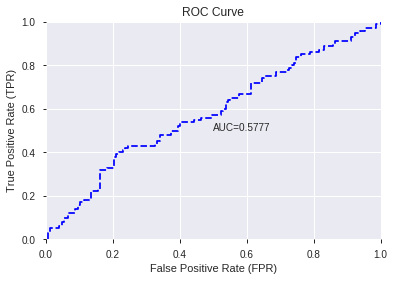

This function is available for GLM models only


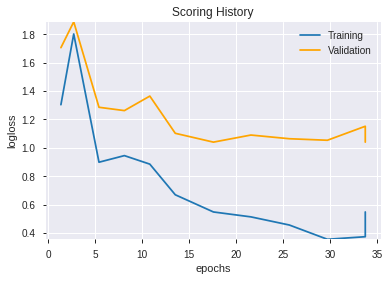

--2019-08-28 17:04:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_165708_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_165708_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a241',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLONNECK',
 'CDL3WHITESOLDIERS',
 'CDLINNECK',
 'CDLSTALLEDPATTERN',
 'CDLPIERCING',
 'CDL3BLACKCROWS',
 'CDLLADDERBOTTOM',
 'CDLCOUNTERATTACK',
 'CDLSTICKSANDWICH',
 'CDLEVENINGSTAR',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLHAMMER',
 'is_month_start',
 'CORREL_24',
 'DX_8',
 'day',
 'SIN',
 'CDLSPINNINGTOP',
 'BOP',
 'CORREL_8',
 'weekday_name',
 'weekday',
 'CDLRICKSHAWMAN',
 'dayofweek',
 'OBV',
 'COS',
 'BETA_12',
 'HT_DCPERIOD',
 'BETA_24',
 'HT_TRENDMODE',
 'AROONOSC_14',
 'aroondown_8',
 'STOCHRSI_fastd',
 'SAREXT',
 'STOCHF_fastk',
 'CDLLONGLEGGEDDOJI',
 'dayofyear',
 'BETA_20',
 'BETA_8',
 'aroondown_14',
 'days_in_month',
 'STOCHRSI_fastk',
 'month',
 'STOCH_slowd',
 'aroondown_12',
 'weekofyear',
 'CDLDOJI',
 'week',
 'quarter']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_170446_model_1  0.527619  0.692805              0.453367  0.499827  0.249827

variable  relative_importance  scaled_importance  percentage
0                 BOP             0.008850           1.000000    0.060778
1                 OBV             0.008812           0.995724    0.060518
2   CDLINVERTEDHAMMER             0.007375           0.833328    0.050648
3        STOCHF_fastk             0.007187           0.812078    0.049356
4           CDLHAMMER             0.006739           0.761519    0.046283
5      STOCHRSI_fastk             0.005978           0.675462    0.041053
6        HT_TRENDMODE             0.005632           0.636448    0.038682
7           CORREL_24             0.005291           0.597899    0.036339
8                DX_8             0.004985           0.563279    0.034235
9              BETA_8             0.004331           0.489412    0.029745
10          CDLINNECK             0.004258           0.481129    0.029242
11     is_month_start             0.004197           0.474259    0.028824
12            BETA_24             0.004170           0.471222    0.028640
13  CDLSTALLEDPATTERN             0.004168           0.471029    0.028628
14               week             0.003701           0.418195    0.025417
15         weekofyear             0.003697           0.417738    0.025389
16       aroondown_12             0.003611           0.408010    0.024798
17            quarter             0.003457           0.390673    0.023744
18     CDLEVENINGSTAR             0.003379           0.381798    0.023205
19            BETA_20             0.003304           0.373327    0.022690
20       aroondown_14             0.003169           0.358077    0.021763
21  CDL3WHITESOLDIERS             0.003092           0.349339    0.021232
22          dayofyear             0.002931           0.331145    0.020126
23          CDLONNECK             0.002923           0.330248    0.020072
24              month             0.002739           0.309542    0.018813
25     CDLRICKSHAWMAN             0.002650           0.299401    0.018197
26  CDLLONGLEGGEDDOJI             0.002186           0.247005    0.015012
27                day             0.002080           0.235011    0.014283
28            CDLDOJI             0.001942           0.219406    0.013335
29    CDLLADDERBOTTOM             0.001855           0.209607    0.012739
30   CDLSTICKSANDWICH             0.001841           0.208046    0.012645
31                SIN             0.001817           0.205318    0.012479
32                COS             0.001774           0.200512    0.012187
33        STOCH_slowd             0.001760           0.198837    0.012085
34     CDLSPINNINGTOP             0.001543           0.174364    0.010597
35        AROONOSC_14             0.001442           0.162918    0.009902
36      CDLHANGINGMAN             0.001225           0.138463    0.008415
37        HT_DCPERIOD             0.001218           0.137643    0.008366
38     STOCHRSI_fastd             0.001208           0.136489    0.008295
39      days_in_month             0.000998           0.112754    0.006853
40            BETA_12             0.000525           0.059339    0.003606
41             SAREXT             0.000394           0.044489    0.002704
42        aroondown_8             0.000324           0.036650    0.002227
43       weekday_name             0.000264           0.029786    0.001810
44           CORREL_8             0.000224           0.025298    0.001538
45          dayofweek             0.000121           0.013650    0.000830
46            weekday             0.000117           0.013187    0.000801
47        CDLPIERCING             0.000099           0.011219    0.000682
48     CDL3BLACKCROWS             0.000028           0.003129    0.000190
49   CDLCOUNTERATTACK             0.000000           0.000000    0.000000

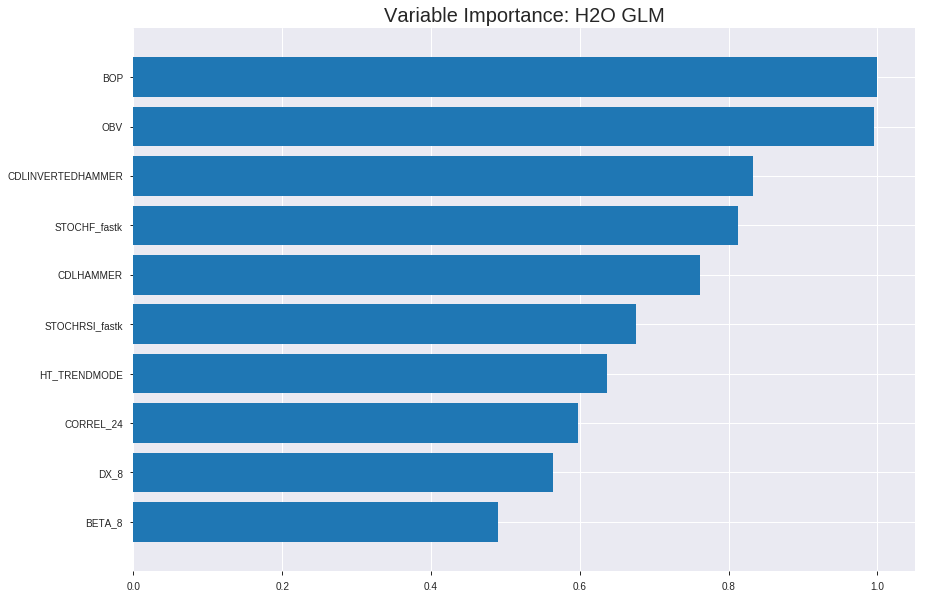

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_170446_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24864494628979833
RMSE: 0.4986431051260995
LogLoss: 0.690435805767128
Null degrees of freedom: 1727
Residual degrees of freedom: 1678
Null deviance: 2395.458785321781
Residual deviance: 2386.1461447311945
AIC: 2486.1461447311945
AUC: 0.5880282020333006
pr_auc: 0.5955668992093477
Gini: 0.17605640406660128
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48373888920084185: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      25   834   0.9709   (834.0/859.0)
1      8    861   0.0092   (8.0/869.0)
Total  33   1695  0.4873   (842.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483739     0.671607  377
max f2                       0.469939     0.834935  399
max f0point5                 0.499946     0.576813  229
max accuracy                 0.503563     0.568287  184
max precision                0.550557     1         0
max recall                   0.469939     1         399
max specificity              0.550557     1         0
max absolute_mcc             0.51229      0.148972  75
max min_per_class_accuracy   0.503219     0.568102  189
max mean_per_class_accuracy  0.503563     0.5684    184

Gains/Lift Table: Avg response rate: 50.29 %, avg score: 50.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.520038           1.76755   1.76755            0.888889         0.526475  0.888889                    0.526475            0.018412        0.018412                   76.7549   76.7549
    2        0.0202546                   0.518805           1.52061   1.64761            0.764706         0.519445  0.828571                    0.523061            0.0149597       0.0333717                  52.0612   64.7608
    3        0.0300926                   0.517756           1.28667   1.52961            0.647059         0.518276  0.769231                    0.521497            0.0126582       0.0460299                  28.6672   52.961
    4        0.0405093                   0.516792           1.32566   1.47717            0.666667         0.517234  0.742857                    0.520401            0.013809        0.0598389                  32.5662   47.7166
    5        0.0503472                   0.51608            1.40364   1.4628             0.705882         0.516381  0.735632                    0.519615            0.013809        0.0736479                  40.3642   46.2799
    6        0.100116                    0.513983           1.31795   1.3908             0.662791         0.515134  0.699422                    0.517388            0.0655926       0.139241                   31.7954   39.0795
    7        0.150463                    0.512033           1.25709   1.34606            0.632184         0.513009  0.676923                    0.515922            0.0632911       0.202532                   25.7093   34.6056
    8        0.200231                    0.510258           0.901758  1.23562            0.453488         0.51104   0.621387                    0.514709            0.0448792       0.247411                   -9.82418  23.5624
    9        0.300347                    0.507555           1.02298   1.16474            0.514451         0.508826  0.585742                    0.512748            0.102417        0.349827                   2.29817   16.4743
    10       0.399884                    0.505486           0.982685  1.11943            0.494186         0.506569  0.562952                    0.51121             0.0978136       0.447641                   -1.73147  11.9426
    11       0.5                         0.503202           1.20689   1.13694            0.606936         0.504315  0.571759                    0.509829            0.120829        0.56847                    20.6889   13.6939
    12       0.600116                    0.500851           0.90804   1.09875            0.456647         0.502002  0.552555                    0.508523            0.0909091       0.659379                   -9.19601  9.87524
    13       0.699653                    0.498698           0.855514  1.06415            0.430233         0.499685  0.535153                    0.507266            0.0851554       0.744534                   -14.4486  6.41478
    14       0.799769                    0.49587            0.965511  1.0518             0.485549         0.497281  0.528944                    0.506016            0.0966628       0.841197                   -3.44892  5.18003
    15       0.899884                    0.49148            0.896546  1.03453            0.450867         0.493962  0.520257                    0.504675            0.0897583       0.930955                   -10.3454  3.45276
    16       1                           0.469939           0.689651  1                  0.346821         0.48688   0.502894                    0.502894          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24990942284535422
RMSE: 0.4999094146396467
LogLoss: 0.6929668579862626
Null degrees of freedom: 493
Residual degrees of freedom: 444
Null deviance: 684.6376229712456
Residual deviance: 684.6512556904274
AIC: 784.6512556904274
AUC: 0.5049812893907563
pr_auc: 0.5123648078452313
Gini: 0.009962578781512521
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48178256141857334: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    233  0.979    (233.0/238.0)
1      2    254  0.0078   (2.0/256.0)
Total  7    487  0.4757   (235.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.481783     0.683715   392
max f2                       0.469422     0.843215   399
max f0point5                 0.494691     0.582474   331
max accuracy                 0.494727     0.544534   330
max precision                0.515063     0.583333   21
max recall                   0.469422     1          399
max specificity              0.546332     0.995798   0
max absolute_mcc             0.517826     0.0900643  6
max min_per_class_accuracy   0.503769     0.492188   195
max mean_per_class_accuracy  0.494727     0.53189    330

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 50.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.518662           0.385938  0.385938           0.2              0.535891  0.2                         0.535891            0.00390625      0.00390625                 -61.4062  -61.4062
    2        0.0202429                   0.517405           0.771875  0.578906           0.4              0.517733  0.3                         0.526812            0.0078125       0.0117188                  -22.8125  -42.1094
    3        0.0303644                   0.516317           1.54375   0.900521           0.8              0.517116  0.466667                    0.52358             0.015625        0.0273438                  54.375    -9.94792
    4        0.0404858                   0.515421           1.54375   1.06133            0.8              0.515959  0.55                        0.521675            0.015625        0.0429688                  54.375    6.13281
    5        0.0506073                   0.514899           1.15781   1.08063            0.6              0.51514   0.56                        0.520368            0.0117188       0.0546875                  15.7812   8.0625
    6        0.101215                    0.512855           0.92625   1.00344            0.48             0.513696  0.52                        0.517032            0.046875        0.101562                   -7.375    0.34375
    7        0.149798                    0.511569           0.88444   0.964844           0.458333         0.512214  0.5                         0.515469            0.0429688       0.144531                   -11.556   -3.51562
    8        0.200405                    0.510017           1.08063   0.994081           0.56             0.510855  0.515152                    0.514304            0.0546875       0.199219                   8.0625    -0.591856
    9        0.299595                    0.507678           0.945153  0.977882           0.489796         0.508896  0.506757                    0.512513            0.09375         0.292969                   -5.48469  -2.21178
    10       0.40081                     0.505553           1.04203   0.994081           0.54             0.506593  0.515152                    0.511018            0.105469        0.398438                   4.20312   -0.591856
    11       0.5                         0.50372            0.945153  0.984375           0.489796         0.504704  0.510121                    0.509766            0.09375         0.492188                   -5.48469  -1.5625
    12       0.59919                     0.50166            0.984534  0.984401           0.510204         0.502563  0.510135                    0.508573            0.0976562       0.589844                   -1.54656  -1.55986
    13       0.700405                    0.499516           1.19641   1.01504            0.62             0.500547  0.526012                    0.507414            0.121094        0.710938                   19.6406   1.50379
    14       0.799595                    0.496765           1.10268   1.02591            0.571429         0.498327  0.531646                    0.506286            0.109375        0.820312                   10.2679   2.59098
    15       0.898785                    0.492853           0.905772  1.01265            0.469388         0.494749  0.524775                    0.505013            0.0898438       0.910156                   -9.42283  1.26513
    16       1                           0.469422           0.887656  1                  0.46             0.487846  0.518219                    0.503276


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 17:04:46  0.000 sec   2            3.7       50            1.38087           1.38593
    2019-08-28 17:04:46  0.018 sec   4            2.3       50            1.37831           1.38626
    2019-08-28 17:04:46  0.043 sec   6            1.4       50            1.37492           1.38706
    2019-08-28 17:04:46  0.064 sec   8            0.89      51            1.37072           1.38868
    2019-08-28 17:04:46  0.091 sec   10           0.55      51            1.3659            1.39161

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6396761133603239)

('F1', 0.5886075949367089)

('auc', 0.5276190476190477)

('logloss', 0.6928053902309971)

('mean_per_class_error', 0.4340136054421768)

('rmse', 0.4998273743333595)

('mse', 0.24982740413298027)

glm prediction progress: |████████████████████████████████████████████████| 100%


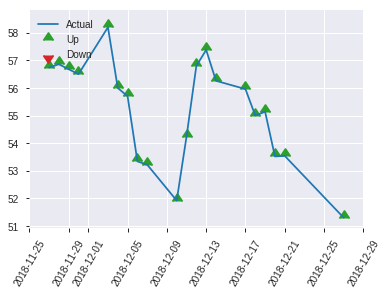


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24982740413298027
RMSE: 0.4998273743333595
LogLoss: 0.6928053902309971
Null degrees of freedom: 246
Residual degrees of freedom: 197
Null deviance: 342.9669668693666
Residual deviance: 342.2458627741125
AIC: 442.2458627741125
AUC: 0.5276190476190477
pr_auc: 0.46970027591799207
Gini: 0.05523809523809531
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49139248175474354: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      24   123  0.8367   (123.0/147.0)
1      7    93   0.07     (7.0/100.0)
Total  31   216  0.5263   (130.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.491392     0.588608  215
max f2                       0.485118     0.775862  237
max f0point5                 0.491392     0.482365  215
max accuracy                 0.514301     0.639676  18
max precision                0.517164     0.8       4
max recall                   0.482324     1         244
max specificity              0.574375     0.993197  0
max absolute_mcc             0.514301     0.22619   18
max min_per_class_accuracy   0.501866     0.48      123
max mean_per_class_accuracy  0.511748     0.565986  29

Gains/Lift Table: Avg response rate: 40.49 %, avg score: 50.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.518748           1.64667   1.64667            0.666667         0.546054  0.666667                    0.546054            0.02            0.02                       64.6667   64.6667
    2        0.0202429                   0.517158           2.47      1.976              1                0.517424  0.8                         0.534602            0.02            0.04                       147       97.6
    3        0.0323887                   0.515836           1.64667   1.8525             0.666667         0.516344  0.75                        0.527755            0.02            0.06                       64.6667   85.25
    4        0.0404858                   0.515735           1.235     1.729              0.5              0.51582   0.7                         0.525368            0.01            0.07                       23.5      72.9
    5        0.0526316                   0.515327           1.64667   1.71               0.666667         0.515595  0.692308                    0.523113            0.02            0.09                       64.6667   71
    6        0.101215                    0.512119           1.44083   1.5808             0.583333         0.51374   0.64                        0.518614            0.07            0.16                       44.0833   58.08
    7        0.149798                    0.51071            1.235     1.46865            0.5              0.511466  0.594595                    0.516296            0.06            0.22                       23.5      46.8649
    8        0.202429                    0.509005           0.38      1.1856             0.153846         0.509655  0.48                        0.514569            0.02            0.24                       -62       18.56
    9        0.299595                    0.506388           0.720417  1.03473            0.291667         0.507722  0.418919                    0.512348            0.07            0.31                       -27.9583  3.47297
    10       0.40081                     0.503947           1.0868    1.04788            0.44             0.505259  0.424242                    0.510558            0.11            0.42                       8.68      4.78788
    11       0.502024                    0.501866           0.5928    0.956129           0.24             0.502852  0.387097                    0.509005            0.06            0.48                       -40.72    -4.3871
    12       0.59919                     0.4994             1.235     1.00135            0.5              0.500309  0.405405                    0.507594            0.12            0.6                        23.5      0.135135
    13       0.700405                    0.497155           0.8892    0.985145           0.36             0.498237  0.398844                    0.506242            0.09            0.69                       -11.08    -1.48555
    14       0.797571                    0.494443           1.33792   1.02812            0.541667         0.495791  0.416244                    0.504969            0.13            0.82                       33.7917   2.81218
    15       0.898785                    0.490517           1.1856    1.04586            0.48             0.492666  0.423423                    0.503583            0.12            0.94                       18.56     4.58559
    16       1                           0.476404           0.5928    1                  0.24             0.485835  0.404858                    0.501787            0.06        

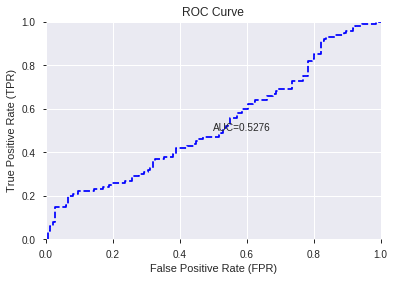

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


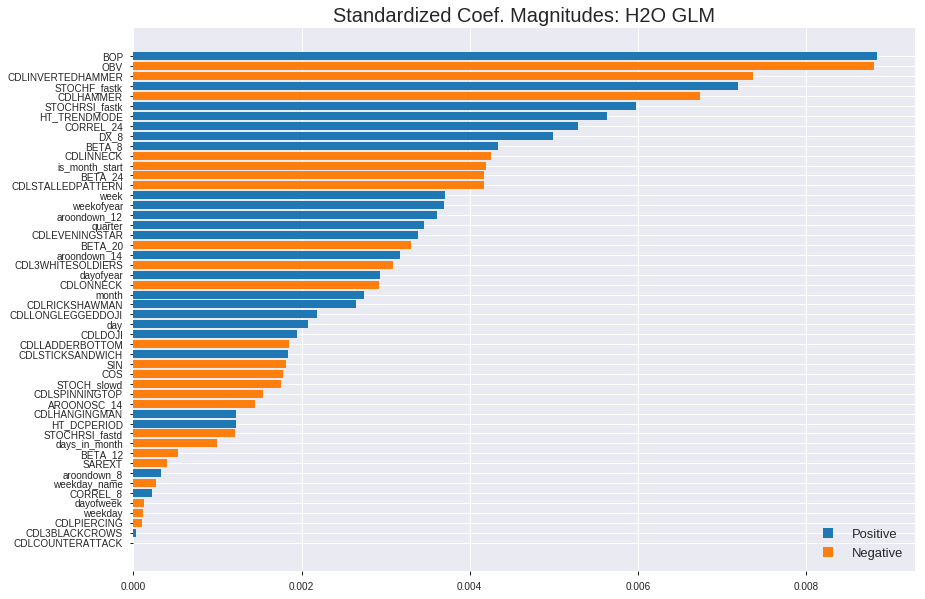

'log_likelihood'
--2019-08-28 17:04:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_170446_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_170446_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a241',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'OBV',
 'CDLINVERTEDHAMMER',
 'STOCHF_fastk',
 'CDLHAMMER',
 'STOCHRSI_fastk',
 'HT_TRENDMODE',
 'CORREL_24',
 'DX_8',
 'BETA_8',
 'CDLINNECK',
 'is_month_start',
 'BETA_24',
 'CDLSTALLEDPATTERN',
 'week',
 'weekofyear',
 'aroondown_12',
 'quarter',
 'CDLEVENINGSTAR',
 'BETA_20',
 'aroondown_14',
 'CDL3WHITESOLDIERS',
 'dayofyear',
 'CDLONNECK',
 'month',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'day',
 'CDLDOJI',
 'CDLLADDERBOTTOM',
 'CDLSTICKSANDWICH',
 'SIN',
 'COS',
 'STOCH_slowd',
 'CDLSPINNINGTOP',
 'AROONOSC_14',
 'CDLHANGINGMAN',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'days_in_month',
 'BETA_12',
 'SAREXT',
 'aroondown_8',
 'weekday_name',
 'CORREL_8',
 'dayofweek',
 'weekday',
 'CDLPIERCING',
 'CDL3BLACKCROWS',
 'CDLCOUNTERATTACK']

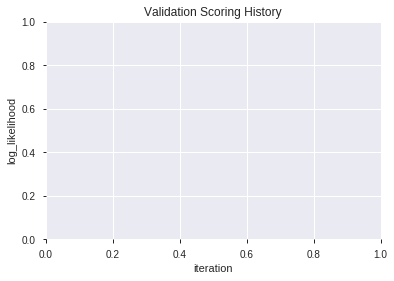

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_170459_model_3  0.603605  0.670283              0.469184  0.488618  0.238748
1               XGBoost_2_AutoML_20190828_170459  0.582789  0.676760              0.500000  0.491720  0.241788
2  XGBoost_grid_1_AutoML_20190828_170459_model_4  0.577143  0.678971              0.481190  0.492898  0.242949
3               XGBoost_1_AutoML_20190828_170459  0.572381  0.682995              0.500000  0.494478  0.244509
4  XGBoost_grid_1_AutoML_20190828_170459_model_2  0.566599  0.681842              0.500000  0.494250  0.244283
5  XGBoost_grid_1_AutoML_20190828_170459_model_6  0.559864  0.685549              0.439150  0.496136  0.246151
6               XGBoost_3_AutoML_20190828_170459  0.555442  0.680922              0.486395  0.493937  0.243974
7  XGBoost_grid_1_AutoML_20190828_170459_model_7  0.549524  0.693146              0.470782  0.499818  0.249818
8  XGBoost_grid_1_AutoML_20190828_170459_model_5  0.547755  0.697548              0.493197  0.501325  0.251327
9  XGBoost_grid_1_AutoML_20190828_170459_model_1  0.539116  0.691914              0.496599  0.499252  0.249252

variable  relative_importance  scaled_importance  percentage
0                 OBV           358.950775           1.000000    0.073153
1                 BOP           279.315613           0.778145    0.056924
2        STOCHF_fastk           273.389709           0.761636    0.055716
3            CORREL_8           270.390259           0.753279    0.055105
4              BETA_8           268.880798           0.749074    0.054797
5             BETA_24           249.240234           0.694358    0.050795
6           CORREL_24           246.334518           0.686263    0.050202
7                 COS           245.759766           0.684661    0.050085
8           dayofyear           241.426407           0.672589    0.049202
9         STOCH_slowd           233.106293           0.649410    0.047507
10     STOCHRSI_fastd           194.280243           0.541245    0.039594
11        HT_DCPERIOD           193.438583           0.538900    0.039422
12            BETA_12           188.532745           0.525233    0.038423
13               DX_8           175.474930           0.488855    0.035761
14                SIN           168.155273           0.468463    0.034270
15             SAREXT           166.500977           0.463855    0.033933
16                day           155.753815           0.433914    0.031742
17            BETA_20           136.973007           0.381593    0.027915
18        AROONOSC_14           118.717690           0.330735    0.024194
19               week           106.701637           0.297260    0.021746
20       aroondown_12           102.993484           0.286929    0.020990
21       aroondown_14           102.692268           0.286090    0.020928
22        aroondown_8            77.047493           0.214646    0.015702
23     STOCHRSI_fastk            72.152267           0.201009    0.014704
24          dayofweek            65.270035           0.181836    0.013302
25       weekday_name            62.711430           0.174708    0.012780
26     CDLSPINNINGTOP            23.973766           0.066788    0.004886
27      days_in_month            23.143698           0.064476    0.004717
28         weekofyear            22.873304           0.063723    0.004662
29            weekday            20.928436           0.058304    0.004265
30            CDLDOJI            18.448669           0.051396    0.003760
31     CDLRICKSHAWMAN            13.601381           0.037892    0.002772
32          CDLHAMMER            11.810403           0.032903    0.002407
33              month             6.289310           0.017521    0.001282
34  CDLINVERTEDHAMMER             5.131526           0.014296    0.001046
35       HT_TRENDMODE             4.198635           0.011697    0.000856
36            quarter             2.239510           0.006239    0.000456

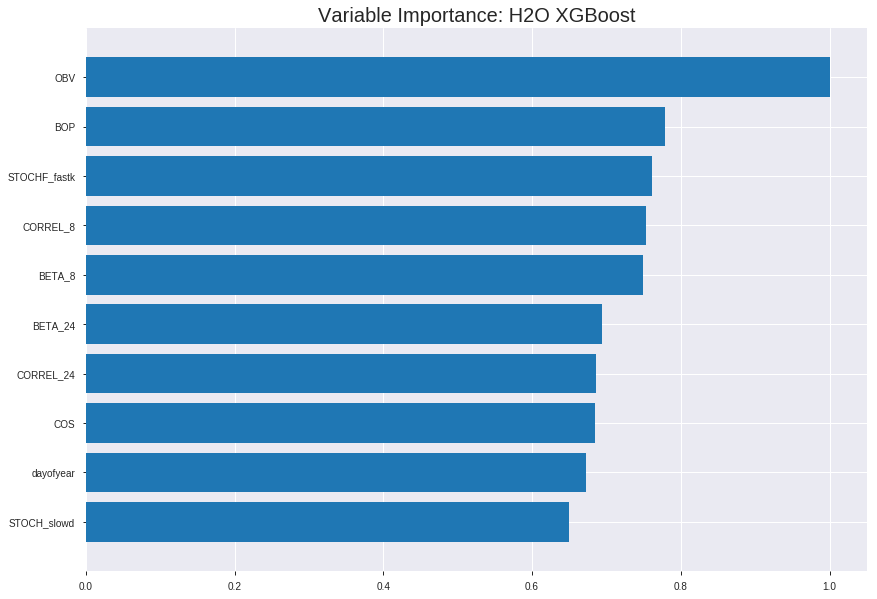

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_170459_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18580391600374302
RMSE: 0.4310497836720754
LogLoss: 0.5608026363531542
Mean Per-Class Error: 0.17211184359472775
AUC: 0.9060318485245911
pr_auc: 0.9070304426176137
Gini: 0.8120636970491821
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48819565773010254: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      676  183  0.213    (183.0/859.0)
1      114  755  0.1312   (114.0/869.0)
Total  790  938  0.1719   (297.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488196     0.835639  217
max f2                       0.432081     0.890542  272
max f0point5                 0.541256     0.837989  165
max accuracy                 0.488196     0.828125  217
max precision                0.79886      1         0
max recall                   0.305697     1         377
max specificity              0.79886      1         0
max absolute_mcc             0.488196     0.658184  217
max min_per_class_accuracy   0.500854     0.821634  204
max mean_per_class_accuracy  0.488196     0.827888  217

Gains/Lift Table: Avg response rate: 50.29 %, avg score: 50.24 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.73706            1.98849    1.98849            1                0.76313   1                           0.76313             0.0207135       0.0207135                  98.8493   98.8493
    2        0.0202546                   0.72397            1.98849    1.98849            1                0.730716  1                           0.747386            0.0195627       0.0402762                  98.8493   98.8493
    3        0.0300926                   0.712936           1.98849    1.98849            1                0.719459  1                           0.738256            0.0195627       0.0598389                  98.8493   98.8493
    4        0.0405093                   0.703567           1.87802    1.96009            0.944444         0.708104  0.985714                    0.730503            0.0195627       0.0794016                  87.8021   96.0085
    5        0.0503472                   0.695371           1.98849    1.96564            1                0.698689  0.988506                    0.724286            0.0195627       0.0989643                  98.8493   96.5636
    6        0.100116                    0.651103           1.96537    1.9655             0.988372         0.668286  0.988439                    0.696448            0.0978136       0.196778                   96.5371   96.5504
    7        0.150463                    0.627847           1.96564    1.96555            0.988506         0.639483  0.988462                    0.677387            0.0989643       0.295742                   96.5636   96.5548
    8        0.200231                    0.605499           1.75727    1.91378            0.883721         0.61695   0.962428                    0.662365            0.0874568       0.383199                   75.7272   91.378
    9        0.300347                    0.565425           1.72413    1.85056            0.867052         0.585569  0.930636                    0.636766            0.172612        0.555811                   72.4126   85.0562
    10       0.399884                    0.529698           1.41044    1.74101            0.709302         0.545853  0.875543                    0.614137            0.140391        0.696203                   41.0442   74.101
    11       0.5                         0.500579           1.22988    1.63867            0.618497         0.51484   0.824074                    0.594254            0.12313         0.819333                   22.9877   63.8665
    12       0.600116                    0.47               0.850569   1.50719            0.427746         0.485969  0.757956                    0.576189            0.0851554       0.904488                   -14.9431  50.7189
    13       0.699653                    0.435757           0.520245   1.36678            0.261628         0.453511  0.687345                    0.558736            0.0517837       0.956272                   -47.9755  36.678
    14       0.799769                    0.396776           0.333331   1.23741            0.16763          0.417358  0.622287                    0.541039            0.0333717       0.989643                   -66.6669  23.7412
    15       0.899884                    0.352954           0.0689651  1.10742            0.0346821        0.376226  0.556913                    0.522703            0.00690449      0.996548                   -93.1035  10.7418
    16       1                           0.224835           0.0344825  1                  0.017341         0.319834  0.502894                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2528534209172409
RMSE: 0.5028453250426426
LogLoss: 0.699057040251522
Mean Per-Class Error: 0.4542903098739496
AUC: 0.5219193146008403
pr_auc: 0.5337024403157368
Gini: 0.04383862920168058
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.334374338388443: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    232  0.9748   (232.0/238.0)
1      2    254  0.0078   (2.0/256.0)
Total  8    486  0.4737   (234.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.334374     0.684636   392
max f2                       0.314915     0.843215   399
max f0point5                 0.391527     0.578613   355
max accuracy                 0.514114     0.540486   145
max precision                0.669929     0.666667   2
max recall                   0.314915     1          399
max specificity              0.6875       0.995798   0
max absolute_mcc             0.514114     0.0952644  145
max min_per_class_accuracy   0.491898     0.512605   193
max mean_per_class_accuracy  0.514114     0.54571    145

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 48.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.643736           0.771875  0.771875           0.4              0.665468  0.4                         0.665468            0.0078125       0.0078125                  -22.8125  -22.8125
    2        0.0202429                   0.626776           0.771875  0.771875           0.4              0.637689  0.4                         0.651578            0.0078125       0.015625                   -22.8125  -22.8125
    3        0.0303644                   0.616386           1.15781   0.900521           0.6              0.62279   0.466667                    0.641982            0.0117188       0.0273438                  15.7812   -9.94792
    4        0.0404858                   0.609977           1.54375   1.06133            0.8              0.613101  0.55                        0.634762            0.015625        0.0429688                  54.375    6.13281
    5        0.0506073                   0.60158            0.771875  1.00344            0.4              0.60726   0.52                        0.629261            0.0078125       0.0507812                  -22.8125  0.34375
    6        0.101215                    0.580359           1.15781   1.08063            0.6              0.590205  0.56                        0.609733            0.0585938       0.109375                   15.7812   8.0625
    7        0.149798                    0.564438           1.20605   1.1213             0.625            0.57079   0.581081                    0.597103            0.0585938       0.167969                   20.6055   12.1305
    8        0.200405                    0.553339           0.92625   1.07205            0.48             0.559155  0.555556                    0.58752             0.046875        0.214844                   -7.375    7.20486
    9        0.299595                    0.525821           1.02392   1.05611            0.530612         0.539805  0.547297                    0.571723            0.101562        0.316406                   2.39158   5.61128
    10       0.40081                     0.508366           1.15781   1.08179            0.6              0.515919  0.560606                    0.557631            0.117188        0.433594                   15.7812   8.17945
    11       0.5                         0.491898           0.827009  1.03125            0.428571         0.499996  0.534413                    0.546197            0.0820312       0.515625                   -17.2991  3.125
    12       0.59919                     0.472321           0.86639   1.00396            0.44898          0.481512  0.52027                     0.535489            0.0859375       0.601562                   -13.361   0.395904
    13       0.700405                    0.45343            0.964844  0.998307           0.5              0.463257  0.517341                    0.525051            0.0976562       0.699219                   -3.51562  -0.169346
    14       0.799595                    0.429709           1.10268   1.01125            0.571429         0.441439  0.524051                    0.514679            0.109375        0.808594                   10.2679   1.1254
    15       0.898785                    0.395723           1.0633    1.017              0.55102          0.412442  0.527027                    0.503396            0.105469        0.914062                   6.32972   1.69975
    16       1                           0.314915           0.849062  1                  0.44             0.366711  0.518219                    0.489561       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:05:05  2.037 sec   0                  0.5              0.693147            0.5             0                  1                0.497106                         0.5                0.693147              0.5               0                    1                  0.481781
    2019-08-28 17:05:06  2.173 sec   5                  0.492045         0.677333            0.720429        0.719644           1.87802          0.398727                         0.499324           0.691794              0.530914          0.548973             1.54375            0.481781
    2019-08-28 17:05:06  2.262 sec   10                 0.482991         0.659536            0.782551        0.783815           1.98849          0.322338                         0.499178           0.691509              0.535214          0.528106             0.771875           0.481781
    2019-08-28 17:05:06  2.350 sec   15                 0.474645         0.643275            0.807805        0.806471           1.98849          0.275463                         0.499644           0.692449              0.527639          0.52738              1.15781            0.479757
    2019-08-28 17:05:06  2.429 sec   20                 0.467044         0.62863             0.831791        0.829265           1.98849          0.258681                         0.499456           0.692071              0.531472          0.536943             1.15781            0.477733
    2019-08-28 17:05:06  2.516 sec   25                 0.459232         0.613744            0.856471        0.852074           1.98849          0.223958                         0.499079           0.691301              0.537602          0.546356             1.54375            0.47166
    2019-08-28 17:05:06  2.603 sec   30                 0.451522         0.59911             0.871684        0.869137           1.98849          0.222801                         0.499921           0.692986              0.528484          0.537369             1.54375            0.465587
    2019-08-28 17:05:06  2.688 sec   35                 0.446597         0.589786            0.880584        0.878737           1.98849          0.203125                         0.501762           0.69675               0.515666          0.52772              1.15781            0.475709
    2019-08-28 17:05:06  2.777 sec   40                 0.440999         0.57926             0.888499        0.887484           1.98849          0.204282                         0.501842           0.696944              0.519367          0.533616             0.771875           0.47166
    2019-08-28 17:05:06  2.864 sec   45                 0.435806         0.569559            0.897234        0.895749           1.98849          0.190394                         0.50195            0.697183              0.522198          0.536049             1.15781            0.477733
    2019-08-28 17:05:06  2.958 sec   50                 0.43105          0.560803            0.906032        0.90703            1.98849          0.171875                         0.502845           0.699057              0.521919          0.533702             0.771875           0.473684

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
OBV                358.9507751464844      1.0                   0.07315331004395573
BOP                279.31561279296875     0.7781446151745535    0.05692385429289872
STOCHF_fastk       273.38970947265625     0.7616356570370646    0.05571616935976431
CORREL_8           270.3902587890625      0.7532794954369965    0.05510488847945713
BETA_8             268.88079833984375     0.7490742936273534    0.054797264047678915
---                ---                    ---                   ---
CDLHAMMER          11.810402870178223     0.03290256962213972   0.0024069318768112262
month              6.289310455322266      0.017521373098458023  0.0012817464386673247
CDLINVERTEDHAMMER  5.131526470184326      0.014295905805162837  0.0010457928297242635
HT_TRENDMODE       4.198635101318359      0.0116969662472659    0.0008556717984599276
quarter            2.2395095825195312     0.006239043728504581  0.0004564067002490931


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6194331983805668)

('F1', 0.5885885885885885)

('auc', 0.6036054421768707)

('logloss', 0.6702832449219084)

('mean_per_class_error', 0.387891156462585)

('rmse', 0.4886184627835443)

('mse', 0.2387480021729539)

xgboost prediction progress: |████████████████████████████████████████████| 100%


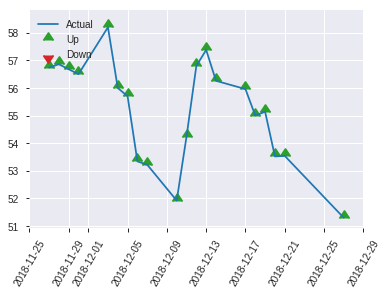


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2387480021729539
RMSE: 0.4886184627835443
LogLoss: 0.6702832449219084
Mean Per-Class Error: 0.387891156462585
AUC: 0.6036054421768707
pr_auc: 0.48923638903105876
Gini: 0.20721088435374146
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3729217052459717: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   135  0.9184   (135.0/147.0)
1      2    98   0.02     (2.0/100.0)
Total  14   233  0.5547   (137.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.372922     0.588589  232
max f2                       0.341082     0.776398  243
max f0point5                 0.468732     0.53125   134
max accuracy                 0.537336     0.619433  45
max precision                0.658711     1         0
max recall                   0.341082     1         243
max specificity              0.658711     1         0
max absolute_mcc             0.468732     0.221082  134
max min_per_class_accuracy   0.477361     0.591837  119
max mean_per_class_accuracy  0.468732     0.612109  134

Gains/Lift Table: Avg response rate: 40.49 %, avg score: 47.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.645501           0.823333  0.823333           0.333333         0.653163  0.333333                    0.653163            0.01            0.01                       -17.6667  -17.6667
    2        0.0202429                   0.629427           2.47      1.482              1                0.640853  0.6                         0.648239            0.02            0.03                       147       48.2
    3        0.0323887                   0.618749           2.47      1.8525             1                0.623429  0.75                        0.638935            0.03            0.06                       147       85.25
    4        0.0404858                   0.608228           1.235     1.729              0.5              0.61336   0.7                         0.63382             0.01            0.07                       23.5      72.9
    5        0.0526316                   0.598854           0.823333  1.52               0.333333         0.604073  0.615385                    0.626956            0.01            0.08                       -17.6667  52
    6        0.101215                    0.571434           1.02917   1.2844             0.416667         0.584895  0.52                        0.606767            0.05            0.13                       2.91667   28.44
    7        0.149798                    0.555079           1.44083   1.33514            0.583333         0.562191  0.540541                    0.59231             0.07            0.2                        44.0833   33.5135
    8        0.202429                    0.532733           1.33      1.3338             0.538462         0.540968  0.54                        0.578961            0.07            0.27                       33        33.38
    9        0.299595                    0.509863           1.02917   1.235              0.416667         0.519729  0.5                         0.55975             0.1             0.37                       2.91667   23.5
    10       0.40081                     0.490765           0.7904    1.12273            0.32             0.500689  0.454545                    0.544836            0.08            0.45                       -20.96    12.2727
    11       0.502024                    0.474983           1.6796    1.235              0.68             0.482428  0.5                         0.532254            0.17            0.62                       67.96     23.5
    12       0.59919                     0.45958            0.92625   1.18493            0.375            0.468201  0.47973                     0.521867            0.09            0.71                       -7.375    18.4932
    13       0.700405                    0.44098            0.6916    1.11364            0.28             0.449568  0.450867                    0.511419            0.07            0.78                       -30.84    11.3642
    14       0.797571                    0.420067           0.6175    1.0532             0.25             0.42922   0.426396                    0.501405            0.06            0.84                       -38.25    5.3198
    15       0.898785                    0.384962           0.6916    1.01248            0.28             0.402377  0.40991                     0.490253            0.07            0.91                       -30.84    1.24775
    16       1                           0.293731           0.8892    1                  0.36             0.359935  0.404858                    0.477063            0.09            1   

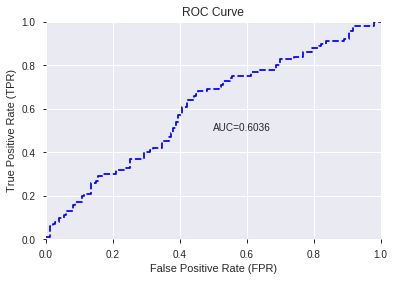

This function is available for GLM models only


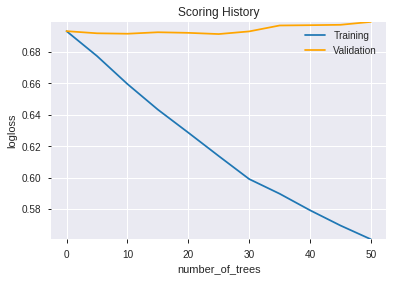

--2019-08-28 17:05:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.36
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.36|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_170459_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_170459_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a241',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['OBV',
 'BOP',
 'STOCHF_fastk',
 'CORREL_8',
 'BETA_8',
 'BETA_24',
 'CORREL_24',
 'COS',
 'dayofyear',
 'STOCH_slowd',
 'STOCHRSI_fastd',
 'HT_DCPERIOD',
 'BETA_12',
 'DX_8',
 'SIN',
 'SAREXT',
 'day',
 'BETA_20',
 'AROONOSC_14',
 'week',
 'aroondown_12',
 'aroondown_14',
 'aroondown_8',
 'STOCHRSI_fastk',
 'dayofweek',
 'weekday_name',
 'CDLSPINNINGTOP',
 'days_in_month',
 'weekofyear',
 'weekday',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLHAMMER',
 'month',
 'CDLINVERTEDHAMMER',
 'HT_TRENDMODE',
 'quarter']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [917] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190828_170526  0.575714  1.034562              0.480986  0.577588  0.333608
1  DeepLearning_grid_1_AutoML_20190828_170526_model_3  0.572177  0.692312              0.477381  0.499445  0.249445
2  DeepLearning_grid_1_AutoML_20190828_170526_model_5  0.562143  0.695747              0.500000  0.500672  0.250672
3  DeepLearning_grid_1_AutoML_20190828_170526_model_4  0.543129  1.227733              0.475986  0.635268  0.403565
4  DeepLearning_grid_1_AutoML_20190828_170526_model_2  0.541156  0.712714              0.482993  0.509142  0.259225
5  DeepLearning_grid_1_AutoML_20190828_170526_model_7  0.533639  0.735043              0.482993  0.518751  0.269103
6  DeepLearning_grid_1_AutoML_20190828_170526_model_9  0.516190  0.707555              0.434558  0.507108  0.257159
7  DeepLearning_grid_1_AutoML_20190828_170526_model_8  0.500000  0.700491              0.500000  0.503657  0.253670
8  DeepLearning_grid_1_AutoML_20190828_170526_model_1  0.469898  2.389516              0.496599  0.688355  0.473832
9  DeepLearning_grid_1_AutoML_20190828_170526_model_6  0.468027  0.695511              0.496599  0.501168  0.251170

variable  relative_importance  scaled_importance  percentage
0                    CORREL_12             1.000000           1.000000    0.001552
1              MACDFIX_hist_20             0.981644           0.981644    0.001523
2      BBANDS_upperband_14_2_3             0.975010           0.975010    0.001513
3                    CORREL_24             0.968428           0.968428    0.001503
4      BBANDS_lowerband_24_3_5             0.933643           0.933643    0.001449
...                        ...                  ...                ...         ...
1036    LINEARREG_INTERCEPT_14             0.310303           0.310303    0.000482
1037                PLUS_DI_30             0.271457           0.271457    0.000421
1038  BBANDS_middleband_24_1_4             0.267085           0.267085    0.000414
1039   BBANDS_lowerband_12_6_3             0.262648           0.262648    0.000408
1040                 MAVP_20_2             0.259489           0.259489    0.000403

[1041 rows x 4 columns]

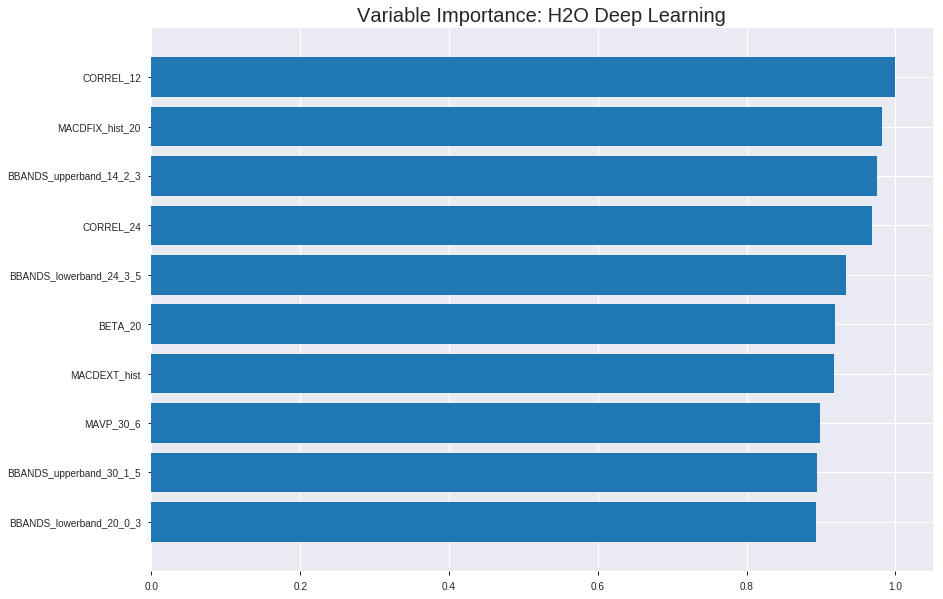

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_170526


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26947883442937887
RMSE: 0.5191135082324277
LogLoss: 0.7386128997890569
Mean Per-Class Error: 0.4544965578033172
AUC: 0.5429052166795495
pr_auc: 0.5437267133189725
Gini: 0.08581043335909899
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15165573978010685: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      62   797   0.9278   (797.0/859.0)
1      12   857   0.0138   (12.0/869.0)
Total  74   1654  0.4682   (809.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.151656     0.67935   362
max f2                       0.113185     0.839938  381
max f0point5                 0.198339     0.574281  335
max accuracy                 0.284525     0.546875  273
max precision                0.999943     1         0
max recall                   0.113185     1         381
max specificity              0.999943     1         0
max absolute_mcc             0.144067     0.144247  366
max min_per_class_accuracy   0.415233     0.527357  182
max mean_per_class_accuracy  0.284525     0.545503  273

Gains/Lift Table: Avg response rate: 50.29 %, avg score: 41.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104167                   0.901738           1.76755   1.76755            0.888889         0.953417  0.888889                    0.953417            0.018412        0.018412                   76.7549    76.7549
    2        0.0202546                   0.697085           1.63758   1.70442            0.823529         0.777159  0.857143                    0.867806            0.0161105       0.0345224                  63.7582    70.4422
    3        0.0300926                   0.655081           1.1697    1.52961            0.588235         0.66874   0.769231                    0.802727            0.0115075       0.0460299                  16.9701    52.961
    4        0.0405093                   0.642712           0.994246  1.39194            0.5              0.65095   0.7                         0.763698            0.0103567       0.0563867                  -0.575374  39.1945
    5        0.0503472                   0.61999            0.818791  1.27995            0.411765         0.630762  0.643678                    0.737722            0.00805524      0.0644419                  -18.1209   27.9949
    6        0.100116                    0.58971            0.994246  1.13792            0.5              0.599248  0.572254                    0.668885            0.0494822       0.113924                   -0.575374  13.7923
    7        0.251157                    0.583525           0.868537  0.975919           0.436782         0.584094  0.490783                    0.617894            0.131185        0.245109                   -13.1463   -2.40809
    8        0.300347                    0.580795           1.09952   0.996162           0.552941         0.582753  0.500963                    0.612138            0.0540852       0.299194                   9.95194    -0.383804
    9        0.399884                    0.502374           1.20234   1.04748            0.604651         0.547305  0.526773                    0.596               0.119678        0.418872                   20.2344    4.74838
    10       0.5                         0.415453           1.08045   1.05409            0.543353         0.457776  0.530093                    0.568323            0.10817         0.527043                   8.04526    5.40852
    11       0.600116                    0.345412           1.03448   1.05081            0.520231         0.380532  0.528447                    0.536995            0.103567        0.63061                    3.44759    5.08138
    12       0.699653                    0.301778           1.0983    1.05757            0.552326         0.323072  0.531844                    0.506561            0.109321        0.739931                   9.82953    5.75688
    13       0.799769                    0.251608           0.931028  1.04173            0.468208         0.276781  0.523878                    0.477797            0.0932106       0.833142                   -6.89717   4.17284
    14       0.899884                    0.194678           1.02298   1.03964            0.514451         0.224493  0.52283                     0.449616            0.102417        0.935558                   2.29817    3.96427
    15       1                           0.00748197         0.643674  1                  0.323699         0.145218  0.502894                    0.419141            0.0644419       1                          -35.6326   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3020033850795129
RMSE: 0.5495483464441622
LogLoss: 0.9317747039880462
Mean Per-Class Error: 0.4763491334033614
AUC: 0.4976529674369748
pr_auc: 0.5152075786173699
Gini: -0.004694065126050417
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11493822596781715: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    231  0.9706   (231.0/238.0)
1      3    253  0.0117   (3.0/256.0)
Total  10   484  0.4737   (234.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.114938     0.683784  389
max f2                       0.0274789    0.843771  398
max f0point5                 0.114938     0.577099  389
max accuracy                 0.114938     0.526316  389
max precision                0.79762      0.612245  40
max recall                   0.0274789    1         398
max specificity              0.999956     0.983193  0
max absolute_mcc             0.722256     0.070382  55
max min_per_class_accuracy   0.389572     0.488281  207
max mean_per_class_accuracy  0.722256     0.523651  55

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 43.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.999942           1.15781   1.15781            0.6              0.99999   0.6                         0.99999             0.0117188       0.0117188                  15.7812   15.7812
    2        0.0202429                   0.993279           0.771875  0.964844           0.4              0.997402  0.5                         0.998696            0.0078125       0.0195312                  -22.8125  -3.51562
    3        0.0303644                   0.965704           0.771875  0.900521           0.4              0.976462  0.466667                    0.991285            0.0078125       0.0273438                  -22.8125  -9.94792
    4        0.0404858                   0.945785           1.54375   1.06133            0.8              0.95644   0.55                        0.982574            0.015625        0.0429688                  54.375    6.13281
    5        0.0506073                   0.915604           0.771875  1.00344            0.4              0.935385  0.52                        0.973136            0.0078125       0.0507812                  -22.8125  0.34375
    6        0.101215                    0.788632           1.31219   1.15781            0.68             0.850338  0.6                         0.911737            0.0664062       0.117188                   31.2188   15.7812
    7        0.149798                    0.671153           0.88444   1.06915            0.458333         0.729948  0.554054                    0.852778            0.0429688       0.160156                   -11.556   6.91512
    8        0.200405                    0.601296           0.6175    0.955098           0.32             0.637788  0.494949                    0.798488            0.03125         0.191406                   -38.25    -4.49021
    9        0.299595                    0.502492           1.14206   1.017              0.591837         0.550743  0.527027                    0.716464            0.113281        0.304688                   14.206    1.69975
    10       0.40081                     0.440343           0.964844  1.00383            0.5              0.467347  0.520202                    0.653556            0.0976562       0.402344                   -3.51562  0.382734
    11       0.5                         0.38727            0.86639   0.976562           0.44898          0.418345  0.506073                    0.606894            0.0859375       0.488281                   -13.361   -2.34375
    12       0.59919                     0.337541           1.02392   0.984401           0.530612         0.362231  0.510135                    0.566393            0.101562        0.589844                   2.39158   -1.55986
    13       0.700405                    0.308037           1.00344   0.987152           0.52             0.321379  0.511561                    0.530986            0.101562        0.691406                   0.34375   -1.28477
    14       0.799595                    0.269758           1.10268   1.00148            0.571429         0.28925   0.518987                    0.500999            0.109375        0.800781                   10.2679   0.148339
    15       0.898785                    0.21163            1.02392   1.00396            0.530612         0.241925  0.52027                     0.472407            0.101562        0.902344                   2.39158   0.395904
    16       1                           0.020101           0.964844  1                  0.5              0.145712  0.518219                    0.439341


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:05:26  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 17:05:27  0.485 sec   6329 obs/sec      1         1             1728       0.546635         0.862066            -0.195281      0.536357        0.533804           1.10472          0.491319                         0.552745           0.98821               -0.223735        0.492836          0.505545             0.771875           0.475709
    2019-08-28 17:05:28  1.977 sec   10627 obs/sec     10        10            17280      0.519114         0.738613            -0.0779514     0.542905        0.543727           1.76755          0.468171                         0.549548           0.931775              -0.20962         0.497653          0.515208             1.15781            0.473684

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ----------------------
CORREL_12                 1.0                    1.0                  0.0015517843499595321
MACDFIX_hist_20           0.9816439747810364     0.9816439747810364   0.0015232997572972818
BBANDS_upperband_14_2_3   0.9750104546546936     0.9750104546546936   0.0015130059645800816
CORREL_24                 0.9684275984764099     0.9684275984764099   0.0015027907913845865
BBANDS_lowerband_24_3_5   0.9336428046226501     0.9336428046226501   0.0014488122926657535
---                       ---                    ---                  ---
LINEARREG_INTERCEPT_14    0.31030288338661194    0.31030288338661194  0.0004815231581866621
PLUS_DI_30                0.27145740389823914    0.27145740389823914  0.00042124335104993117
BBANDS_middleband_24_1_4  0.2670854330062866     0.2670854330062866   0.00041445899504132064
BBANDS_lowerband_12_6_3   0.26264768838882446    0.26264768838882446  0.0004075725723948257
MAVP_20_2                 0.2594889998435974     0.2594889998435974   0.0004026709689439459


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6275303643724697)

('F1', 0.5808383233532934)

('auc', 0.5757142857142857)

('logloss', 1.0345623702904672)

('mean_per_class_error', 0.4167006802721088)

('rmse', 0.5775877240314728)

('mse', 0.3336075789518569)

deeplearning prediction progress: |███████████████████████████████████████| 100%


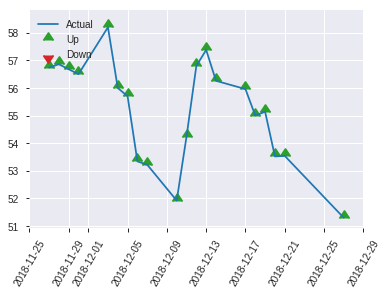


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3336075789518569
RMSE: 0.5775877240314728
LogLoss: 1.0345623702904672
Mean Per-Class Error: 0.4167006802721088
AUC: 0.5757142857142857
pr_auc: 0.47682839344978856
Gini: 0.15142857142857147
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3486072234097796: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   137  0.932    (137.0/147.0)
1      3    97   0.03     (3.0/100.0)
Total  13   234  0.5668   (140.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348607     0.580838  207
max f2                       0.129632     0.772798  220
max f0point5                 0.59339      0.504518  140
max accuracy                 0.973563     0.62753   23
max precision                0.980158     0.705882  16
max recall                   0.129632     1         220
max specificity              0.999993     0.993197  0
max absolute_mcc             0.973563     0.174975  23
max min_per_class_accuracy   0.626655     0.54      117
max mean_per_class_accuracy  0.59339      0.583299  140

Gains/Lift Table: Avg response rate: 40.49 %, avg score: 67.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.998187           1.64667   1.64667            0.666667         0.999589  0.666667                    0.999589            0.02            0.02                       64.6667   64.6667
    2        0.0202429                   0.991973           0         0.988              0                0.995232  0.4                         0.997846            0               0.02                       -100      -1.2
    3        0.0323887                   0.9877             1.64667   1.235              0.666667         0.990107  0.5                         0.994944            0.02            0.04                       64.6667   23.5
    4        0.0404858                   0.987115           2.47      1.482              1                0.987478  0.6                         0.993451            0.02            0.06                       147       48.2
    5        0.0526316                   0.983672           2.47      1.71               1                0.985088  0.692308                    0.991521            0.03            0.09                       147       71
    6        0.101215                    0.969738           1.44083   1.5808             0.583333         0.978277  0.64                        0.985164            0.07            0.16                       44.0833   58.08
    7        0.149798                    0.943717           0.823333  1.33514            0.333333         0.959096  0.540541                    0.976709            0.04            0.2                        -17.6667  33.5135
    8        0.202429                    0.892499           1.14      1.2844             0.461538         0.922134  0.52                        0.96252             0.06            0.26                       14        28.44
    9        0.299595                    0.80434            0.823333  1.13486            0.333333         0.85355   0.459459                    0.927178            0.08            0.34                       -17.6667  13.4865
    10       0.40081                     0.675647           0.988     1.09778            0.4              0.732745  0.444444                    0.878079            0.1             0.44                       -1.2      9.77778
    11       0.502024                    0.614838           1.1856    1.11548            0.48             0.642967  0.451613                    0.830677            0.12            0.56                       18.56     11.5484
    12       0.59919                     0.587293           1.33792   1.15155            0.541667         0.599818  0.466216                    0.793241            0.13            0.69                       33.7917   15.1554
    13       0.724696                    0.583525           0.796774  1.09011            0.322581         0.583899  0.441341                    0.756986            0.1             0.79                       -20.3226  9.01117
    14       0.797571                    0.578149           0.548889  1.04066            0.222222         0.582269  0.42132                     0.741022            0.04            0.83                       -45.1111  4.06599
    15       0.898785                    0.449688           0.7904    1.01248            0.32             0.522675  0.40991                     0.716433            0.08            0.91                       -20.96    1.24775
    16       1                           0.129632           0.8892    1                  0.36             0.325181  0.404858                    0.676833            0.09           

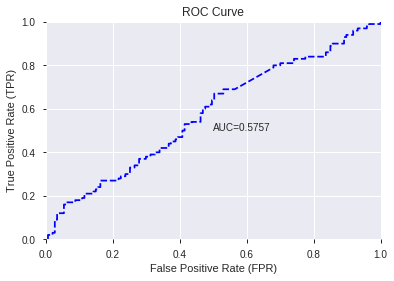

This function is available for GLM models only


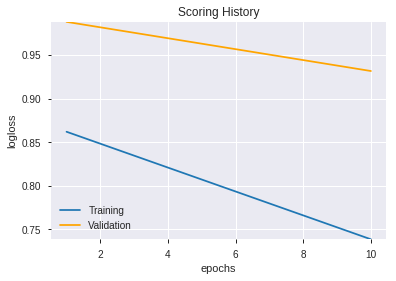

--2019-08-28 17:29:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_170526',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_170526',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a241',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_a241'

['CORREL_12',
 'MACDFIX_hist_20',
 'BBANDS_upperband_14_2_3',
 'CORREL_24',
 'BBANDS_lowerband_24_3_5',
 'BETA_20',
 'MACDEXT_hist',
 'MAVP_30_6',
 'BBANDS_upperband_30_1_5',
 'BBANDS_lowerband_20_0_3',
 'BBANDS_lowerband_8_8_3',
 'HT_PHASOR_inphase',
 'mama',
 'MAVP_8_3',
 'BBANDS_lowerband_20_1_3',
 'is_quarter_start',
 'BBANDS_lowerband_8_6_3',
 'BBANDS_middleband_20_6_3',
 'BBANDS_lowerband_12_7_4',
 'MIDPRICE_12',
 'TSF_12',
 'BBANDS_upperband_8_0_4',
 'BBANDS_lowerband_8_5_4',
 'BBANDS_lowerband_12_7_2',
 'SMA_30',
 'SQRT',
 'BBANDS_upperband_14_5_4',
 'BBANDS_upperband_30_7_5',
 'BBANDS_middleband_24_3_5',
 'MACDFIX_signal_8',
 'MACDEXT_signal',
 'BBANDS_upperband_24_1_3',
 'dayofweek',
 'BBANDS_upperband_30_6_3',
 'weekday',
 'MACDFIX_signal_20',
 'CORREL_20',
 'DX_14',
 'month',
 'quarter',
 'PLUS_DI_14',
 'dayofyear',
 'CDLSTALLEDPATTERN',
 'BBANDS_middleband_8_0_5',
 'TRIMA_12',
 'BBANDS_lowerband_8_2_4',
 'BOP',
 'MOM_20',
 'BBANDS_lowerband_24_3_4',
 'CDLPIERCING',
 'ROC_2

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_172959_model_1  0.49585  0.688424              0.479388  0.497635  0.247641

variable  relative_importance  scaled_importance    percentage
0            CDLINVERTEDHAMMER         7.399655e-03           1.000000  1.137145e-02
1                          BOP         7.355352e-03           0.994013  1.130337e-02
2                    CDLHAMMER         6.402944e-03           0.865303  9.839748e-03
3                          OBV         6.334043e-03           0.855992  9.733865e-03
4                 STOCHF_fastk         5.624374e-03           0.760086  8.643279e-03
...                        ...                  ...                ...           ...
1036                    WMA_24         2.461764e-06           0.000333  3.783125e-06
1037   BBANDS_upperband_14_3_5         2.260190e-06           0.000305  3.473356e-06
1038              MINMAX_max_8         2.154259e-06           0.000291  3.310566e-06
1039  BBANDS_middleband_14_3_2         6.910439e-07           0.000093  1.061964e-06
1040  BBANDS_middleband_24_2_2         1.366468e-07           0.000018  2.099925e-07

[1041 rows x 4 columns]

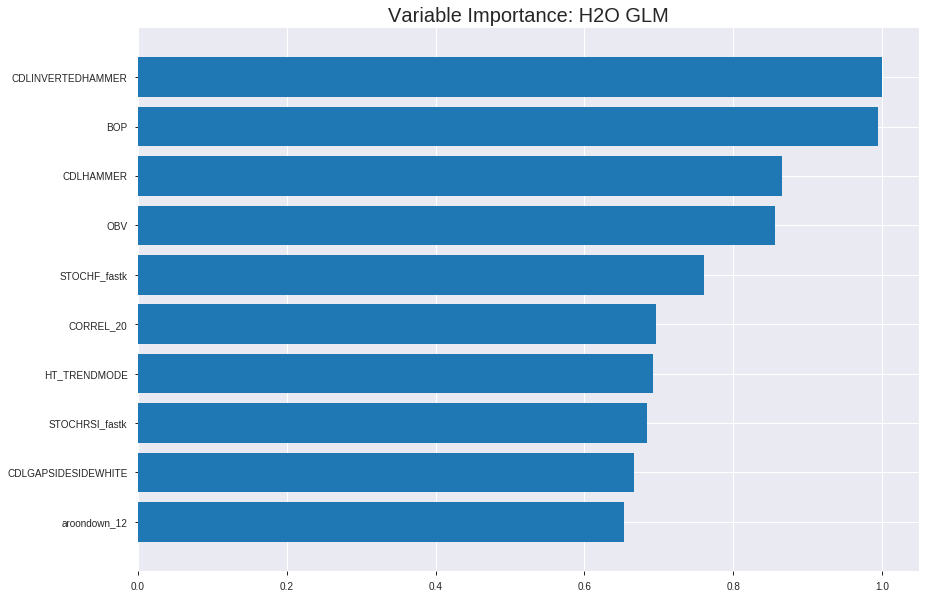

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_172959_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2465421024425494
RMSE: 0.49653006197263566
LogLoss: 0.6862096716473838
Null degrees of freedom: 1727
Residual degrees of freedom: 686
Null deviance: 2395.458785321781
Residual deviance: 2371.5406252133585
AIC: 4455.540625213358
AUC: 0.5830300172411252
pr_auc: 0.5844902452649052
Gini: 0.16606003448225048
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4445817718617521: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      35   824   0.9593   (824.0/859.0)
1      10   859   0.0115   (10.0/869.0)
Total  45   1683  0.4826   (834.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444582     0.673197  372
max f2                       0.413411     0.835095  398
max f0point5                 0.471439     0.571171  302
max accuracy                 0.518618     0.570023  137
max precision                0.582088     1         0
max recall                   0.413411     1         398
max specificity              0.582088     1         0
max absolute_mcc             0.518618     0.151483  137
max min_per_class_accuracy   0.505465     0.552359  188
max mean_per_class_accuracy  0.518618     0.57103   137

Gains/Lift Table: Avg response rate: 50.29 %, avg score: 50.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.565116           1.43613   1.43613            0.722222         0.572443  0.722222                    0.572443            0.0149597       0.0149597                  43.6133   43.6133
    2        0.0202546                   0.558388           1.40364   1.42035            0.705882         0.561163  0.714286                    0.566964            0.013809        0.0287687                  40.3642   42.0352
    3        0.0300926                   0.551995           1.52061   1.45313            0.764706         0.554332  0.730769                    0.562835            0.0149597       0.0437284                  52.0612   45.3129
    4        0.0405093                   0.547763           1.32566   1.42035            0.666667         0.549961  0.714286                    0.559524            0.013809        0.0575374                  32.5662   42.0352
    5        0.0503472                   0.545573           1.40364   1.41709            0.705882         0.546531  0.712644                    0.556985            0.013809        0.0713464                  40.3642   41.7087
    6        0.100116                    0.538689           1.20234   1.31034            0.604651         0.541858  0.65896                     0.549466            0.0598389       0.131185                   20.2344   31.0336
    7        0.150463                    0.533832           1.16567   1.26193            0.586207         0.536124  0.634615                    0.545001            0.0586881       0.189873                   16.5668   26.1928
    8        0.200231                    0.529339           1.20234   1.24712            0.604651         0.531389  0.627168                    0.541618            0.0598389       0.249712                   20.2344   24.7118
    9        0.300347                    0.520257           1.13792   1.21072            0.572254         0.524548  0.608863                    0.535928            0.113924        0.363636                   13.7923   21.072
    10       0.399884                    0.51304            0.913319  1.13669            0.459302         0.516758  0.571635                    0.531156            0.0909091       0.454545                   -8.66808  13.6693
    11       0.5                         0.505229           1.01149   1.11162            0.508671         0.509164  0.559028                    0.526753            0.101266        0.555811                   1.14875   11.1623
    12       0.600116                    0.497046           0.896546  1.07574            0.450867         0.50151   0.540984                    0.522541            0.0897583       0.64557                    -10.3454  7.57419
    13       0.699653                    0.487392           0.982685  1.0625             0.494186         0.492677  0.534326                    0.518293            0.0978136       0.743383                   -1.73147  6.2503
    14       0.799769                    0.475344           0.885052  1.04029            0.445087         0.481687  0.523155                    0.51371             0.0886076       0.831991                   -11.4948  4.02895
    15       0.899884                    0.462953           0.919534  1.02685            0.462428         0.46949   0.516399                    0.508791            0.0920598       0.924051                   -8.04659  2.6855
    16       1                           0.394616           0.758616  1                  0.381503         0.449887  0.502894                    0.502894            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24979247478081168
RMSE: 0.49979243169621096
LogLoss: 0.6927389873978619
Null degrees of freedom: 493
Residual degrees of freedom: -548
Null deviance: 684.6376229712456
Residual deviance: 684.4261195490876
AIC: 2768.4261195490876
AUC: 0.5115464154411765
pr_auc: 0.5129583539412818
Gini: 0.023092830882353033
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4747016280280516: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    237  0.9958   (237.0/238.0)
1      0    256  0        (0.0/256.0)
Total  1    493  0.4798   (237.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.474702     0.683578   398
max f2                       0.474702     0.843771   398
max f0point5                 0.503073     0.579955   302
max accuracy                 0.503458     0.546559   300
max precision                0.544062     0.571429   26
max recall                   0.474702     1          398
max specificity              0.587634     0.995798   0
max absolute_mcc             0.503073     0.0872796  302
max min_per_class_accuracy   0.516096     0.503906   198
max mean_per_class_accuracy  0.503458     0.536945   300

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 51.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.555482           0.385938  0.385938           0.2              0.56493   0.2                         0.56493             0.00390625      0.00390625                 -61.4062  -61.4062
    2        0.0202429                   0.553059           1.15781   0.771875           0.6              0.554097  0.4                         0.559514            0.0117188       0.015625                   15.7812   -22.8125
    3        0.0303644                   0.550623           0.385938  0.643229           0.2              0.552001  0.333333                    0.557009            0.00390625      0.0195312                  -61.4062  -35.6771
    4        0.0404858                   0.548309           1.92969   0.964844           1                0.549643  0.5                         0.555168            0.0195312       0.0390625                  92.9688   -3.51562
    5        0.0506073                   0.545108           1.15781   1.00344            0.6              0.54693   0.52                        0.55352             0.0117188       0.0507812                  15.7812   0.34375
    6        0.101215                    0.539123           0.771875  0.887656           0.4              0.541788  0.46                        0.547654            0.0390625       0.0898438                  -22.8125  -11.2344
    7        0.149798                    0.534905           1.04525   0.938767           0.541667         0.536817  0.486486                    0.544139            0.0507812       0.140625                   4.52474   -6.12331
    8        0.200405                    0.530404           1.08063   0.97459            0.56             0.532311  0.505051                    0.541152            0.0546875       0.195312                   8.0625    -2.54104
    9        0.299595                    0.524152           0.984534  0.977882           0.510204         0.527104  0.506757                    0.536501            0.0976562       0.292969                   -1.54656  -2.21178
    10       0.40081                     0.519524           1.11922   1.01357            0.58             0.521932  0.525253                    0.532822            0.113281        0.40625                    11.9219   1.35732
    11       0.5                         0.51574            0.984534  1.00781            0.510204         0.517812  0.522267                    0.529844            0.0976562       0.503906                   -1.54656  0.78125
    12       0.59919                     0.510991           1.02392   1.01048            0.530612         0.513348  0.523649                    0.527114            0.101562        0.605469                   2.39158   1.04783
    13       0.700405                    0.505935           1.15781   1.03177            0.6              0.508613  0.534682                    0.52444             0.117188        0.722656                   15.7812   3.17693
    14       0.799595                    0.501372           1.0633    1.03568            0.55102          0.503869  0.536709                    0.521888            0.105469        0.828125                   6.32972   3.56804
    15       0.898785                    0.494659           0.787628  1.00831            0.408163         0.497979  0.522523                    0.51925             0.078125        0.90625                    -21.2372  0.830518
    16       1                           0.471429           0.92625   1                  0.48             0.488166  0.518219                    0.516103


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 17:30:03  0.000 sec   2            3.7       1042          1.37242           1.38548
    2019-08-28 17:30:05  2.255 sec   4            2.7       1042          1.36937           1.38604
    2019-08-28 17:30:07  4.476 sec   6            2         1042          1.36576           1.38691
    2019-08-28 17:30:09  6.739 sec   8            1.4       1042          1.36153           1.38819
    2019-08-28 17:30:12  8.972 sec   10           1         1042          1.35667           1.39
    2019-08-28 17:30:14  11.240 sec  12           0.76      1042          1.3512            1.39249

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6032388663967612)

('F1', 0.5833333333333334)

('auc', 0.49585034013605445)

('logloss', 0.6884238067789862)

('mean_per_class_error', 0.4554421768707483)

('rmse', 0.4976353642150905)

('mse', 0.2476409557174858)

glm prediction progress: |████████████████████████████████████████████████| 100%


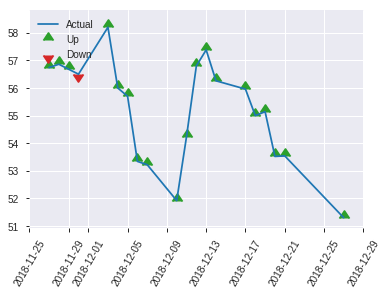


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2476409557174858
RMSE: 0.4976353642150905
LogLoss: 0.6884238067789862
Null degrees of freedom: 246
Residual degrees of freedom: -795
Null deviance: 342.9669668693666
Residual deviance: 340.0813605488192
AIC: 2424.0813605488192
AUC: 0.49585034013605445
pr_auc: 0.4179999324655555
Gini: -0.008299319727891108
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4574852995966467: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    138  0.9388   (138.0/147.0)
1      2    98   0.02     (2.0/100.0)
Total  11   236  0.5668   (140.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457485     0.583333  235
max f2                       0.450397     0.776398  243
max f0point5                 0.459887     0.469368  227
max accuracy                 0.522174     0.603239  5
max precision                0.522174     0.666667  5
max recall                   0.450397     1         243
max specificity              0.580316     0.993197  0
max absolute_mcc             0.505428     0.107591  39
max min_per_class_accuracy   0.483586     0.47619   124
max mean_per_class_accuracy  0.499331     0.544558  60

Gains/Lift Table: Avg response rate: 40.49 %, avg score: 48.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.527991           0.823333  0.823333           0.333333         0.553663  0.333333                    0.553663            0.01            0.01                       -17.6667  -17.6667
    2        0.0202429                   0.522262           2.47      1.482              1                0.525059  0.6                         0.542221            0.02            0.03                       147       48.2
    3        0.0323887                   0.519595           0.823333  1.235              0.333333         0.521328  0.5                         0.534386            0.01            0.04                       -17.6667  23.5
    4        0.0404858                   0.518533           0         0.988              0                0.51857   0.4                         0.531223            0               0.04                       -100      -1.2
    5        0.0526316                   0.517921           0.823333  0.95               0.333333         0.518194  0.384615                    0.528216            0.01            0.05                       -17.6667  -5
    6        0.101215                    0.510921           1.64667   1.2844             0.666667         0.513976  0.52                        0.521381            0.08            0.13                       64.6667   28.44
    7        0.149798                    0.506026           1.235     1.26838            0.5              0.508003  0.513514                    0.517042            0.06            0.19                       23.5      26.8378
    8        0.202429                    0.501005           0.76      1.1362             0.307692         0.502902  0.46                        0.513366            0.04            0.23                       -24       13.62
    9        0.299595                    0.495639           0.823333  1.03473            0.333333         0.498768  0.418919                    0.508631            0.08            0.31                       -17.6667  3.47297
    10       0.40081                     0.489861           0.7904    0.97303            0.32             0.492909  0.393939                    0.504661            0.08            0.39                       -20.96    -2.69697
    11       0.502024                    0.48361            0.7904    0.93621            0.32             0.485989  0.379032                    0.500897            0.08            0.47                       -20.96    -6.37903
    12       0.59919                     0.480805           1.13208   0.967973           0.458333         0.481799  0.391892                    0.4978              0.11            0.58                       13.2083   -3.2027
    13       0.700405                    0.476664           0.7904    0.942312           0.32             0.478562  0.381503                    0.49502             0.08            0.66                       -20.96    -5.76879
    14       0.797571                    0.470961           1.13208   0.965431           0.458333         0.474109  0.390863                    0.492472            0.11            0.77                       13.2083   -3.45685
    15       0.898785                    0.463216           1.3832    1.01248            0.56             0.467728  0.40991                     0.489686            0.14            0.91                       38.32     1.24775
    16       1                           0.427938           0.8892    1                  0.36             0.455342  0.404858                    0.486209            0.09      

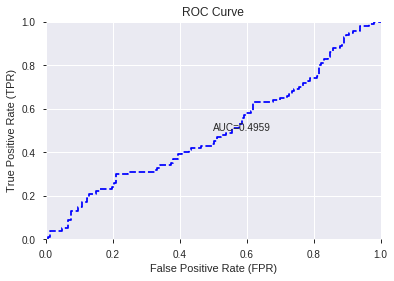

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


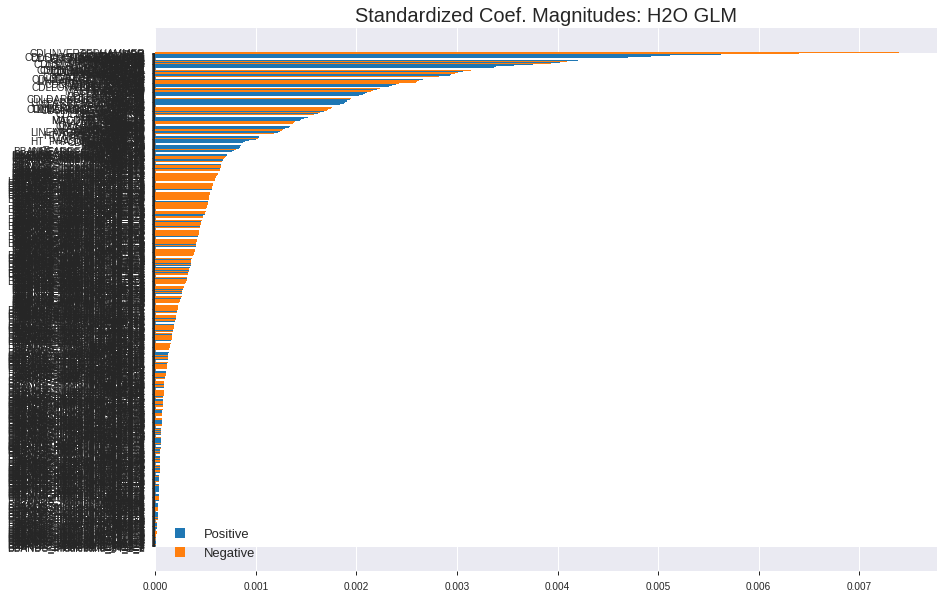

'log_likelihood'
--2019-08-28 17:30:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_172959_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_172959_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a241',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLINVERTEDHAMMER',
 'BOP',
 'CDLHAMMER',
 'OBV',
 'STOCHF_fastk',
 'CORREL_20',
 'HT_TRENDMODE',
 'STOCHRSI_fastk',
 'CDLGAPSIDESIDEWHITE',
 'aroondown_12',
 'CDLEVENINGDOJISTAR',
 'aroondown_14',
 'CDLMORNINGSTAR',
 'BETA_8',
 'is_month_end',
 'is_quarter_start',
 'CORREL_24',
 'CDLSHORTLINE',
 'DX_8',
 'CDLINNECK',
 'is_month_start',
 'CDLMATCHINGLOW',
 'CDLTAKURI',
 'CDLSTALLEDPATTERN',
 'ATR_30',
 'aroonup_30',
 'ADXR_14',
 'CDLSHOOTINGSTAR',
 'ATR_24',
 'WILLR_8',
 'DX_12',
 'ADX_8',
 'ATR_20',
 'CDL2CROWS',
 'VAR_8',
 'CDLDRAGONFLYDOJI',
 'CDL3WHITESOLDIERS',
 'CDLUNIQUE3RIVER',
 'CDLHARAMICROSS',
 'AROONOSC_14',
 'CDLEVENINGSTAR',
 'MACDEXT_hist',
 'STOCH_slowd',
 'WILLR_12',
 'CDLONNECK',
 'MINUS_DI_8',
 'weekofyear',
 'BETA_24',
 'week',
 'ATR_14',
 'CDLTHRUSTING',
 'CDLADVANCEBLOCK',
 'CORREL_12',
 'ADXR_12',
 'CDLSEPARATINGLINES',
 'CDLRICKSHAWMAN',
 'LINEARREG_ANGLE_8',
 'DX_14',
 'ATR_12',
 'EXP',
 'SINH',
 'COSH',
 'DIV',
 'CDL3LINESTRIKE',
 'quarter',
 'CDLHOMINGPIGEO

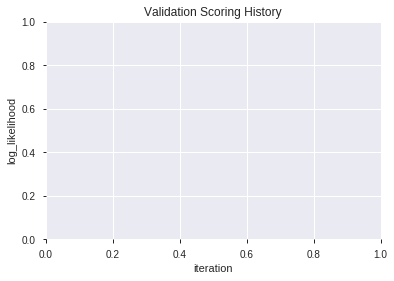

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190828_173046  0.578367  0.678305              0.407143  0.492604  0.242659
1               XGBoost_1_AutoML_20190828_173046  0.573197  0.681633              0.429762  0.494208  0.244242
2  XGBoost_grid_1_AutoML_20190828_173046_model_1  0.566122  0.679576              0.403537  0.493212  0.243258
3               XGBoost_2_AutoML_20190828_173046  0.558844  0.693280              0.496599  0.499594  0.249594
4  XGBoost_grid_1_AutoML_20190828_173046_model_2  0.556803  0.684636              0.496599  0.495723  0.245741
5  XGBoost_grid_1_AutoML_20190828_173046_model_4  0.541156  0.688952              0.439150  0.497863  0.247867
6  XGBoost_grid_1_AutoML_20190828_173046_model_3  0.516395  0.692400              0.481190  0.499661  0.249661
7  XGBoost_grid_1_AutoML_20190828_173046_model_7  0.507687  0.712578              0.500000  0.509040  0.259122
8  XGBoost_grid_1_AutoML_20190828_173046_model_6  0.505034  0.698215              0.480986  0.502462  0.252468
9  XGBoost_grid_1_AutoML_20190828_173046_model_5  0.471905  0.740586              0.500000  0.521169  0.271617

variable  relative_importance  scaled_importance  percentage
0                        BOP           160.743652           1.000000    0.028196
1                        TAN           133.432220           0.830093    0.023405
2                  CORREL_20           126.646767           0.787880    0.022215
3                        OBV           120.574997           0.750107    0.021150
4                  MACD_hist           113.929115           0.708763    0.019984
..                       ...                  ...                ...         ...
300                  NATR_20             1.591702           0.009902    0.000279
301             LINEARREG_30             1.365950           0.008498    0.000240
302    LINEARREG_INTERCEPT_8             1.187124           0.007385    0.000208
303                 WILLR_14             0.605999           0.003770    0.000106
304  BBANDS_upperband_20_0_5             0.460095           0.002862    0.000081

[305 rows x 4 columns]

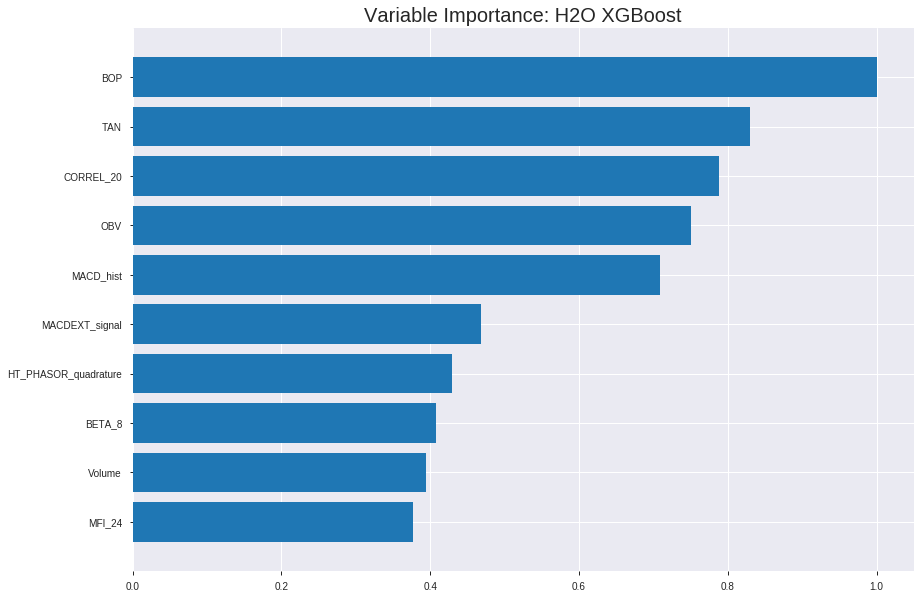

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190828_173046


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17391419056418794
RMSE: 0.417030203419594
LogLoss: 0.5362983493633858
Mean Per-Class Error: 0.12076222652989865
AUC: 0.9506759137327505
pr_auc: 0.9539113338765617
Gini: 0.901351827465501
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5011198073625565: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      768  91   0.1059   (91.0/859.0)
1      118  751  0.1358   (118.0/869.0)
Total  886  842  0.1209   (209.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50112      0.877849  199
max f2                       0.453747     0.91289   244
max f0point5                 0.528996     0.904929  173
max accuracy                 0.506594     0.879051  193
max precision                0.807278     1         0
max recall                   0.367777     1         327
max specificity              0.807278     1         0
max absolute_mcc             0.506594     0.75984   193
max min_per_class_accuracy   0.495835     0.875719  204
max mean_per_class_accuracy  0.506594     0.879238  193

Gains/Lift Table: Avg response rate: 50.29 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.745153           1.98849    1.98849            1                0.765464  1                           0.765464            0.0207135       0.0207135                  98.8493   98.8493
    2        0.0202546                   0.735823           1.98849    1.98849            1                0.740895  1                           0.75353             0.0195627       0.0402762                  98.8493   98.8493
    3        0.0300926                   0.719808           1.98849    1.98849            1                0.728317  1                           0.745287            0.0195627       0.0598389                  98.8493   98.8493
    4        0.0405093                   0.708739           1.98849    1.98849            1                0.714079  1                           0.737262            0.0207135       0.0805524                  98.8493   98.8493
    5        0.0503472                   0.698304           1.98849    1.98849            1                0.703205  1                           0.730608            0.0195627       0.100115                   98.8493   98.8493
    6        0.100116                    0.665057           1.98849    1.98849            1                0.680096  1                           0.705498            0.0989643       0.199079                   98.8493   98.8493
    7        0.150463                    0.637821           1.98849    1.98849            1                0.652054  1                           0.687614            0.100115        0.299194                   98.8493   98.8493
    8        0.200231                    0.615937           1.96537    1.98275            0.988372         0.627424  0.99711                     0.672654            0.0978136       0.397008                   96.5371   98.2745
    9        0.300347                    0.572969           1.88504    1.95018            0.947977         0.594889  0.980732                    0.646732            0.188723        0.585731                   88.5045   95.0179
    10       0.399884                    0.534697           1.68791    1.8849             0.848837         0.553849  0.947902                    0.623612            0.168009        0.75374                    68.7906   88.4895
    11       0.5                         0.495932           1.20689    1.74914            0.606936         0.513675  0.87963                     0.601599            0.120829        0.874568                   20.6889   74.9137
    12       0.600116                    0.459338           0.712639   1.57622            0.358382         0.478869  0.792671                    0.581125            0.0713464       0.945915                   -28.7361  57.6221
    13       0.699653                    0.423393           0.312147   1.39639            0.156977         0.441906  0.702233                    0.561318            0.0310702       0.976985                   -68.7853  39.6386
    14       0.799769                    0.390625           0.183907   1.24461            0.0924855        0.407332  0.625904                    0.542042            0.018412        0.995397                   -81.6093  24.4606
    15       0.899884                    0.354344           0.0459767  1.11125            0.0231214        0.372629  0.558842                    0.523194            0.00460299      1                          -95.4023  11.1254
    16       1                           0.213108           0          1                  0                0.318383  0.502894                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25364068557394154
RMSE: 0.5036275266245299
LogLoss: 0.7004549601124868
Mean Per-Class Error: 0.48396467962184875
AUC: 0.4861639968487395
pr_auc: 0.5134487145317181
Gini: -0.02767200630252098
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3858909606933594: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    232  0.9748   (232.0/238.0)
1      0    256  0        (0.0/256.0)
Total  6    488  0.4696   (232.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385891     0.688172  394
max f2                       0.385891     0.846561  394
max f0point5                 0.385891     0.57971   394
max accuracy                 0.417045     0.532389  375
max precision                0.703608     1         0
max recall                   0.385891     1         394
max specificity              0.703608     1         0
max absolute_mcc             0.385891     0.115     394
max min_per_class_accuracy   0.510347     0.488281  200
max mean_per_class_accuracy  0.417045     0.516035  375

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 51.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.661128           0.771875  0.771875           0.4              0.677961  0.4                         0.677961            0.0078125       0.0078125                  -22.8125  -22.8125
    2        0.0202429                   0.637163           1.54375   1.15781            0.8              0.651459  0.6                         0.66471             0.015625        0.0234375                  54.375    15.7812
    3        0.0303644                   0.629029           0.771875  1.02917            0.4              0.633429  0.533333                    0.654283            0.0078125       0.03125                    -22.8125  2.91667
    4        0.0404858                   0.622784           1.15781   1.06133            0.6              0.625802  0.55                        0.647163            0.0117188       0.0429688                  15.7812   6.13281
    5        0.0506073                   0.61255            0.771875  1.00344            0.4              0.618132  0.52                        0.641357            0.0078125       0.0507812                  -22.8125  0.34375
    6        0.101215                    0.594608           1.00344   1.00344            0.52             0.602804  0.52                        0.62208             0.0507812       0.101562                   0.34375   0.34375
    7        0.149798                    0.574847           1.12565   1.04307            0.583333         0.583923  0.540541                    0.609705            0.0546875       0.15625                    12.5651   4.30743
    8        0.200405                    0.562526           0.694688  0.955098           0.36             0.567961  0.494949                    0.599164            0.0351562       0.191406                   -30.5312  -4.49021
    9        0.299595                    0.542803           0.945153  0.951805           0.489796         0.554266  0.493243                    0.584299            0.09375         0.285156                   -5.48469  -4.81947
    10       0.40081                     0.524686           1.04203   0.97459            0.54             0.532918  0.505051                    0.571324            0.105469        0.390625                   4.20312   -2.54104
    11       0.5                         0.509749           0.984534  0.976562           0.510204         0.516996  0.506073                    0.560546            0.0976562       0.488281                   -1.54656  -2.34375
    12       0.59919                     0.492727           1.0633    0.990921           0.55102          0.500819  0.513514                    0.550659            0.105469        0.59375                    6.32972   -0.907939
    13       0.700405                    0.478049           0.849062  0.970421           0.44             0.486194  0.50289                     0.541343            0.0859375       0.679688                   -15.0938  -2.95791
    14       0.799595                    0.461204           1.14206   0.991713           0.591837         0.470658  0.513924                    0.532575            0.113281        0.792969                   14.206    -0.828718
    15       0.898785                    0.437771           1.0633    0.999613           0.55102          0.450858  0.518018                    0.523556            0.105469        0.898438                   6.32972   -0.0387106
    16       1                           0.266655           1.00344   1                  0.52             0.40961   0.518219                    0.51


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:31:00  0.006 sec   0                  0.5              0.693147            0.5             0                  1                0.497106                         0.5                0.693147              0.5               0                    1                  0.481781
    2019-08-28 17:31:01  1.267 sec   5                  0.488877         0.671106            0.789903        0.795798           1.98849          0.309606                         0.500667           0.694483              0.479845          0.503511             0.771875           0.475709
    2019-08-28 17:31:01  1.509 sec   10                 0.478798         0.651457            0.848426        0.85006            1.98849          0.234375                         0.501022           0.695203              0.489693          0.499948             0.321615           0.481781
    2019-08-28 17:31:01  1.765 sec   15                 0.466978         0.628766            0.88637         0.891695           1.98849          0.19213                          0.500433           0.694014              0.504366          0.532299             1.54375            0.481781
    2019-08-28 17:31:02  2.043 sec   20                 0.457233         0.610292            0.904565        0.910264           1.98849          0.1875                           0.500657           0.69448               0.511366          0.532142             1.54375            0.481781
    2019-08-28 17:31:02  2.305 sec   25                 0.447982         0.592942            0.916176        0.921964           1.98849          0.178819                         0.501352           0.695864              0.498055          0.531649             1.54375            0.481781
    2019-08-28 17:31:02  2.652 sec   30                 0.439355         0.576919            0.925904        0.931404           1.98849          0.155093                         0.501892           0.696953              0.497497          0.530561             1.15781            0.479757
    2019-08-28 17:31:02  2.886 sec   35                 0.433375         0.565968            0.935636        0.940303           1.98849          0.141782                         0.503076           0.699332              0.482619          0.516282             1.54375            0.479757
    2019-08-28 17:31:03  3.136 sec   40                 0.427317         0.554947            0.942834        0.946466           1.98849          0.135995                         0.502917           0.698988              0.486369          0.521051             1.15781            0.475709
    2019-08-28 17:31:03  3.372 sec   45                 0.42167          0.544771            0.949182        0.952464           1.98849          0.129051                         0.503509           0.700206              0.484375          0.514052             1.54375            0.475709
    2019-08-28 17:31:03  3.617 sec   50                 0.41703          0.536298            0.950676        0.953911           1.98849          0.120949                         0.503628           0.700455              0.486164          0.513449             0.771875           0.469636

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      160.74365234375        1.0                    0.028195504825962933
TAN                      133.43222045898438     0.8300932479351646     0.02340489817815518
CORREL_20                126.64676666259766     0.7878803599147031     0.022214684490256424
OBV                      120.57499694824219     0.7501073615671789     0.021149655733057715
MACD_hist                113.92911529541016     0.7087627637810106     0.019983923926650306
---                      ---                    ---                    ---
NATR_20                  1.5917024612426758     0.009902117054294767   0.0002791951891916179
LINEARREG_30             1.3659496307373047     0.008497689400612995   0.00023959664250451778
LINEARREG_INTERCEPT_8    1.187124252319336      0.007385201437259077   0.00020822948276494669
WILLR_14                 0.6059989929199219     0.0037699715297248204  0.00010629625046009903
BBANDS_upperband_20_0_5  0.4600954055786133     0.0028622928424862472  8.070379165364013e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6032388663967612)

('F1', 0.6101694915254238)

('auc', 0.5783673469387755)

('logloss', 0.678304666330358)

('mean_per_class_error', 0.40714285714285714)

('rmse', 0.4926042668767879)

('mse', 0.24265896374521764)

xgboost prediction progress: |████████████████████████████████████████████| 100%


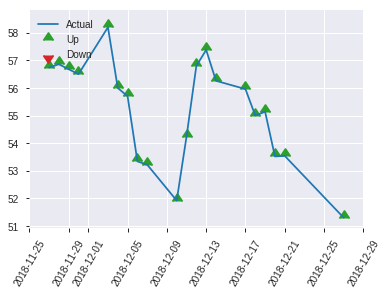


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24265896374521764
RMSE: 0.4926042668767879
LogLoss: 0.678304666330358
Mean Per-Class Error: 0.40714285714285714
AUC: 0.5783673469387755
pr_auc: 0.4449270913277838
Gini: 0.1567346938775509
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42710888385772705: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      42   105  0.7143   (105.0/147.0)
1      10   90   0.1      (10.0/100.0)
Total  52   195  0.4656   (115.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.427109     0.610169  194
max f2                       0.296419     0.773994  245
max f0point5                 0.427109     0.511364  194
max accuracy                 0.60422      0.603239  9
max precision                0.60422      0.6       9
max recall                   0.296419     1         245
max specificity              0.643784     0.993197  0
max absolute_mcc             0.427109     0.223607  194
max min_per_class_accuracy   0.484199     0.544218  121
max mean_per_class_accuracy  0.427109     0.592857  194

Gains/Lift Table: Avg response rate: 40.49 %, avg score: 48.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.623949           0.823333  0.823333           0.333333         0.634221  0.333333                    0.634221            0.01            0.01                       -17.6667  -17.6667
    2        0.0202429                   0.620892           0         0.494              0                0.621712  0.2                         0.629217            0               0.01                       -100      -50.6
    3        0.0323887                   0.605796           2.47      1.235              1                0.612257  0.5                         0.622857            0.03            0.04                       147       23.5
    4        0.0404858                   0.603405           2.47      1.482              1                0.604618  0.6                         0.619209            0.02            0.06                       147       48.2
    5        0.0526316                   0.590826           0         1.14               0                0.598326  0.461538                    0.61439             0               0.06                       -100      14
    6        0.101215                    0.569335           0.823333  0.988              0.333333         0.579006  0.4                         0.597406            0.04            0.1                        -17.6667  -1.2
    7        0.149798                    0.551644           1.235     1.06811            0.5              0.5595    0.432432                    0.585112            0.06            0.16                       23.5      6.81081
    8        0.202429                    0.541235           1.14      1.0868             0.461538         0.547381  0.44                        0.575302            0.06            0.22                       14        8.68
    9        0.299595                    0.518301           1.33792   1.16824            0.541667         0.530751  0.472973                    0.560853            0.13            0.35                       33.7917   16.8243
    10       0.40081                     0.50171            1.0868    1.14768            0.44             0.508453  0.464646                    0.547621            0.11            0.46                       8.68      14.7677
    11       0.502024                    0.483506           1.0868    1.1354             0.44             0.491106  0.459677                    0.536227            0.11            0.57                       8.68      13.5403
    12       0.59919                     0.469777           0.720417  1.06811            0.291667         0.474535  0.432432                    0.526223            0.07            0.64                       -27.9583  6.81081
    13       0.700405                    0.445745           1.5808    1.1422             0.64             0.458822  0.462428                    0.516483            0.16            0.8                        58.08     14.2197
    14       0.797571                    0.424939           1.02917   1.12843            0.416667         0.436338  0.456853                    0.506719            0.1             0.9                        2.91667   12.8426
    15       0.898785                    0.394653           0.494     1.05698            0.2              0.409367  0.427928                    0.495756            0.05            0.95                       -50.6     5.6982
    16       1                           0.2871             0.494     1                  0.2              0.357987  0.404858                    0.481812            0.05            

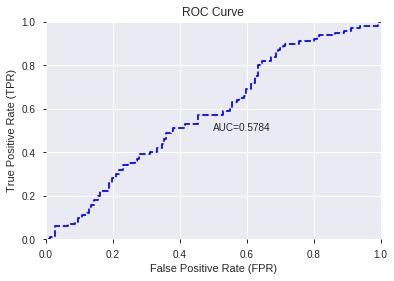

This function is available for GLM models only


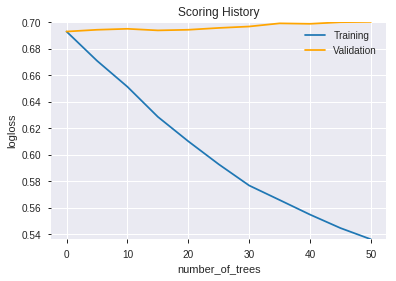

--2019-08-28 17:31:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190828_173046',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190828_173046',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a241',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_a241',
   'type

['BOP',
 'TAN',
 'CORREL_20',
 'OBV',
 'MACD_hist',
 'MACDEXT_signal',
 'HT_PHASOR_quadrature',
 'BETA_8',
 'Volume',
 'MFI_24',
 'STOCH_slowd',
 'day',
 'week',
 'MFI_20',
 'HT_PHASOR_inphase',
 'dayofyear',
 'SAREXT',
 'COS',
 'CORREL_8',
 'BBANDS_lowerband_8_4_5',
 'CORREL_14',
 'SIN',
 'STDDEV_8',
 'TRANGE',
 'MINUS_DI_8',
 'ROC_14',
 'CORREL_24',
 'ADX_14',
 'CORREL_30',
 'HT_DCPERIOD',
 'PLUS_DI_14',
 'LINEARREG_ANGLE_8',
 'BETA_30',
 'ADXR_12',
 'MACDFIX_hist_24',
 'MINUS_DI_20',
 'SUB',
 'BETA_20',
 'PPO',
 'LINEARREG_ANGLE_30',
 'MFI_8',
 'MACDFIX_signal_20',
 'ROC_30',
 'DX_14',
 'AROONOSC_8',
 'STOCHRSI_fastd',
 'NATR_8',
 'VAR_8',
 'WILLR_30',
 'STOCH_slowk',
 'MFI_12',
 'ATR_8',
 'BBANDS_lowerband_30_5_5',
 'NATR_30',
 'CORREL_12',
 'DIV',
 'CMO_14',
 'STOCHRSI_fastk',
 'VAR_12',
 'TRIX_8',
 'CCI_8',
 'LINEARREG_SLOPE_30',
 'MOM_30',
 'CCI_12',
 'MOM_8',
 'CMO_8',
 'ADOSC',
 'aroondown_24',
 'BBANDS_lowerband_14_6_3',
 'PLUS_DM_24',
 'aroondown_8',
 'aroondown_14',
 'PLUS_

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

84

['BBANDS_upperband_12_7_5',
 'MAVP_14_0',
 'BBANDS_lowerband_14_0_2',
 'MAVP_14_1',
 'BBANDS_upperband_14_1_3',
 'BBANDS_middleband_14_1_3',
 'BBANDS_lowerband_14_5_5',
 'MAVP_14_6',
 'BBANDS_lowerband_14_7_5',
 'BBANDS_upperband_20_1_3',
 'MAVP_20_2',
 'MAVP_20_3',
 'BBANDS_lowerband_20_3_2',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_lowerband_20_6_2',
 'BBANDS_lowerband_20_7_3',
 'BOP',
 'aroondown_8',
 'AROONOSC_8',
 'CMO_8',
 'MACDFIX_hist_8',
 'MOM_8',
 'ROC_8',
 'ROCR_8',
 'WILLR_8',
 'aroondown_12',
 'AROONOSC_12',
 'CCI_12',
 'DX_12',
 'MINUS_DM_12',
 'PLUS_DM_12',
 'ROCR_12',
 'ROCR100_12',
 'aroondown_14',
 'AROONOSC_14',
 'CCI_14',
 'CMO_14',
 'DX_14',
 'MACDFIX_hist_14',
 'MFI_14',
 'PLUS_DI_14',
 'PLUS_DM_14',
 'ROCR100_14',
 'WILLR_14',
 'aroondown_20',
 'AROONOSC_20',
 'CMO_20',
 'MOM_20',
 'ROC_20',
 'ROCP_20',
 'ROCR100_20',
 'RSI_20',
 'WILLR_20',
 'ADX_24',
 'aroondown_24',
 'aroonup_24',
 'MINUS_DM_24',
 'PLUS_DI_24',
 'PLUS_DM_24',
 'ROCR100_24',
 'RSI_24',
 'WILLR_24',

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_173327_model_1  0.617211  1.108729              0.446565  0.573713  0.329147
1  DeepLearning_grid_1_AutoML_20190828_173327_model_4  0.598844  0.794995              0.486190  0.513102  0.263274
2  DeepLearning_grid_1_AutoML_20190828_173327_model_2  0.591088  0.803700              0.460170  0.533251  0.284357
3  DeepLearning_grid_1_AutoML_20190828_173327_model_3  0.589116  0.678875              0.475986  0.492303  0.242362
4               DeepLearning_1_AutoML_20190828_173327  0.565170  0.742453              0.468980  0.520760  0.271191
5  DeepLearning_grid_1_AutoML_20190828_173327_model_8  0.564898  0.700019              0.493197  0.503422  0.253434
6  DeepLearning_grid_1_AutoML_20190828_173327_model_5  0.545850  0.711822              0.500000  0.509155  0.259239
7  DeepLearning_grid_1_AutoML_20190828_173327_model_6  0.541973  0.697885              0.496599  0.502208  0.252213
8  DeepLearning_grid_1_AutoML_20190828_173327_model_7  0.501905  0.711772              0.500000  0.508951  0.259031
9  DeepLearning_grid_1_AutoML_20190828_173327_model_9  0.457279  0.692680              0.489796  0.499766  0.249766

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.014206
1                   CORREL_8             0.954618           0.954618    0.013562
2                      VAR_8             0.925957           0.925957    0.013154
3                 aroonup_24             0.919803           0.919803    0.013067
4                     MFI_14             0.914050           0.914050    0.012985
..                       ...                  ...                ...         ...
79                PLUS_DM_24             0.787740           0.787740    0.011191
80  BBANDS_middleband_14_1_3             0.787164           0.787164    0.011183
81                    CMO_14             0.786315           0.786315    0.011171
82   BBANDS_lowerband_20_6_2             0.760240           0.760240    0.010800
83   BBANDS_lowerband_20_7_3             0.725628           0.725628    0.010309

[84 rows x 4 columns]

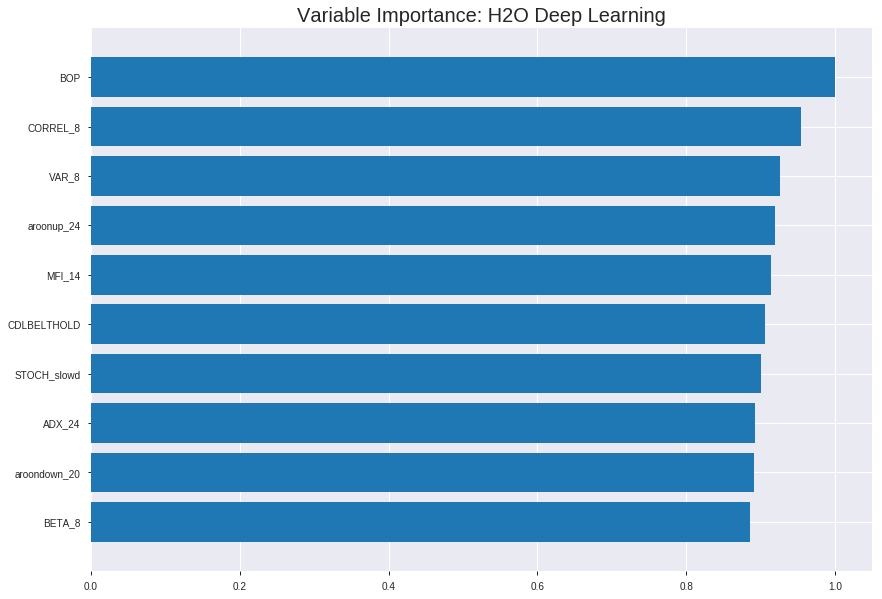

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_173327_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.28420525248094514
RMSE: 0.5331090437058306
LogLoss: 1.0082518707047265
Mean Per-Class Error: 0.3749924645431637
AUC: 0.6456553570065013
pr_auc: 0.6078085263697477
Gini: 0.2913107140130027
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.006103143516942196: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      31   828   0.9639   (828.0/859.0)
1      12   857   0.0138   (12.0/869.0)
Total  43   1685  0.4861   (840.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00610314   0.671104  394
max f2                       0.000489365  0.834935  399
max f0point5                 0.506161     0.62717   191
max accuracy                 0.506161     0.625     191
max precision                0.998029     0.707692  2
max recall                   0.000489365  1         399
max specificity              0.99977      0.988359  0
max absolute_mcc             0.506161     0.250011  191
max min_per_class_accuracy   0.506161     0.623705  191
max mean_per_class_accuracy  0.506161     0.625008  191

Gains/Lift Table: Avg response rate: 50.29 %, avg score: 51.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.999802           1.10472   1.10472            0.555556         0.999936   0.555556                    0.999936            0.0115075       0.0115075                  10.4718   10.4718
    2        0.0202546                   0.999065           1.75455   1.42035            0.882353         0.999438   0.714286                    0.999694            0.0172612       0.0287687                  75.4552   42.0352
    3        0.0300926                   0.998224           1.28667   1.37665            0.647059         0.998725   0.692308                    0.999377            0.0126582       0.0414269                  28.6672   37.6649
    4        0.0405093                   0.997011           1.65708   1.44876            0.833333         0.99776    0.728571                    0.998961            0.0172612       0.0586881                  65.7077   44.8759
    5        0.0503472                   0.99544            1.1697    1.39423            0.588235         0.996285   0.701149                    0.998439            0.0115075       0.0701956                  16.9701   39.423
    6        0.100116                    0.982327           1.24859   1.32183            0.627907         0.989044   0.66474                     0.993769            0.0621404       0.132336                   24.8588   32.183
    7        0.150463                    0.957733           1.41709   1.3537             0.712644         0.971298   0.680769                    0.98625             0.0713464       0.203682                   41.7087   35.3705
    8        0.200231                    0.923433           1.20234   1.31608            0.604651         0.940703   0.66185                     0.974929            0.0598389       0.263521                   20.2344   31.6083
    9        0.300347                    0.81838            1.25287   1.29501            0.630058         0.879222   0.651252                    0.943026            0.125432        0.388953                   25.2865   29.5011
    10       0.399884                    0.669561           1.27171   1.28921            0.639535         0.748703   0.648336                    0.894657            0.126582        0.515535                   27.171    28.9211
    11       0.5                         0.50347            1.08045   1.24741            0.543353         0.579032   0.627315                    0.831459            0.10817         0.623705                   8.04526   24.7411
    12       0.600116                    0.35791            0.793098  1.17162            0.398844         0.425173   0.5892                      0.763679            0.0794016       0.703107                   -20.6902  17.1619
    13       0.699653                    0.217377           0.936441  1.13816            0.47093          0.286556   0.572374                    0.695801            0.0932106       0.796318                   -6.35588  13.8161
    14       0.799769                    0.118662           0.63218   1.07482            0.317919         0.162521   0.540521                    0.629044            0.0632911       0.859609                   -36.782   7.48219
    15       0.899884                    0.0407582          0.712639  1.03453            0.358382         0.0778553  0.520257                    0.567722            0.0713464       0.930955                   -28.7361  3.45276
    16       1                           0.000109637        0.689651  1                  0.346821         0.0160963  0.502894                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3263874884085797
RMSE: 0.5713033243458152
LogLoss: 0.9898795580280257
Mean Per-Class Error: 0.4740513392857143
AUC: 0.5191537552521008
pr_auc: 0.5283542935844338
Gini: 0.03830751050420167
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0025513803449459583: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    234  0.9832   (234.0/238.0)
1      0    256  0        (0.0/256.0)
Total  4    490  0.4737   (234.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00255138   0.686327   396
max f2                       0.00255138   0.845443   396
max f0point5                 0.101425     0.581731   369
max accuracy                 0.101425     0.538462   369
max precision                0.996633     1          0
max recall                   0.00255138   1          396
max specificity              0.996633     1          0
max absolute_mcc             0.00255138   0.0937051  396
max min_per_class_accuracy   0.574605     0.512605   195
max mean_per_class_accuracy  0.634044     0.525949   174

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 55.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.991711           1.15781   1.15781            0.6              0.99483    0.6                         0.99483             0.0117188       0.0117188                  15.7812   15.7812
    2        0.0202429                   0.987699           0.771875  0.964844           0.4              0.990168   0.5                         0.992499            0.0078125       0.0195312                  -22.8125  -3.51562
    3        0.0303644                   0.981864           1.92969   1.28646            1                0.984114   0.666667                    0.989704            0.0195312       0.0390625                  92.9688   28.6458
    4        0.0404858                   0.974404           1.15781   1.2543             0.6              0.978629   0.65                        0.986935            0.0117188       0.0507812                  15.7812   25.4297
    5        0.0506073                   0.963387           1.54375   1.31219            0.8              0.969789   0.68                        0.983506            0.015625        0.0664062                  54.375    31.2188
    6        0.101215                    0.923398           0.6175    0.964844           0.32             0.939619   0.5                         0.961563            0.03125         0.0976562                  -38.25    -3.51562
    7        0.149798                    0.885919           0.964844  0.964844           0.5              0.902814   0.5                         0.942509            0.046875        0.144531                   -3.51562  -3.51562
    8        0.200405                    0.846216           1.00344   0.97459            0.52             0.867139   0.505051                    0.923476            0.0507812       0.195312                   0.34375   -2.54104
    9        0.299595                    0.785622           1.0633    1.00396            0.55102          0.819706   0.52027                     0.88912             0.105469        0.300781                   6.32972   0.395904
    10       0.40081                     0.678711           1.19641   1.05256            0.62             0.731061   0.545455                    0.849206            0.121094        0.421875                   19.6406   5.25568
    11       0.5                         0.575172           0.905772  1.02344            0.469388         0.630197   0.530364                    0.805759            0.0898438       0.511719                   -9.42283  2.34375
    12       0.59919                     0.486168           1.02392   1.02352            0.530612         0.532871   0.530405                    0.760585            0.101562        0.613281                   2.39158   2.35167
    13       0.700405                    0.348789           0.964844  1.01504            0.5              0.420354   0.526012                    0.711418            0.0976562       0.710938                   -3.51562  1.50379
    14       0.799595                    0.244828           0.984534  1.01125            0.510204         0.293127   0.524051                    0.659529            0.0976562       0.808594                   -1.54656  1.1254
    15       0.898785                    0.12533            1.0633    1.017              0.55102          0.188702   0.527027                    0.607568            0.105469        0.914062                   6.32972   1.69975
    16       1                           0.00051359         0.849062  1                  0.44             0.0559598  0.518219               


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:33:28  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 17:33:33  5.156 sec         1966 obs/sec      5.69676   1             9844       0.626816         1.65246             -0.571646      0.532469        0.518306           1.10472          0.497106                         0.639572           1.59414               -0.638383        0.496717          0.521236             1.54375            0.473684
    2019-08-28 17:33:43  14.512 sec        2069 obs/sec      17.0706   3             29498      0.56957          1.1256              -0.297682      0.611216        0.596833           1.76755          0.482639                         0.62449            1.36166               -0.562023        0.507944          0.520193             0.385938           0.477733
    2019-08-28 17:33:52  23.405 sec        2132 obs/sec      28.4346   5             49135      0.533109         1.00825             -0.136859      0.645655        0.607809           1.10472          0.486111                         0.571303           0.98988               -0.307286        0.519154          0.528354             1.15781            0.473684
    2019-08-28 17:34:00  31.960 sec        2184 obs/sec      39.7894   7             68756      0.465466         0.652198            0.133338       0.74354         0.738969           1.87802          0.341435                         0.598406           1.09762               -0.434263        0.496849          0.519581             1.15781            0.475709
    2019-08-28 17:34:09  40.201 sec        2232 obs/sec      51.1522   9             88391      0.464028         0.660479            0.138682       0.759912        0.734286           1.65708          0.336227                         0.599632           1.11095               -0.440146        0.497587          0.527182             1.15781            0.477733
    2019-08-28 17:34:17  48.268 sec        2272 obs/sec      62.5104   11            108018     0.4929           0.77365             0.0281647      0.729478        0.702471           1.76755          0.378472                         0.615231           1.21682               -0.516048        0.488093          0.519896             1.15781            0.479757
    2019-08-28 17:34:25  56.191 sec        2305 obs/sec      73.8698   13            127647     0.442468         0.631042            0.216861       0.789173        0.744861           1.76755          0.279514                         0.595659           1.08009               -0.421125        0.486074          0.518445             1.15781            0.475709
    2019-08-28 17:34:32  1 min  4.084 sec  2333 obs/sec      85.2558   15            147322     0.472801         0.775731            0.105806       0.768417        0.758147           1.65708          0.314236                         0.608088           1.21944               -0.48105         0.49062           0.525527             1.92969            0.477733
    2019-08-28 17:34:33

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
BOP                       1.0                    1.0                  0.014206338637998143
CORREL_8                  0.9546182751655579     0.9546182751655579   0.013561630487023607
VAR_8                     0.9259570837020874     0.9259570837020874   0.013154459895325044
aroonup_24                0.919802725315094      0.919802725315094    0.013067028995979812
MFI_14                    0.914050281047821      0.914050281047821    0.012985307824722722
---                       ---                    ---                  ---
PLUS_DM_24                0.7877396941184998     0.7877396941184998   0.01119089685324048
BBANDS_middleband_14_1_3  0.7871640920639038     0.7871640920639038   0.011182719655532164
CMO_14                    0.786315381526947      0.786315381526947    0.01117066258623852
BBANDS_lowerband_20_6_2   0.7602397799491882     0.7602397799491882   0.010800223760035359
BBANDS_lowerband_20_7_3   0.7256282567977905     0.7256282567977905   0.01030852074136969


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6437246963562753)

('F1', 0.5923566878980892)

('auc', 0.6172108843537415)

('logloss', 1.1087287206275727)

('mean_per_class_error', 0.3776870748299319)

('rmse', 0.5737132716982561)

('mse', 0.329146918122717)

deeplearning prediction progress: |███████████████████████████████████████| 100%


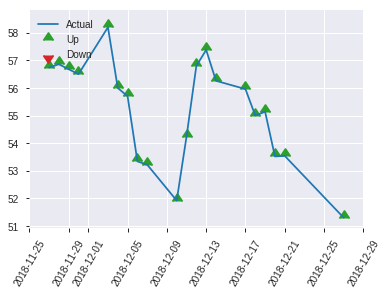


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.329146918122717
RMSE: 0.5737132716982561
LogLoss: 1.1087287206275727
Mean Per-Class Error: 0.3776870748299319
AUC: 0.6172108843537415
pr_auc: 0.5092653622370963
Gini: 0.234421768707483
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1625008491601505: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      26   121  0.8231   (121.0/147.0)
1      7    93   0.07     (7.0/100.0)
Total  33   214  0.5182   (128.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.162501     0.592357  213
max f2                       0.0181315    0.782473  238
max f0point5                 0.617923     0.541401  131
max accuracy                 0.972847     0.643725  37
max precision                0.999745     1         0
max recall                   0.0181315    1         238
max specificity              0.999745     1         0
max absolute_mcc             0.617923     0.240727  131
max min_per_class_accuracy   0.713504     0.591837  119
max mean_per_class_accuracy  0.617923     0.622313  131

Gains/Lift Table: Avg response rate: 40.49 %, avg score: 60.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.998611           1.64667   1.64667            0.666667         0.999203   0.666667                    0.999203            0.02            0.02                       64.6667   64.6667
    2        0.0202429                   0.998511           1.235     1.482              0.5              0.998538   0.6                         0.998937            0.01            0.03                       23.5      48.2
    3        0.0323887                   0.996965           0.823333  1.235              0.333333         0.997648   0.5                         0.998454            0.01            0.04                       -17.6667  23.5
    4        0.0404858                   0.996529           1.235     1.235              0.5              0.996743   0.5                         0.998112            0.01            0.05                       23.5      23.5
    5        0.0526316                   0.994914           2.47      1.52               1                0.995743   0.615385                    0.997565            0.03            0.08                       147       52
    6        0.101215                    0.985087           1.235     1.3832             0.5              0.990516   0.56                        0.994182            0.06            0.14                       23.5      38.32
    7        0.149798                    0.9729             2.05833   1.60216            0.833333         0.979868   0.648649                    0.989539            0.1             0.24                       105.833   60.2162
    8        0.202429                    0.957016           0.57      1.3338             0.230769         0.96483    0.54                        0.983115            0.03            0.27                       -43       33.38
    9        0.299595                    0.900197           1.235     1.30176            0.5              0.922475   0.527027                    0.963448            0.12            0.39                       23.5      30.1757
    10       0.40081                     0.811554           0.8892    1.19758            0.36             0.864835   0.484848                    0.938546            0.09            0.48                       -11.08    19.7576
    11       0.502024                    0.665221           1.3832    1.235              0.56             0.756627   0.5                         0.901869            0.14            0.62                       38.32     23.5
    12       0.59919                     0.500245           0.823333  1.16824            0.333333         0.579277   0.472973                    0.849556            0.08            0.7                        -17.6667  16.8243
    13       0.700405                    0.386494           0.7904    1.11364            0.32             0.436968   0.450867                    0.789934            0.08            0.78                       -20.96    11.3642
    14       0.797571                    0.25447            0.514583  1.04066            0.208333         0.327495   0.42132                     0.733596            0.05            0.83                       -48.5417  4.06599
    15       0.898785                    0.11867            0.988     1.03473            0.4              0.189467   0.418919                    0.67232             0.1             0.93                       -1.2      3.47297
    16       1                           0.00193454         0.6916    1                  0.28             0.0448351  0.404858                    0.60881             

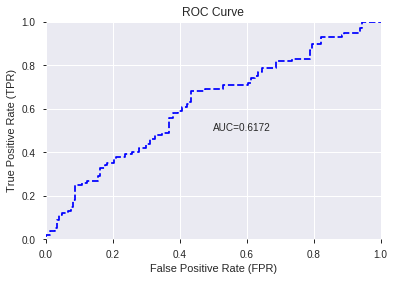

This function is available for GLM models only


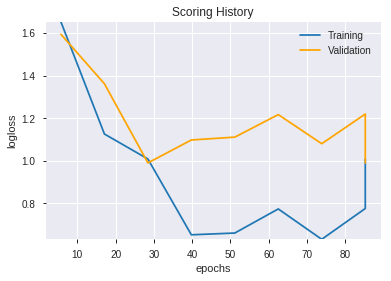

--2019-08-28 17:41:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.86.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.86.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_173327_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_173327_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a241',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CORREL_8',
 'VAR_8',
 'aroonup_24',
 'MFI_14',
 'CDLBELTHOLD',
 'STOCH_slowd',
 'ADX_24',
 'aroondown_20',
 'BETA_8',
 'WILLR_8',
 'CDLHARAMI',
 'CDLHIKKAKE',
 'MACDFIX_hist_14',
 'STOCHF_fastk',
 'aroondown_8',
 'aroondown_30',
 'ROCR_12',
 'MOM_20',
 'MOM_30',
 'PLUS_DM_14',
 'PLUS_DM_30',
 'BBANDS_lowerband_14_5_5',
 'MACDFIX_hist_8',
 'PLUS_DM_12',
 'ATR_14',
 'WILLR_24',
 'DX_14',
 'RSI_20',
 'AROONOSC_8',
 'ROCR100_12',
 'AROONOSC_20',
 'BBANDS_lowerband_14_7_5',
 'aroondown_12',
 'AROONOSC_12',
 'LINEARREG_INTERCEPT_8',
 'DX_12',
 'MAVP_14_0',
 'WILLR_14',
 'ROCP_20',
 'ULTOSC',
 'LINEARREG_ANGLE_8',
 'MAVP_20_2',
 'LINEARREG_SLOPE_8',
 'MFI_30',
 'aroondown_14',
 'AROONOSC_14',
 'MINUS_DM_12',
 'CMO_8',
 'CCI_14',
 'aroondown_24',
 'ROC_20',
 'CMO_20',
 'MAVP_14_1',
 'BBANDS_lowerband_20_5_5',
 'ROCR100_14',
 'ROC_30',
 'BBANDS_upperband_12_7_5',
 'MACD',
 'PLUS_DI_14',
 'MOM_8',
 'WILLR_30',
 'MAVP_20_3',
 'MACDEXT_signal',
 'MAVP_14_6',
 'PLUS_DI_24',
 'ROC_8',
 'MI

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190828_174204_model_1  0.507891  0.687834              0.489796  0.49734  0.247347

variable  relative_importance  scaled_importance  percentage
0            BOP             0.024441           1.000000    0.050273
1   STOCHF_fastk             0.017999           0.736414    0.037022
2         BETA_8             0.017217           0.704404    0.035413
3   aroondown_12             0.016143           0.660463    0.033204
4   aroondown_14             0.014739           0.603022    0.030316
..           ...                  ...                ...         ...
79      CORREL_8             0.001219           0.049894    0.002508
80    ROCR100_12             0.001199           0.049041    0.002465
81  aroondown_24             0.000974           0.039854    0.002004
82        MFI_14             0.000895           0.036623    0.001841
83         MOM_8             0.000667           0.027310    0.001373

[84 rows x 4 columns]

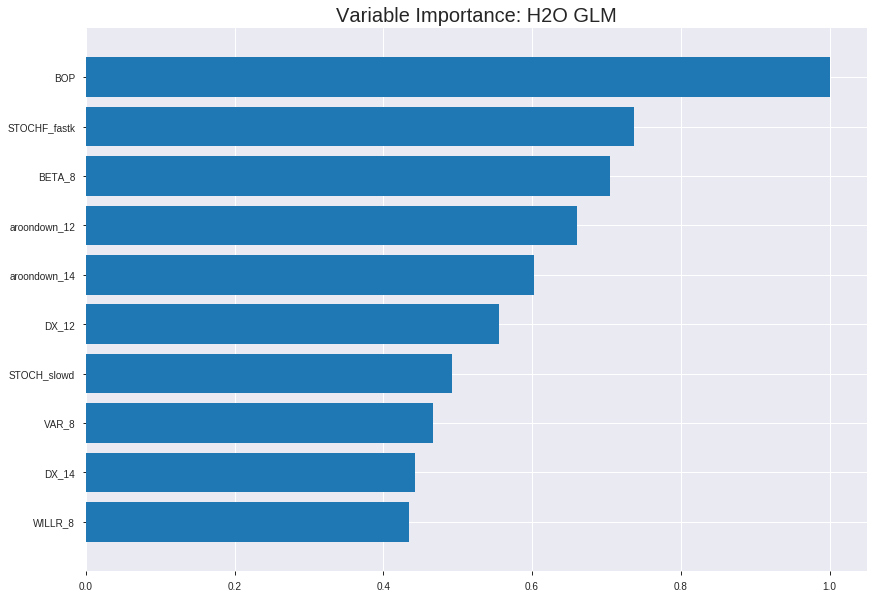

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_174204_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24717636719580696
RMSE: 0.4971683489481274
LogLoss: 0.6874858771701275
Null degrees of freedom: 1727
Residual degrees of freedom: 1643
Null deviance: 2395.458785321781
Residual deviance: 2375.9511914999607
AIC: 2545.9511914999607
AUC: 0.5710503154174777
pr_auc: 0.5669272902041141
Gini: 0.1421006308349555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4445697229471622: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      25   834   0.9709   (834.0/859.0)
1      12   857   0.0138   (12.0/869.0)
Total  37   1691  0.4896   (846.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44457      0.669531  374
max f2                       0.415836     0.834935  399
max f0point5                 0.466748     0.567181  321
max accuracy                 0.517157     0.554977  145
max precision                0.585554     1         0
max recall                   0.415836     1         399
max specificity              0.585554     1         0
max absolute_mcc             0.517157     0.118789  145
max min_per_class_accuracy   0.502906     0.543655  199
max mean_per_class_accuracy  0.517157     0.55595   145

Gains/Lift Table: Avg response rate: 50.29 %, avg score: 50.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.564882           1.43613   1.43613            0.722222         0.572304  0.722222                    0.572304            0.0149597       0.0149597                  43.6133   43.6133
    2        0.0202546                   0.559514           1.1697    1.30672            0.588235         0.562158  0.657143                    0.567376            0.0115075       0.0264672                  16.9701   30.6724
    3        0.0300926                   0.556289           1.40364   1.33841            0.705882         0.557962  0.673077                    0.564298            0.013809        0.0402762                  40.3642   33.8408
    4        0.0405093                   0.553497           1.10472   1.27832            0.555556         0.554916  0.642857                    0.561886            0.0115075       0.0517837                  10.4718   27.8317
    5        0.0503472                   0.551003           1.1697    1.25709            0.588235         0.551859  0.632184                    0.559927            0.0115075       0.0632911                  16.9701   25.7093
    6        0.100116                    0.542059           1.27171   1.26436            0.639535         0.546575  0.635838                    0.553289            0.0632911       0.126582                   27.171    26.4359
    7        0.150463                    0.534959           1.23424   1.25428            0.62069          0.538373  0.630769                    0.548298            0.0621404       0.188723                   23.4237   25.428
    8        0.200231                    0.529064           1.06361   1.20689            0.534884         0.531946  0.606936                    0.544234            0.0529344       0.241657                   6.36123   20.6889
    9        0.300347                    0.52008            1.09195   1.16857            0.549133         0.524487  0.587669                    0.537652            0.109321        0.350978                   9.19468   16.8575
    10       0.399884                    0.511813           1.04049   1.13669            0.523256         0.515756  0.571635                    0.532202            0.103567        0.454545                   4.04903   13.6693
    11       0.5                         0.502941           0.90804   1.09091            0.456647         0.506997  0.548611                    0.527155            0.0909091       0.545455                   -9.19601  9.09091
    12       0.600116                    0.49514            1.01149   1.07766            0.508671         0.499056  0.541948                    0.522467            0.101266        0.64672                    1.14875   7.76594
    13       0.699653                    0.486104           0.890197  1.05099            0.447674         0.491114  0.528536                    0.518007            0.0886076       0.735328                   -10.9803  5.09898
    14       0.799769                    0.476809           0.931028  1.03597            0.468208         0.481916  0.520984                    0.513489            0.0932106       0.828539                   -6.89717  3.59729
    15       0.899884                    0.46283            0.942522  1.02558            0.473988         0.470145  0.515756                    0.508667            0.0943613       0.9229                     -5.74775  2.55762
    16       1                           0.415836           0.77011   1                  0.387283         0.451002  0.502894                    0.502894          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24933768589922445
RMSE: 0.4993372466572311
LogLoss: 0.6918250341506411
Null degrees of freedom: 493
Residual degrees of freedom: 409
Null deviance: 684.6376229712456
Residual deviance: 683.5231337408335
AIC: 853.5231337408335
AUC: 0.5229204963235294
pr_auc: 0.5263803673624314
Gini: 0.045840992647058876
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4758422717268287: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    236  0.9916   (236.0/238.0)
1      1    255  0.0039   (1.0/256.0)
Total  3    491  0.4798   (237.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.475842     0.682731   396
max f2                       0.467432     0.843215   399
max f0point5                 0.485403     0.578532   379
max accuracy                 0.509943     0.550607   244
max precision                0.540142     0.586667   69
max recall                   0.467432     1          399
max specificity              0.568645     0.995798   0
max absolute_mcc             0.509943     0.0952269  244
max min_per_class_accuracy   0.518523     0.508403   195
max mean_per_class_accuracy  0.509943     0.546169   244

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 51.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.563085           0.385938  0.385938           0.2              0.566691  0.2                         0.566691            0.00390625      0.00390625                 -61.4062  -61.4062
    2        0.0202429                   0.558595           0.771875  0.578906           0.4              0.561098  0.3                         0.563895            0.0078125       0.0117188                  -22.8125  -42.1094
    3        0.0303644                   0.555539           1.54375   0.900521           0.8              0.557494  0.466667                    0.561761            0.015625        0.0273438                  54.375    -9.94792
    4        0.0404858                   0.553833           1.54375   1.06133            0.8              0.55483   0.55                        0.560028            0.015625        0.0429688                  54.375    6.13281
    5        0.0506073                   0.552153           0.771875  1.00344            0.4              0.553176  0.52                        0.558658            0.0078125       0.0507812                  -22.8125  0.34375
    6        0.101215                    0.54514            0.92625   0.964844           0.48             0.54791   0.5                         0.553284            0.046875        0.0976562                  -7.375    -3.51562
    7        0.149798                    0.540126           1.44727   1.1213             0.75             0.542787  0.581081                    0.54988             0.0703125       0.167969                   44.7266   12.1305
    8        0.200405                    0.535509           0.849062  1.05256            0.44             0.537779  0.545455                    0.546824            0.0429688       0.210938                   -15.0938  5.25568
    9        0.299595                    0.528828           0.984534  1.03004            0.510204         0.532511  0.533784                    0.542085            0.0976562       0.308594                   -1.54656  3.00359
    10       0.40081                     0.523256           0.92625   1.00383            0.48             0.526232  0.520202                    0.538082            0.09375         0.402344                   -7.375    0.382734
    11       0.5                         0.518523           1.10268   1.02344            0.571429         0.521111  0.530364                    0.534715            0.109375        0.511719                   10.2679   2.34375
    12       0.59919                     0.511235           1.22082   1.05611            0.632653         0.515242  0.547297                    0.531492            0.121094        0.632812                   22.0823   5.61128
    13       0.700405                    0.505232           1.00344   1.0485             0.52             0.508092  0.543353                    0.52811             0.101562        0.734375                   0.34375   4.85007
    14       0.799595                    0.49896            0.827009  1.02102            0.428571         0.502446  0.529114                    0.524927            0.0820312       0.816406                   -17.2991  2.10245
    15       0.898785                    0.492554           0.905772  1.00831            0.469388         0.496058  0.522523                    0.521741            0.0898438       0.90625                    -9.42283  0.830518
    16       1                           0.467432           0.92625   1                  0.48             0.485648  0.518219                    0.518087   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 17:42:05  0.000 sec   2            3.7       85            1.38098           1.38453
    2019-08-28 17:42:05  0.052 sec   4            2.3       85            1.37927           1.38412
    2019-08-28 17:42:05  0.088 sec   6            1.4       85            1.37725           1.38378
    2019-08-28 17:42:05  0.116 sec   8            0.89      85            1.37497           1.38365
    2019-08-28 17:42:05  0.144 sec   10           0.55      85            1.37252           1.38385
    2019-08-28 17:42:05  0.174 sec   12           0.34      85            1.36994           1.38446
    2019-08-28 17:42:05  0.201 sec   14           0.21      85            1.36725           1.3854
    2019-08-28 17:42:05  0.236 sec   16           0.13      85            1.36447           1.38668
    2019-08-28 17:42:05  0.272 sec   18           0.082     85            1.36162           1.38816

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6072874493927125)

('F1', 0.5813953488372093)

('auc', 0.507891156462585)

('logloss', 0.6878344375768208)

('mean_per_class_error', 0.4582312925170068)

('rmse', 0.49733995797693614)

('mse', 0.24734703380050063)

glm prediction progress: |████████████████████████████████████████████████| 100%


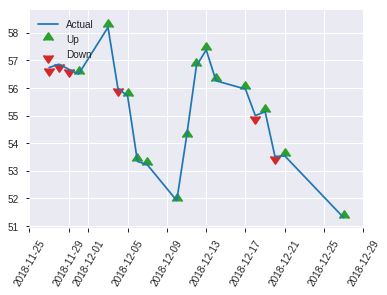


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24734703380050063
RMSE: 0.49733995797693614
LogLoss: 0.6878344375768208
Null degrees of freedom: 246
Residual degrees of freedom: 162
Null deviance: 342.9669668693666
Residual deviance: 339.79021216294944
AIC: 509.79021216294944
AUC: 0.507891156462585
pr_auc: 0.4233896105829622
Gini: 0.01578231292516996
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44733430569367766: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    144  0.9796   (144.0/147.0)
1      0    100  0        (0.0/100.0)
Total  3    244  0.583    (144.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447334     0.581395  243
max f2                       0.447334     0.776398  243
max f0point5                 0.447334     0.464684  243
max accuracy                 0.521515     0.607287  12
max precision                0.538622     1         0
max recall                   0.447334     1         243
max specificity              0.538622     1         0
max absolute_mcc             0.509765     0.110772  30
max min_per_class_accuracy   0.483745     0.49      122
max mean_per_class_accuracy  0.502694     0.541769  46

Gains/Lift Table: Avg response rate: 40.49 %, avg score: 48.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.534798           0.823333  0.823333           0.333333         0.537973  0.333333                    0.537973            0.01            0.01                       -17.6667  -17.6667
    2        0.0202429                   0.527871           1.235     0.988              0.5              0.531031  0.4                         0.535196            0.01            0.02                       23.5      -1.2
    3        0.0323887                   0.526715           1.64667   1.235              0.666667         0.527331  0.5                         0.532247            0.02            0.04                       64.6667   23.5
    4        0.0404858                   0.523101           1.235     1.235              0.5              0.525448  0.5                         0.530887            0.01            0.05                       23.5      23.5
    5        0.0526316                   0.521391           2.47      1.52               1                0.522057  0.615385                    0.528849            0.03            0.08                       147       52
    6        0.101215                    0.512971           1.02917   1.2844             0.416667         0.516866  0.52                        0.523097            0.05            0.13                       2.91667   28.44
    7        0.149798                    0.507192           1.02917   1.20162            0.416667         0.509557  0.486486                    0.518706            0.05            0.18                       2.91667   20.1622
    8        0.202429                    0.500401           1.14      1.1856             0.461538         0.503837  0.48                        0.51484             0.06            0.24                       14        18.56
    9        0.299595                    0.495535           0.6175    1.00135            0.25             0.498016  0.405405                    0.509383            0.06            0.3                        -38.25    0.135135
    10       0.40081                     0.489236           0.7904    0.948081           0.32             0.492395  0.383838                    0.505093            0.08            0.38                       -20.96    -5.19192
    11       0.502024                    0.48351            1.0868    0.976048           0.44             0.485969  0.395161                    0.501238            0.11            0.49                       8.68      -2.39516
    12       0.59919                     0.479086           1.235     1.01804            0.5              0.481413  0.412162                    0.498023            0.12            0.61                       23.5      1.80405
    13       0.700405                    0.475503           1.0868    1.02798            0.44             0.477382  0.416185                    0.49504             0.11            0.72                       8.68      2.79769
    14       0.797571                    0.471004           0.720417  0.990508           0.291667         0.473807  0.401015                    0.492453            0.07            0.79                       -27.9583  -0.949239
    15       0.898785                    0.460844           0.988     0.990225           0.4              0.466051  0.400901                    0.48948             0.1             0.89                       -1.2      -0.977477
    16       1                           0.441473           1.0868    1                  0.44             0.453135  0.404858                    0.485801            0.11   

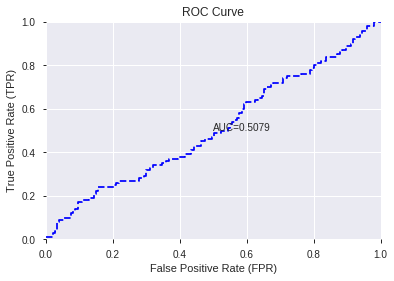

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


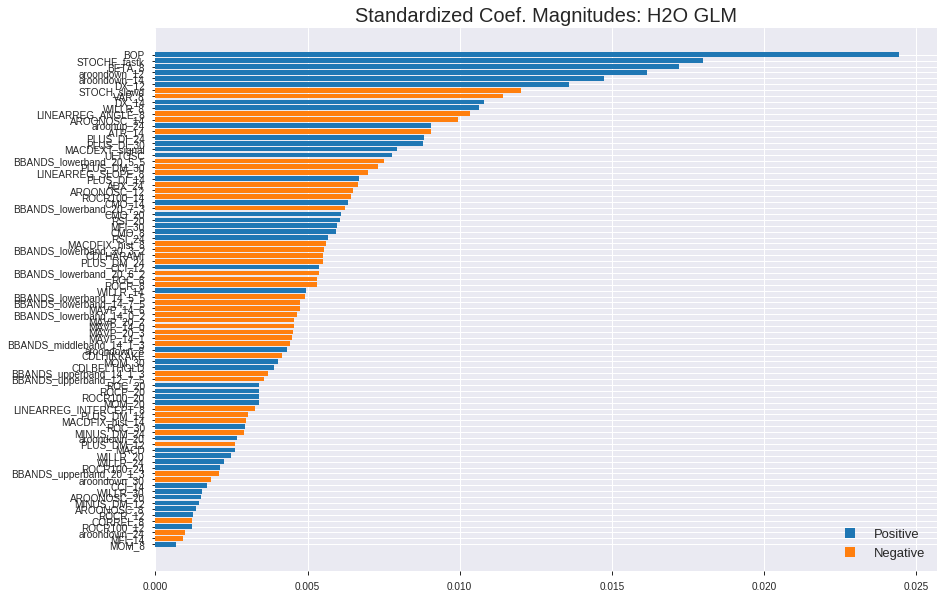

'log_likelihood'
--2019-08-28 17:42:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.120.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.120.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_174204_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_174204_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a241',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'STOCHF_fastk',
 'BETA_8',
 'aroondown_12',
 'aroondown_14',
 'DX_12',
 'STOCH_slowd',
 'VAR_8',
 'DX_14',
 'WILLR_8',
 'LINEARREG_ANGLE_8',
 'AROONOSC_14',
 'aroonup_24',
 'ATR_14',
 'PLUS_DI_24',
 'PLUS_DI_30',
 'MACDEXT_signal',
 'ULTOSC',
 'BBANDS_lowerband_20_5_5',
 'PLUS_DM_30',
 'LINEARREG_SLOPE_8',
 'PLUS_DI_14',
 'ADX_24',
 'AROONOSC_12',
 'ROCR100_14',
 'CMO_14',
 'BBANDS_lowerband_20_7_3',
 'CMO_20',
 'RSI_20',
 'MFI_30',
 'CMO_8',
 'RSI_24',
 'MACDFIX_hist_8',
 'BBANDS_lowerband_20_3_2',
 'CDLHARAMI',
 'PLUS_DM_24',
 'CCI_12',
 'BBANDS_lowerband_20_6_2',
 'ROC_8',
 'ROCR_8',
 'WILLR_14',
 'BBANDS_lowerband_14_5_5',
 'BBANDS_lowerband_14_7_5',
 'MAVP_14_6',
 'BBANDS_lowerband_14_0_2',
 'MAVP_20_2',
 'MAVP_14_0',
 'MAVP_20_3',
 'MAVP_14_1',
 'BBANDS_middleband_14_1_3',
 'aroondown_8',
 'CDLHIKKAKE',
 'MOM_30',
 'CDLBELTHOLD',
 'BBANDS_upperband_14_1_3',
 'BBANDS_upperband_12_7_5',
 'ROC_20',
 'ROCP_20',
 'ROCR100_20',
 'MOM_20',
 'LINEARREG_INTERCEPT_8',
 'PLUS_DM_14

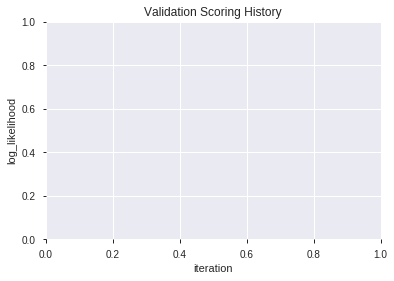

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_174222_model_1  0.555238  0.689751              0.431939  0.498103  0.248107
1  XGBoost_grid_1_AutoML_20190828_174222_model_2  0.549456  0.687590              0.468980  0.497107  0.247115
2  XGBoost_grid_1_AutoML_20190828_174222_model_7  0.538027  0.690068              0.477585  0.498582  0.248584
3               XGBoost_3_AutoML_20190828_174222  0.535102  0.688919              0.493197  0.497892  0.247896
4  XGBoost_grid_1_AutoML_20190828_174222_model_4  0.534422  0.686525              0.465986  0.496751  0.246762
5               XGBoost_1_AutoML_20190828_174222  0.530272  0.691570              0.448367  0.499468  0.249468
6  XGBoost_grid_1_AutoML_20190828_174222_model_3  0.516395  0.692971              0.491395  0.499838  0.249838
7  XGBoost_grid_1_AutoML_20190828_174222_model_5  0.515918  0.723956              0.469388  0.513485  0.263667
8               XGBoost_2_AutoML_20190828_174222  0.510136  0.693995              0.444966  0.500538  0.250538
9  XGBoost_grid_1_AutoML_20190828_174222_model_6  0.488844  0.704061              0.496599  0.505285  0.255313

variable  relative_importance  scaled_importance  percentage
0                       BOP           287.983459           1.000000    0.064950
1                    BETA_8           148.845551           0.516855    0.033570
2               STOCH_slowd           145.889679           0.506590    0.032903
3            MACDEXT_signal           130.643494           0.453649    0.029464
4                     VAR_8           126.886993           0.440605    0.028617
..                      ...                  ...                ...         ...
73                  ROCP_20             9.222068           0.032023    0.002080
74                   ROCR_8             5.799423           0.020138    0.001308
75               ROCR100_12             5.121724           0.017785    0.001155
76                   RSI_20             2.974852           0.010330    0.000671
77  BBANDS_upperband_20_1_3             2.771613           0.009624    0.000625

[78 rows x 4 columns]

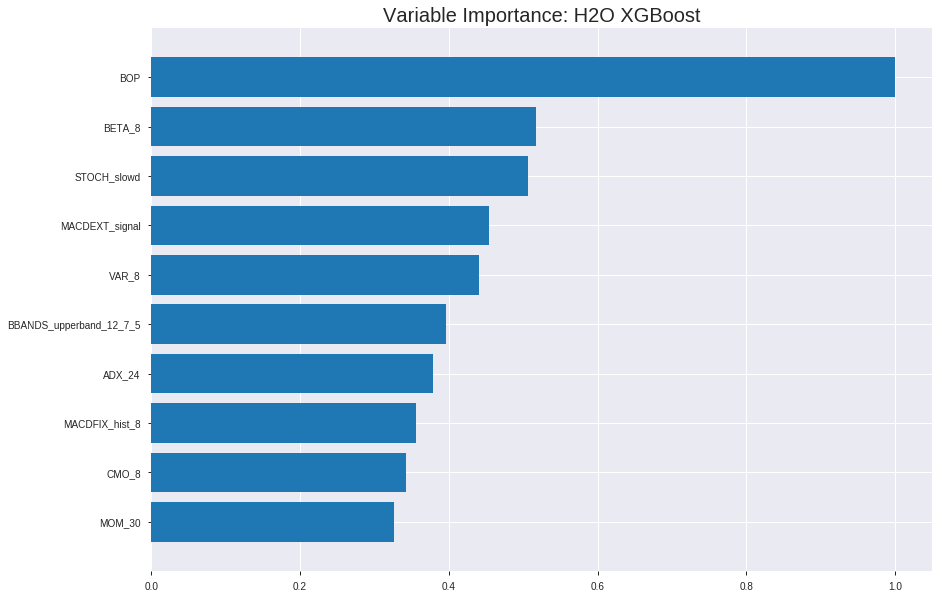

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_174222_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18921682528493006
RMSE: 0.4349906036742978
LogLoss: 0.5682368994728726
Mean Per-Class Error: 0.1651135811036195
AUC: 0.9116730589667917
pr_auc: 0.910301557897728
Gini: 0.8233461179335835
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4878796637058258: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      690  169  0.1967   (169.0/859.0)
1      116  753  0.1335   (116.0/869.0)
Total  806  922  0.1649   (285.0/1728.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48788      0.840871  223
max f2                       0.430455     0.897192  285
max f0point5                 0.519036     0.850782  187
max accuracy                 0.48788      0.835069  223
max precision                0.832796     1         0
max recall                   0.377355     1         339
max specificity              0.832796     1         0
max absolute_mcc             0.48788      0.671276  223
max min_per_class_accuracy   0.497794     0.826237  213
max mean_per_class_accuracy  0.48788      0.834886  223

Gains/Lift Table: Avg response rate: 50.29 %, avg score: 50.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.750133           1.98849   1.98849            1                0.766947  1                           0.766947            0.0207135       0.0207135                  98.8493   98.8493
    2        0.0202546                   0.724516           1.98849   1.98849            1                0.73751   1                           0.752649            0.0195627       0.0402762                  98.8493   98.8493
    3        0.0300926                   0.70553            1.98849   1.98849            1                0.715086  1                           0.740369            0.0195627       0.0598389                  98.8493   98.8493
    4        0.0405093                   0.691784           1.98849   1.98849            1                0.699455  1                           0.729848            0.0207135       0.0805524                  98.8493   98.8493
    5        0.0503472                   0.68521            1.98849   1.98849            1                0.68882   1                           0.721831            0.0195627       0.100115                   98.8493   98.8493
    6        0.100116                    0.644961           1.91913   1.95401            0.965116         0.662273  0.982659                    0.692224            0.0955121       0.195627                   91.9127   95.401
    7        0.150463                    0.615377           1.89707   1.93496            0.954023         0.630057  0.973077                    0.671422            0.0955121       0.291139                   89.7068   93.4956
    8        0.200231                    0.595561           1.87288   1.91953            0.94186          0.605493  0.965318                    0.655035            0.0932106       0.38435                    87.2882   91.9527
    9        0.300347                    0.557344           1.68964   1.8429             0.849711         0.575274  0.926782                    0.628448            0.16916         0.55351                    68.9644   84.29
    10       0.399884                    0.524532           1.52605   1.76403            0.767442         0.541903  0.88712                     0.606906            0.151899        0.705409                   52.6052   76.4032
    11       0.5                         0.4977             1.19539   1.65017            0.601156         0.510418  0.829861                    0.587586            0.119678        0.825086                   19.5394   65.0173
    12       0.600116                    0.466354           0.896546  1.52445            0.450867         0.482357  0.766635                    0.570031            0.0897583       0.914845                   -10.3454  52.4447
    13       0.699653                    0.438607           0.474001  1.375              0.238372         0.451657  0.691481                    0.55319             0.0471807       0.962025                   -52.5999  37.5004
    14       0.799769                    0.409207           0.27586   1.23741            0.138728         0.423975  0.622287                    0.537015            0.027618        0.989643                   -72.414   23.7412
    15       0.899884                    0.371571           0.103448  1.11125            0.0520231        0.392012  0.558842                    0.520883            0.0103567       1                          -89.6552  11.1254
    16       1                           0.239418           0         1                  0                0.338504  0.502894                    0.502624            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25449069813991665
RMSE: 0.5044707108841073
LogLoss: 0.7022817574780894
Mean Per-Class Error: 0.48304556197478987
AUC: 0.4950351234243697
pr_auc: 0.5132127602857973
Gini: -0.009929753151260545
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3756157159805298: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    229  0.9622   (229.0/238.0)
1      1    255  0.0039   (1.0/256.0)
Total  10   484  0.4656   (230.0/494.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375616     0.689189  389
max f2                       0.375616     0.845491  389
max f0point5                 0.375616     0.581661  389
max accuracy                 0.375616     0.534413  389
max precision                0.742789     1         0
max recall                   0.3257       1         399
max specificity              0.742789     1         0
max absolute_mcc             0.375616     0.120309  389
max min_per_class_accuracy   0.494526     0.504202  204
max mean_per_class_accuracy  0.375616     0.516954  389

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 50.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101215                   0.679472           1.15781   1.15781            0.6              0.709749  0.6                         0.709749            0.0117188       0.0117188                  15.7812   15.7812
    2        0.0202429                   0.639498           0.771875  0.964844           0.4              0.663037  0.5                         0.686393            0.0078125       0.0195312                  -22.8125  -3.51562
    3        0.0303644                   0.635977           1.92969   1.28646            1                0.637272  0.666667                    0.670019            0.0195312       0.0390625                  92.9688   28.6458
    4        0.0404858                   0.627312           0.771875  1.15781            0.4              0.633012  0.6                         0.660767            0.0078125       0.046875                   -22.8125  15.7812
    5        0.0506073                   0.616792           1.15781   1.15781            0.6              0.622628  0.6                         0.65314             0.0117188       0.0585938                  15.7812   15.7812
    6        0.101215                    0.596042           0.849062  1.00344            0.44             0.607385  0.52                        0.630262            0.0429688       0.101562                   -15.0938  0.34375
    7        0.149798                    0.569214           0.964844  0.990921           0.5              0.57901   0.513514                    0.61364             0.046875        0.148438                   -3.51562  -0.907939
    8        0.200405                    0.55542            0.6175    0.896622           0.32             0.562326  0.464646                    0.600682            0.03125         0.179688                   -38.25    -10.3378
    9        0.299595                    0.52864            1.0633    0.951805           0.55102          0.541795  0.493243                    0.581185            0.105469        0.285156                   6.32972   -4.81947
    10       0.40081                     0.510701           1.27359   1.03307            0.66             0.519489  0.535354                    0.565605            0.128906        0.414062                   27.3594   3.3065
    11       0.5                         0.49459            0.905772  1.00781            0.469388         0.501506  0.522267                    0.552889            0.0898438       0.503906                   -9.42283  0.78125
    12       0.59919                     0.479394           0.827009  0.977882           0.428571         0.487078  0.506757                    0.541995            0.0820312       0.585938                   -17.2991  -2.21178
    13       0.700405                    0.462334           1.15781   1.00388            0.6              0.471916  0.520231                    0.531868            0.117188        0.703125                   15.7812   0.388367
    14       0.799595                    0.444437           0.984534  1.00148            0.510204         0.453981  0.518987                    0.522206            0.0976562       0.800781                   -1.54656  0.148339
    15       0.898785                    0.421316           1.0633    1.00831            0.55102          0.434273  0.522523                    0.512502            0.105469        0.90625                    6.32972   0.830518
    16       1                           0.3257             0.92625   1                  0.48             0.390299  0.518219                    0.500133 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:42:26  0.015 sec   0                  0.5              0.693147            0.5             0                  1                0.497106                         0.5                0.693147              0.5               0                    1                  0.481781
    2019-08-28 17:42:27  0.180 sec   5                  0.488509         0.67037             0.768217        0.755888           1.69022          0.352431                         0.501328           0.695807              0.457343          0.496134             1.15781            0.479757
    2019-08-28 17:42:27  0.258 sec   10                 0.477562         0.64899             0.818911        0.802372           1.76755          0.271991                         0.501482           0.696111              0.473822          0.510081             1.54375            0.475709
    2019-08-28 17:42:27  0.324 sec   15                 0.471076         0.636438            0.835543        0.823558           1.77918          0.230903                         0.501456           0.696056              0.486492          0.517596             1.54375            0.473684
    2019-08-28 17:42:27  0.389 sec   20                 0.465507         0.625686            0.846276        0.83725            1.87802          0.233796                         0.501481           0.696108              0.497989          0.529696             1.54375            0.475709
    2019-08-28 17:42:27  0.451 sec   25                 0.46162          0.618201            0.852519        0.844901           1.87802          0.234954                         0.502211           0.69758               0.49268           0.520743             1.54375            0.477733
    2019-08-28 17:42:27  0.520 sec   30                 0.454996         0.605632            0.871692        0.866543           1.98849          0.209491                         0.502646           0.698476              0.49259           0.516152             1.54375            0.479757
    2019-08-28 17:42:27  0.590 sec   35                 0.451325         0.598643            0.876461        0.872443           1.98849          0.21412                          0.502839           0.698886              0.493418          0.51379              1.15781            0.479757
    2019-08-28 17:42:27  0.657 sec   40                 0.44699          0.590485            0.886008        0.883043           1.98849          0.195602                         0.503849           0.700949              0.488774          0.509543             1.15781            0.473684
    2019-08-28 17:42:27  0.730 sec   45                 0.440649         0.578723            0.90233         0.898429           1.98849          0.178819                         0.504059           0.701372              0.490251          0.514265             1.15781            0.47166
    2019-08-28 17:42:27  0.806 sec   50                 0.434991         0.568237            0.911673        0.910302           1.98849          0.164931                         0.504471           0.702282              0.495035          0.513213             1.15781            0.465587

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
BOP                      287.98345947265625     1.0                   0.06494965014932692
BETA_8                   148.84555053710938     0.5168545124420318    0.033569519761210906
STOCH_slowd              145.88967895507812     0.5065904799609862    0.03290287444244566
MACDEXT_signal           130.64349365234375     0.45364929601016973   0.029464363066348975
VAR_8                    126.88699340820312     0.4406051432278558    0.028617149906643317
---                      ---                    ---                   ---
ROCP_20                  9.222067832946777      0.032022908016432115  0.002079876672431343
ROCR_8                   5.7994232177734375     0.02013804274868115   0.0013079588312190308
ROCR100_12               5.1217241287231445     0.017784785758535718  0.0011551156129976266
RSI_20                   2.974851608276367      0.010329939135128788  0.0006709259328904556
BBANDS_upperband_20_1_3  2.771613359451294      0.009624210239458062  0.000625089088016371


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5910931174089069)

('F1', 0.5824561403508772)

('auc', 0.5552380952380953)

('logloss', 0.6897507463170387)

('mean_per_class_error', 0.42608843537414964)

('rmse', 0.49810339415069665)

('mse', 0.24810699126444427)

xgboost prediction progress: |████████████████████████████████████████████| 100%


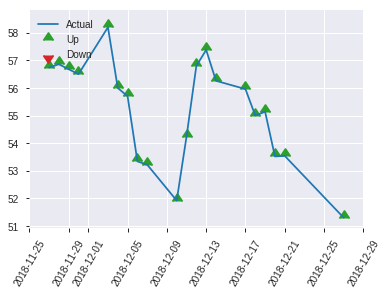


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24810699126444427
RMSE: 0.49810339415069665
LogLoss: 0.6897507463170387
Mean Per-Class Error: 0.42608843537414964
AUC: 0.5552380952380953
pr_auc: 0.41517094599359794
Gini: 0.11047619047619062
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4355733096599579: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      45   102  0.6939   (102.0/147.0)
1      17   83   0.17     (17.0/100.0)
Total  62   185  0.4818   (119.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435573     0.582456  184
max f2                       0.324042     0.772798  246
max f0point5                 0.44774      0.496032  163
max accuracy                 0.705495     0.591093  0
max precision                0.475488     0.475806  123
max recall                   0.324042     1         246
max specificity              0.705495     0.993197  0
max absolute_mcc             0.435573     0.154101  184
max min_per_class_accuracy   0.482445     0.564626  120
max mean_per_class_accuracy  0.475488     0.573912  123

Gains/Lift Table: Avg response rate: 40.49 %, avg score: 48.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.671149           0         0                  0                0.697399  0                           0.697399            0               0                          -100      -100
    2        0.0202429                   0.651111           1.235     0.494              0.5              0.654328  0.2                         0.680171            0.01            0.01                       23.5      -50.6
    3        0.0323887                   0.624007           0.823333  0.6175             0.333333         0.637988  0.25                        0.664352            0.01            0.02                       -17.6667  -38.25
    4        0.0404858                   0.616566           0         0.494              0                0.618169  0.2                         0.655116            0               0.02                       -100      -50.6
    5        0.0526316                   0.595741           0.823333  0.57               0.333333         0.604711  0.230769                    0.643484            0.01            0.03                       -17.6667  -43
    6        0.101215                    0.574264           0.6175    0.5928             0.25             0.581719  0.24                        0.613837            0.03            0.06                       -38.25    -40.72
    7        0.149798                    0.554406           1.8525    1.00135            0.75             0.566248  0.405405                    0.598403            0.09            0.15                       85.25     0.135135
    8        0.202429                    0.543694           0.95      0.988              0.384615         0.549869  0.4                         0.585784            0.05            0.2                        -5        -1.2
    9        0.299595                    0.522517           1.33792   1.10149            0.541667         0.534231  0.445946                    0.569064            0.13            0.33                       33.7917   10.1486
    10       0.40081                     0.495824           0.8892    1.04788            0.36             0.508338  0.424242                    0.553729            0.09            0.42                       -11.08    4.78788
    11       0.502024                    0.475488           1.6796    1.17524            0.68             0.488308  0.475806                    0.540539            0.17            0.59                       67.96     17.5242
    12       0.59919                     0.458055           0.6175    1.0848             0.25             0.468261  0.439189                    0.528819            0.06            0.65                       -38.25    8.47973
    13       0.700405                    0.441799           1.1856    1.09936            0.48             0.449855  0.445087                    0.517408            0.12            0.77                       18.56     9.93642
    14       0.797571                    0.424059           0.823333  1.06574            0.333333         0.434295  0.431472                    0.507282            0.08            0.85                       -17.6667  6.5736
    15       0.898785                    0.399387           0.7904    1.03473            0.32             0.414167  0.418919                    0.496796            0.08            0.93                       -20.96    3.47297
    16       1                           0.324042           0.6916    1                  0.28             0.371061  0.404858                    0.48407             0.07         

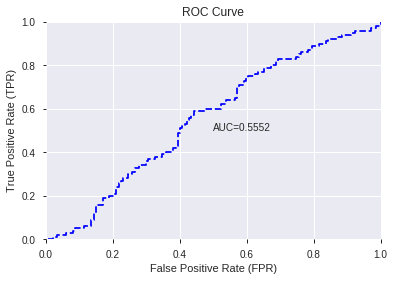

This function is available for GLM models only


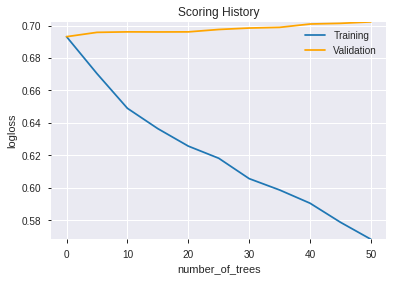

--2019-08-28 17:42:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_174222_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_174222_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a241',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'BETA_8',
 'STOCH_slowd',
 'MACDEXT_signal',
 'VAR_8',
 'BBANDS_upperband_12_7_5',
 'ADX_24',
 'MACDFIX_hist_8',
 'CMO_8',
 'MOM_30',
 'ULTOSC',
 'MINUS_DM_12',
 'CORREL_8',
 'CCI_14',
 'LINEARREG_ANGLE_8',
 'MOM_20',
 'BBANDS_lowerband_20_5_5',
 'AROONOSC_8',
 'BBANDS_lowerband_20_7_3',
 'aroondown_14',
 'MACD',
 'STOCHF_fastk',
 'PLUS_DM_30',
 'PLUS_DM_24',
 'PLUS_DI_24',
 'aroondown_30',
 'PLUS_DM_14',
 'ROCR100_24',
 'WILLR_24',
 'aroondown_12',
 'MFI_30',
 'WILLR_20',
 'MFI_14',
 'ROC_30',
 'CMO_14',
 'PLUS_DI_30',
 'WILLR_14',
 'aroondown_8',
 'BBANDS_upperband_14_1_3',
 'WILLR_8',
 'ROCR100_14',
 'CCI_12',
 'RSI_24',
 'ATR_14',
 'ROC_8',
 'DX_14',
 'MINUS_DM_24',
 'AROONOSC_20',
 'BBANDS_lowerband_20_3_2',
 'ROC_20',
 'DX_12',
 'BBANDS_lowerband_20_6_2',
 'BBANDS_middleband_14_1_3',
 'MOM_8',
 'ROCR_12',
 'aroondown_24',
 'MAVP_14_6',
 'BBANDS_lowerband_14_5_5',
 'LINEARREG_SLOPE_8',
 'AROONOSC_14',
 'PLUS_DI_14',
 'aroonup_24',
 'PLUS_DM_12',
 'BBANDS_lowerband_14_7_5'

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.648
GLM             0.640
XGBoost         0.619
dtype: float64

DeepLearning    GLM  XGBoost
All          0.636  0.603    0.603
DLF          0.648  0.640    0.619
Fwe          0.628  0.603    0.603
RFE          0.644  0.607    0.591
XGBF         0.628  0.640    0.619





F1


DeepLearning    0.592
GLM             0.589
XGBoost         0.610
dtype: float64

DeepLearning    GLM  XGBoost
All          0.581  0.583    0.610
DLF          0.581  0.589    0.589
Fwe          0.581  0.583    0.610
RFE          0.592  0.581    0.582
XGBF         0.576  0.589    0.589





auc


DeepLearning    0.617
GLM             0.528
XGBoost         0.604
dtype: float64

DeepLearning    GLM  XGBoost
All          0.581  0.496    0.578
DLF          0.598  0.528    0.604
Fwe          0.576  0.496    0.578
RFE          0.617  0.508    0.555
XGBF         0.578  0.528    0.604





logloss


DeepLearning    1.109
GLM             0.693
XGBoost         0.690
dtype: float64

DeepLearning    GLM  XGBoost
All          0.712  0.688    0.678
DLF          1.001  0.693    0.670
Fwe          1.035  0.688    0.678
RFE          1.109  0.688    0.690
XGBF         0.897  0.693    0.670





mean_per_class_error


DeepLearning    0.420
GLM             0.458
XGBoost         0.426
dtype: float64

DeepLearning    GLM  XGBoost
All          0.420  0.455    0.407
DLF          0.413  0.434    0.388
Fwe          0.417  0.455    0.407
RFE          0.378  0.458    0.426
XGBF         0.407  0.434    0.388





rmse


DeepLearning    0.578
GLM             0.500
XGBoost         0.498
dtype: float64

DeepLearning    GLM  XGBoost
All          0.509  0.498    0.493
DLF          0.566  0.500    0.489
Fwe          0.578  0.498    0.493
RFE          0.574  0.497    0.498
XGBF         0.519  0.500    0.489





mse


DeepLearning    0.334
GLM             0.250
XGBoost         0.248
dtype: float64

DeepLearning    GLM  XGBoost
All          0.259  0.248    0.243
DLF          0.320  0.250    0.239
Fwe          0.334  0.248    0.243
RFE          0.329  0.247    0.248
XGBF         0.269  0.250    0.239

{'F1':       DeepLearning    GLM  XGBoost
 All          0.581    NaN      NaN
 DLF          0.581    NaN      NaN
 DLF            NaN  0.589      NaN
 DLF            NaN    NaN    0.589
 All            NaN  0.583      NaN
 All            NaN    NaN    0.610
 XGBF         0.576    NaN      NaN
 XGBF           NaN  0.589      NaN
 XGBF           NaN    NaN    0.589
 Fwe          0.581    NaN      NaN
 Fwe            NaN  0.583      NaN
 Fwe            NaN    NaN    0.610
 RFE          0.592    NaN      NaN
 RFE            NaN  0.581      NaN
 RFE            NaN    NaN    0.582,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.636    NaN      NaN
 DLF          0.648    NaN      NaN
 DLF            NaN  0.640      NaN
 DLF            NaN    NaN    0.619
 All            NaN  0.603      NaN
 All            NaN    NaN    0.603
 XGBF         0.628    NaN      NaN
 XGBF           NaN  0.640      NaN
 XGBF           NaN    NaN    0.619
 Fwe          0.628    NaN      NaN
 Fwe     